# Cannabis Stocks and Media Hype

Cannabis stocks have for a few years now been hyped up as the new "tech stocks", promising to be to current investors what Apple and Microsoft were decades ago. With marijuana fully legalized in Canada, and fully legal status or reduced decriminalization in thirty-seven of the United States, many investors jumped onboard in 2018 when major cannabis companies, some believing in the product, others believing in the profit. 

As the demand for the stocks increased, certain stocks saw near-exponential growth, to the wonder and admiration of investors and analysts alike. But how much of that growth was a natural reflection on the product and how much was artificially inflated hype?


## Step 1: Source Stock Data from NASDAQ

Using open-source Python code, I scraped stock information from NASDAQ for Tilray, Inc. (TLRY), Canopy Growth Corp. (CGC), Aurora Cannabis (ACB), and Cronos Group (CRON), four of the most commonly discussed cannabis stocks. These were then stored in JSON files.

In [1]:
# importing necessary libraries

from lxml import html
import requests
from time import sleep
import json
import argparse
from random import randint

import pandas as pd

In [2]:
# opening TLRY stock info from json file

f = open('tlry-summary.json')
data = json.load(f)
print(type(data))
data

<class 'dict'>


{'company_name': '',
 'ticker': 'tlry',
 'url': 'http://www.nasdaq.com/symbol/tlry',
 'open price': None,
 'open_date': None,
 'close_price': None,
 'close_date': None,
 'key_stock_data': {}}

That's not very useful. Also, for our purposes, we need historical data, not just the data for the current day, which is what the webpage presents. Fortunately, NASDAQ provides historical data in a csv file.

In [2]:
tlry = pd.read_csv('TLRYHistoricalQuotes.csv') # opening csv file
tlry_asc = tlry.iloc[::-1] #Putting the dates in ascending order
tlry_asc.head() # previewing dataframe

Date  Close/Last    Volume    Open    High     Low
346  07/19/2018      $22.39  11912880  $23.05  $24.00  $20.10
345  07/20/2018      $29.77  13947110  $24.25  $31.80  $23.50
344  07/23/2018      $29.45   9984060  $33.48  $34.10  $29.31
343  07/24/2018      $25.36   5494133  $28.80  $29.43  $25.25
342  07/25/2018      $26.49   3845034  $25.31  $27.15  $24.20

In [3]:
acb = pd.read_csv('ACBHistoricalQuotes.csv')
acb_asc = acb.iloc[::-1]
acb_asc.head()

Date  Close/Last  Volume   Open   High    Low
1258  12/03/2014       $0.91     N/A  $0.91  $0.91  $0.91
1257  12/04/2014       $0.91     N/A  $0.91  $0.91  $0.91
1256  12/05/2014       $0.91     N/A  $0.91  $0.91  $0.91
1255  12/08/2014       $0.91     N/A  $0.91  $0.91  $0.91
1254  12/09/2014       $0.91     N/A  $0.91  $0.91  $0.91

In [4]:
cgc = pd.read_csv('CGCHistoricalQuotes.csv')
cgc_asc = cgc.iloc[::-1]
cgc_asc.head()

Date  Close/Last  Volume   Open   High    Low
1057  09/22/2015       $1.38    5324  $1.36  $1.38  $1.36
1056  09/23/2015       $1.33   10500  $1.36  $1.36  $1.33
1055  09/24/2015       $1.30    3734  $1.34  $1.35  $1.29
1054  09/25/2015       $1.32    9354  $1.34  $1.34  $1.32
1053  09/28/2015       $1.23    5914  $1.30  $1.30  $1.22

In [5]:
cron = pd.read_csv('CRONHistoricalQuotes.csv')
cron_asc = cron.iloc[::-1]
cron_asc.head()

Date  Close/Last   Volume   Open   High    Low
20  11/04/2019       $8.08  4312321  $8.20  $8.30  $8.08
19  11/05/2019       $8.23  3596968  $8.12  $8.43  $8.08
18  11/06/2019       $8.33  3645152  $8.31  $8.48  $8.17
17  11/07/2019       $7.93  6158625  $8.40  $8.52  $7.86
16  11/08/2019       $8.52  7920348  $7.95  $8.60  $7.86

From the previews of the dataframes, we can see that Aurora Cannabis (ACB) was the first to go public in December 2014, followed by Canopy Growth Corporation (CGC) in September 2015. Tilray, Inc. (TLRY) and Cronos Group (CRON) are relatively new, going public in July 2018 and November 2019, respectively.

## Step 2: Data Preprocessing/Cleaning

In [6]:
# checking for null values
print(tlry_asc.isnull().sum()) 
print(acb_asc.isnull().sum())
print(cgc_asc.isnull().sum())
cron_asc.isnull().sum()

Date           0
 Close/Last    0
 Volume        0
 Open          0
 High          0
 Low           0
dtype: int64
Date           0
 Close/Last    0
 Volume        0
 Open          0
 High          0
 Low           0
dtype: int64
Date           0
 Close/Last    0
 Volume        0
 Open          0
 High          0
 Low           0
dtype: int64


Date           0
 Close/Last    0
 Volume        0
 Open          0
 High          0
 Low           0
dtype: int64

Luckily, we have no null values to fill in. Now, let's limit our dataframe to the values we'll be using in our time series analysis. 

In [7]:
# previewing columns
print(list(tlry_asc.columns))
print(list(acb_asc.columns))
print(list(cgc_asc.columns))
list(cron_asc.columns)

['Date', ' Close/Last', ' Volume', ' Open', ' High', ' Low']
['Date', ' Close/Last', ' Volume', ' Open', ' High', ' Low']
['Date', ' Close/Last', ' Volume', ' Open', ' High', ' Low']


['Date', ' Close/Last', ' Volume', ' Open', ' High', ' Low']

As we can see, there is a space before the names of the columns. We need to remove this to facilitate the processing of our data.

In [8]:
# renaming columns to remove white space and punctuation

tlry_asc.rename(columns={' Close/Last':'Close',
                        ' Volume': 'Volume',
                        ' Open': 'Open',
                        ' High': 'High',
                        ' Low': 'Low'},
                inplace=True)
list(tlry_asc.columns)

['Date', 'Close', 'Volume', 'Open', 'High', 'Low']

In [9]:
acb_asc.rename(columns={' Close/Last':'Close',
                        ' Volume': 'Volume',
                        ' Open': 'Open',
                        ' High': 'High',
                        ' Low': 'Low'},
                inplace=True)
list(acb_asc.columns)

['Date', 'Close', 'Volume', 'Open', 'High', 'Low']

In [10]:
cgc_asc.rename(columns={' Close/Last':'Close',
                        ' Volume': 'Volume',
                        ' Open': 'Open',
                        ' High': 'High',
                        ' Low': 'Low'},
                inplace=True)
list(cgc_asc.columns)

['Date', 'Close', 'Volume', 'Open', 'High', 'Low']

In [11]:
cron_asc.rename(columns={' Close/Last':'Close',
                        ' Volume': 'Volume',
                        ' Open': 'Open',
                        ' High': 'High',
                        ' Low': 'Low'},
                inplace=True)
list(cron_asc.columns)

['Date', 'Close', 'Volume', 'Open', 'High', 'Low']

In [12]:
#dropping irrelevant column
tlry_ts = tlry_asc.drop(columns=['Volume'])
acb_ts = acb_asc.drop(columns=['Volume'])
cgc_ts = cgc_asc.drop(columns=['Volume'])
cron_ts = cron_asc.drop(columns=['Volume'])

## Step 3: Time Series Analysis

Before we begin to consider the media hype's effects on the stock prices, we need to test for seasonality.

In [13]:
def get_datetimes(df): #function to convert date to date/time format
    return pd.to_datetime(df.Date)

In [14]:
#passing each stock through date/time function
tlry_ts['Date'] = get_datetimes(tlry_ts) 

acb_ts['Date'] = get_datetimes(acb_ts)

cgc_ts['Date'] = get_datetimes(cgc_ts)

cron_ts['Date'] = get_datetimes(cron_ts)

In [15]:
#setting the date column as the index for each stock
tlry_ts.set_index('Date', inplace=True)
acb_ts.set_index('Date', inplace = True)
cgc_ts.set_index('Date', inplace = True)
cron_ts.set_index('Date', inplace=True)

In [16]:
tlry_ts.dtypes #previewing the data type for each column

Close    object
Open     object
High     object
Low      object
dtype: object

In [17]:
#removing punctuation from each column for easier conversion later
tlry_ts.Open = tlry_ts.Open.str.strip('$')
tlry_ts.Close = tlry_ts.Close.str.strip('$')
tlry_ts.High = tlry_ts.High.str.strip('$')
tlry_ts.Low = tlry_ts.Low.str.strip('$')

acb_ts.Open = acb_ts.Open.str.strip('$')
acb_ts.Close = acb_ts.Close.str.strip('$')
acb_ts.High = acb_ts.High.str.strip('$')
acb_ts.Low = acb_ts.Low.str.strip('$')

cgc_ts.Open = cgc_ts.Open.str.strip('$')
cgc_ts.Close = cgc_ts.Close.str.strip('$')
cgc_ts.High = cgc_ts.High.str.strip('$')
cgc_ts.Low = cgc_ts.Low.str.strip('$')

cron_ts.Open = cron_ts.Open.str.strip('$')
cron_ts.Close = cron_ts.Close.str.strip('$')
cron_ts.High = cron_ts.High.str.strip('$')
cron_ts.Low = cron_ts.Low.str.strip('$')

In [18]:
#changing each column from string to integer
tlry_ts.Open = pd.to_numeric(tlry_ts.Open)
tlry_ts.Close = pd.to_numeric(tlry_ts.Close)
tlry_ts.High = pd.to_numeric(tlry_ts.High)
tlry_ts.Low = pd.to_numeric(tlry_ts.Low)

acb_ts.Open = pd.to_numeric(acb_ts.Open)
acb_ts.Close = pd.to_numeric(acb_ts.Open)
acb_ts.High = pd.to_numeric(acb_ts.High)
acb_ts.Low = pd.to_numeric(acb_ts.Low)

cgc_ts.Open = pd.to_numeric(cgc_ts.Open)
cgc_ts.Close = pd.to_numeric(cgc_ts.Close)
cgc_ts.High = pd.to_numeric(cgc_ts.High)
cgc_ts.Low = pd.to_numeric(cgc_ts.Low)

cron_ts.Open = pd.to_numeric(cron_ts.Open)
cron_ts.Close = pd.to_numeric(cron_ts.Close)
cron_ts.High = pd.to_numeric(cron_ts.High)
cron_ts.Low = pd.to_numeric(cron_ts.Low)

In [19]:
tlry_ts.dtypes # previewing each coluumn to ensure type has been changed

Close    float64
Open     float64
High     float64
Low      float64
dtype: object

In [526]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go #importing necessary graphing libraries

fig1 = go.Figure(data=[go.Candlestick(x=tlry_ts.index,
                open=tlry_ts['Open'],
                high=tlry_ts['High'],
                low=tlry_ts['Low'],
                close=tlry_ts['Close'])]) #plotting dataframe as candlestick plot

fig1.show()

In [527]:
fig2 = go.Figure(data=[go.Candlestick(x=acb_ts.index,
                open=acb_ts['Open'],
                high=acb_ts['High'],
                low=acb_ts['Low'],
                close=acb_ts['Close'])])

fig2.show()

In [528]:
fig3 = go.Figure(data=[go.Candlestick(x=cgc_ts.index,
                open=cgc_ts['Open'],
                high=cgc_ts['High'],
                low=cgc_ts['Low'],
                close=cgc_ts['Close'])])

fig3.show()

In [529]:
fig4 = go.Figure(data=[go.Candlestick(x=cron_ts.index,
                open=cron_ts['Open'],
                high=cron_ts['High'],
                low=cron_ts['Low'],
                close=cron_ts['Close'])])

fig4.show()

### Testing for Stationarity and Seasonality

In [21]:
# converting dataframes to Series in preparation for stationarity/seasonality testing
tlry_open = pd.Series(tlry_ts['Open'])
tlry_close = pd.Series(tlry_ts['Close'])
tlry_high = pd.Series(tlry_ts['High'])
tlry_low = pd.Series(tlry_ts['Low'])

acb_open = pd.Series(acb_ts['Open'])
acb_close = pd.Series(acb_ts['Close'])
acb_high = pd.Series(acb_ts['High'])
acb_low = pd.Series(acb_ts['Low'])

cgc_open = pd.Series(cgc_ts['Open'])
cgc_close = pd.Series(cgc_ts['Close'])
cgc_high = pd.Series(cgc_ts['High'])
cgc_low = pd.Series(cgc_ts['Low'])

cron_open = pd.Series(cron_ts['Open'])
cron_close = pd.Series(cron_ts['Close'])
cron_high = pd.Series(cron_ts['High'])
cron_low = pd.Series(cron_ts['Low'])

In [22]:
def test_stationarity(timeseries, window):
    
    #Defining rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='#87CEEB',label='Original')
    mean = plt.plot(rolmean, color='#FFC0CB', label='Rolling Mean')
    std = plt.plot(rolstd, color='#008000', label = 'Rolling Std')
    plt.legend(loc='upper left')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

/Users/shannonamcchesney/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


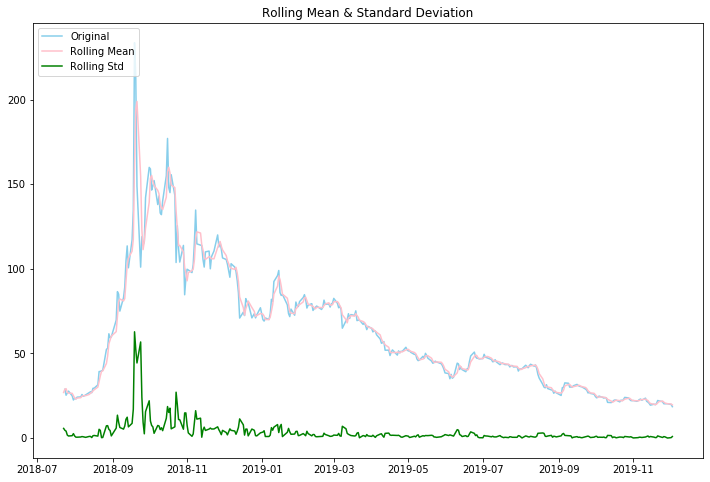

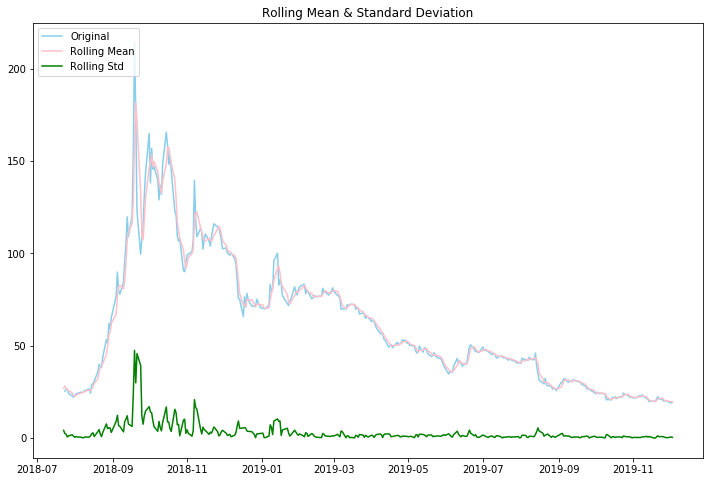

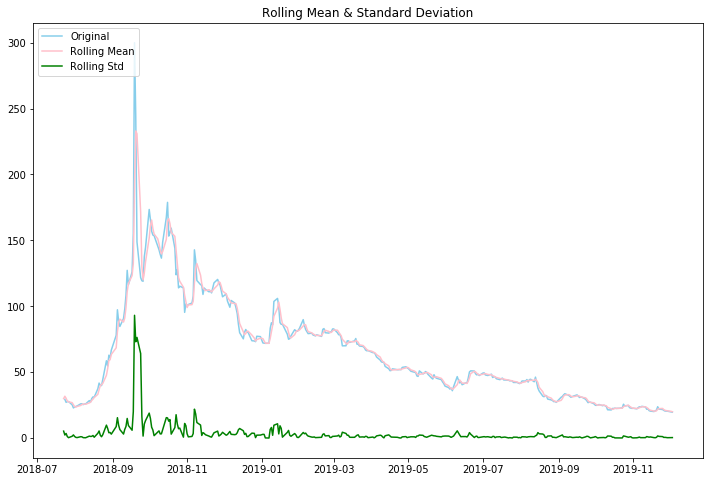

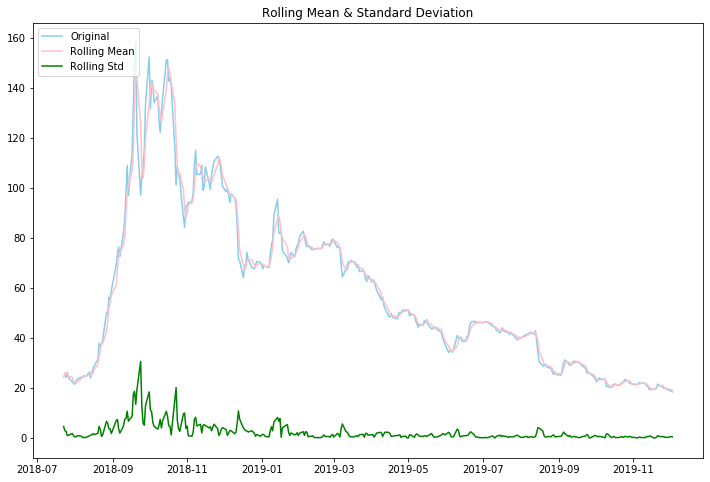

In [23]:
#testing each column in tlry dataframe for stationarity
test_stationarity(tlry_open, 3)
test_stationarity(tlry_close, 3)
test_stationarity(tlry_high, 3)
test_stationarity(tlry_low, 3)

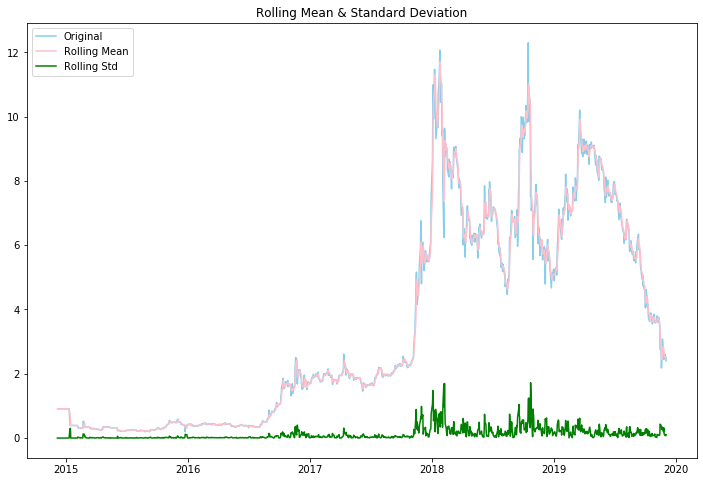

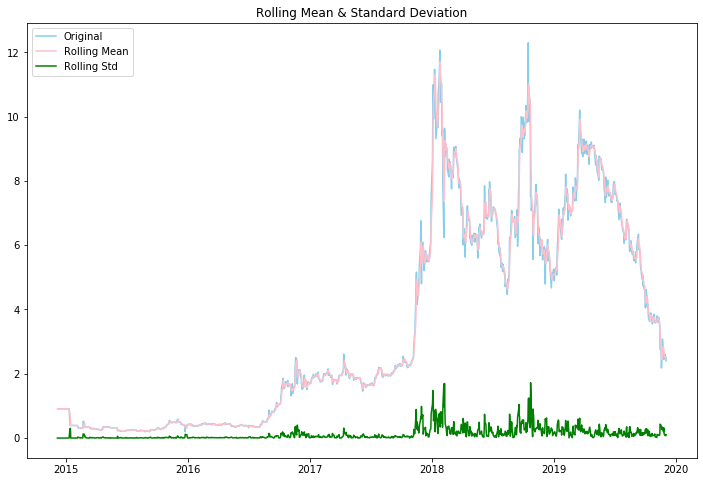

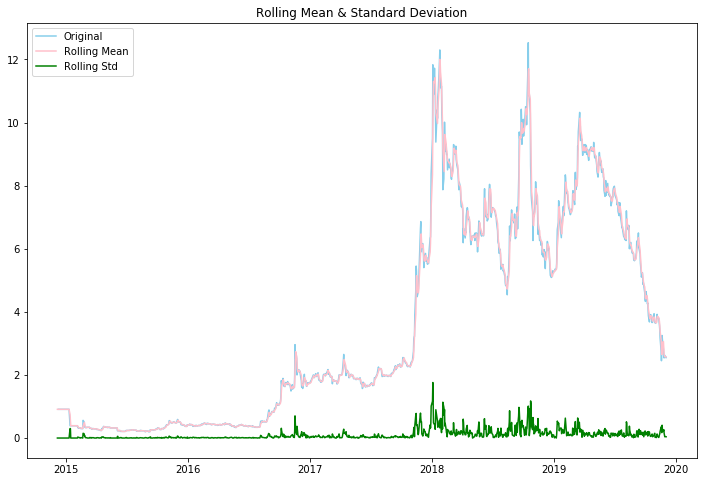

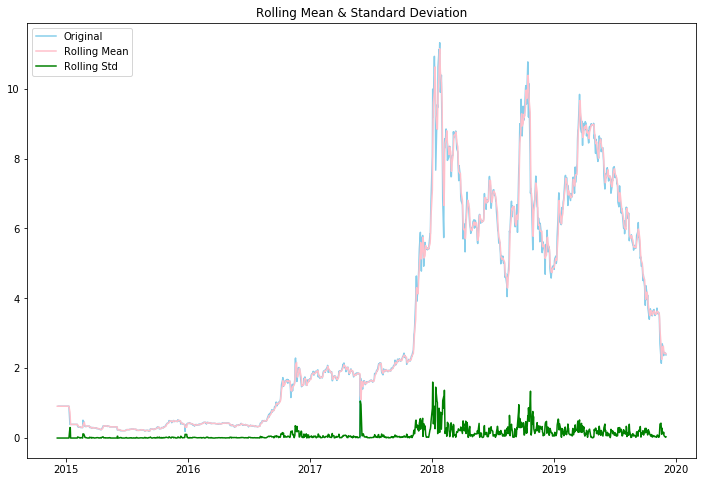

In [24]:
#testing each column in acb dataframe for stationarity
test_stationarity(acb_open, 3)
test_stationarity(acb_close, 3)
test_stationarity(acb_high, 3)
test_stationarity(acb_low, 3)

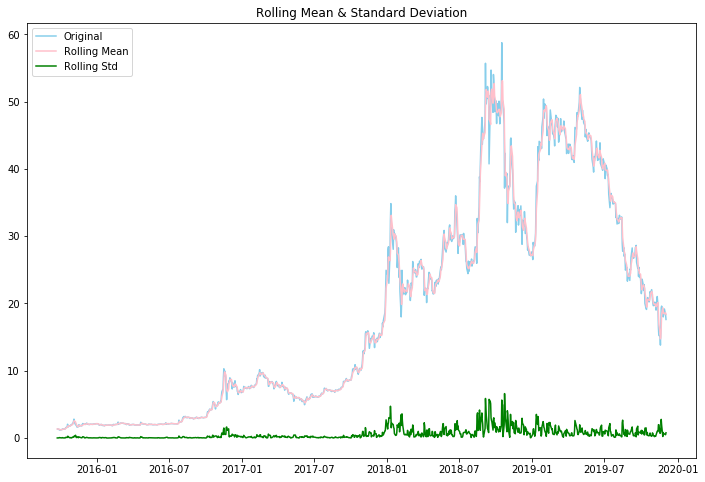

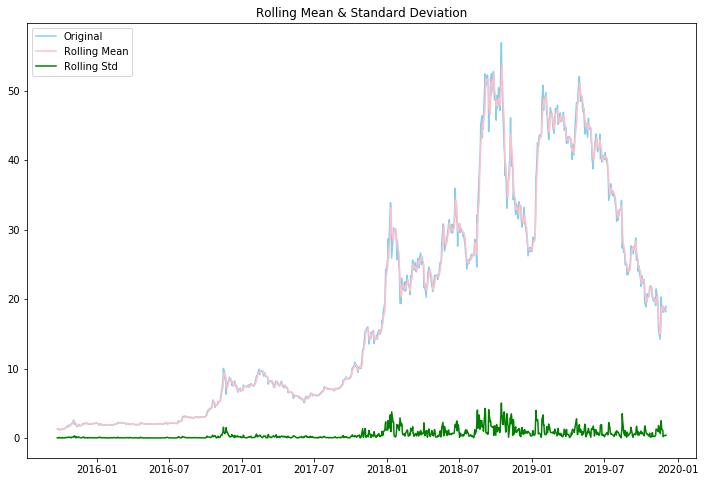

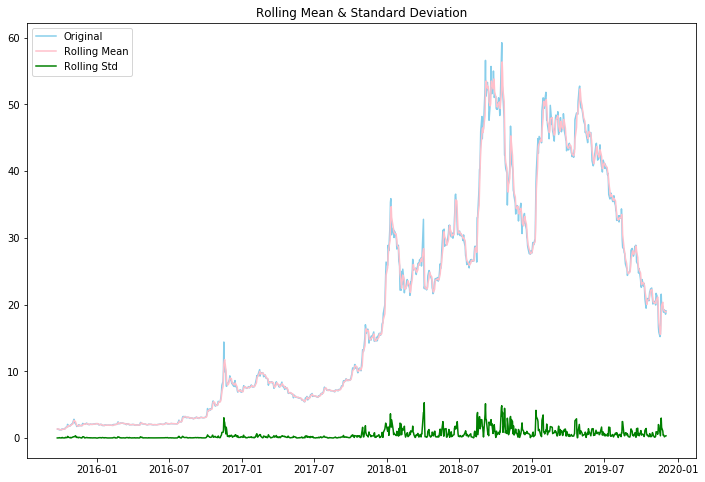

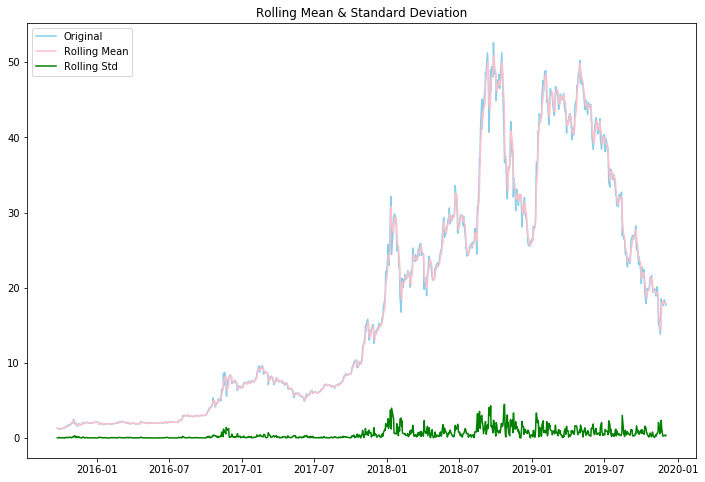

In [25]:
#testing each column in cgc dataframe for stationarity
test_stationarity(cgc_open, 3)
test_stationarity(cgc_close, 3)
test_stationarity(cgc_high, 3)
test_stationarity(cgc_low, 3)

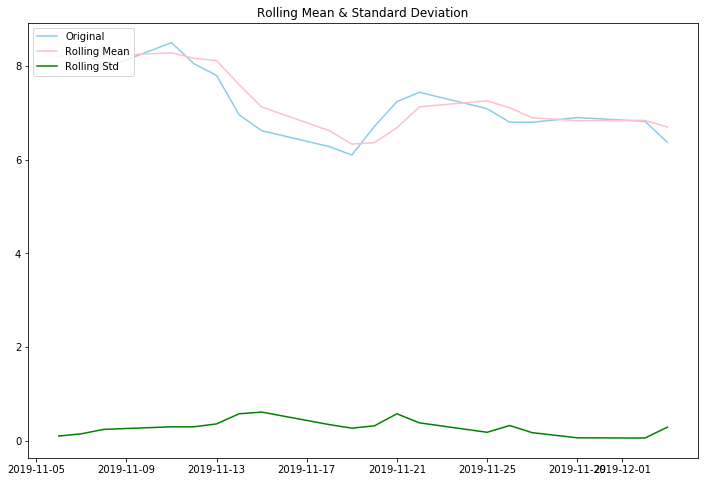

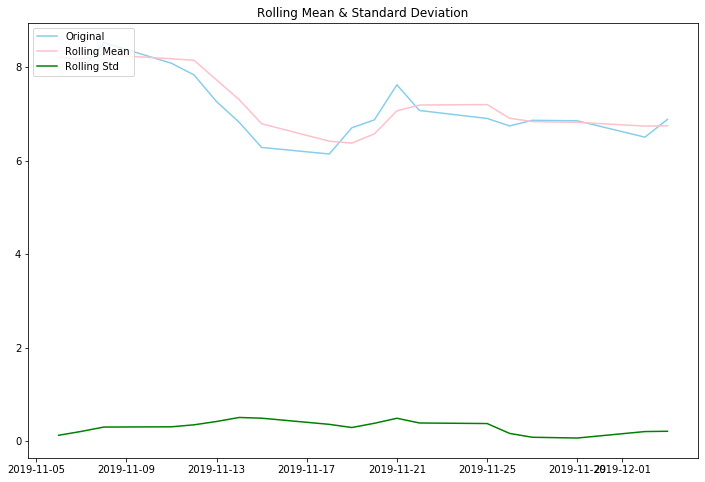

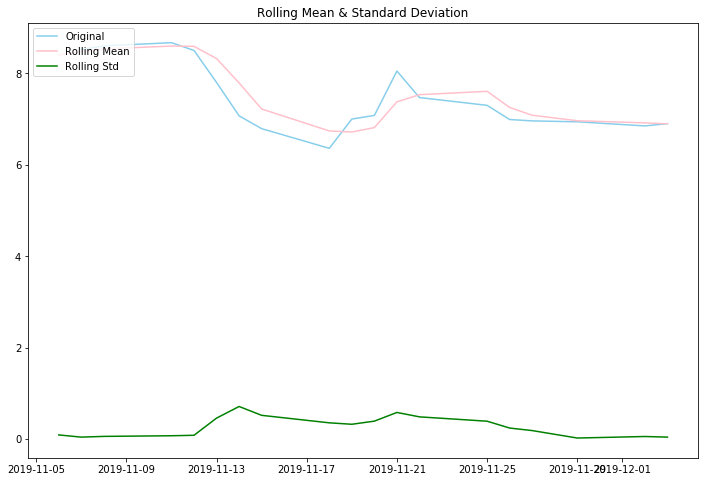

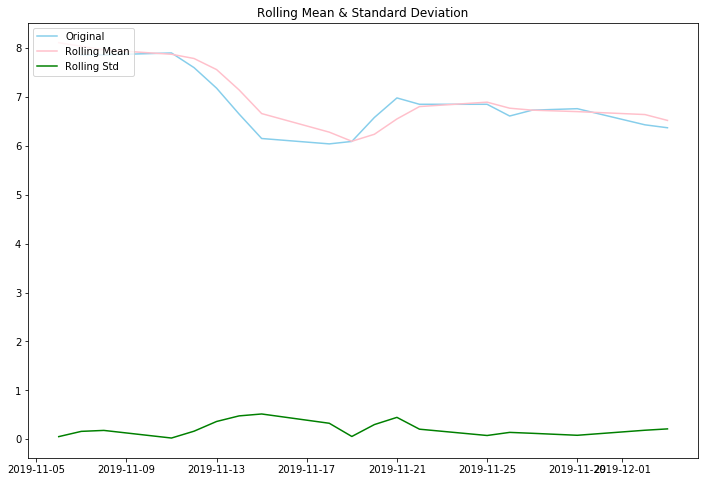

In [26]:
#testing each column in cron dataframe for stationarity
test_stationarity(cron_open, 3)
test_stationarity(cron_close, 3)
test_stationarity(cron_high, 3)
test_stationarity(cron_low, 3)

In [27]:
#importing necessary libraries for statistical modeling
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

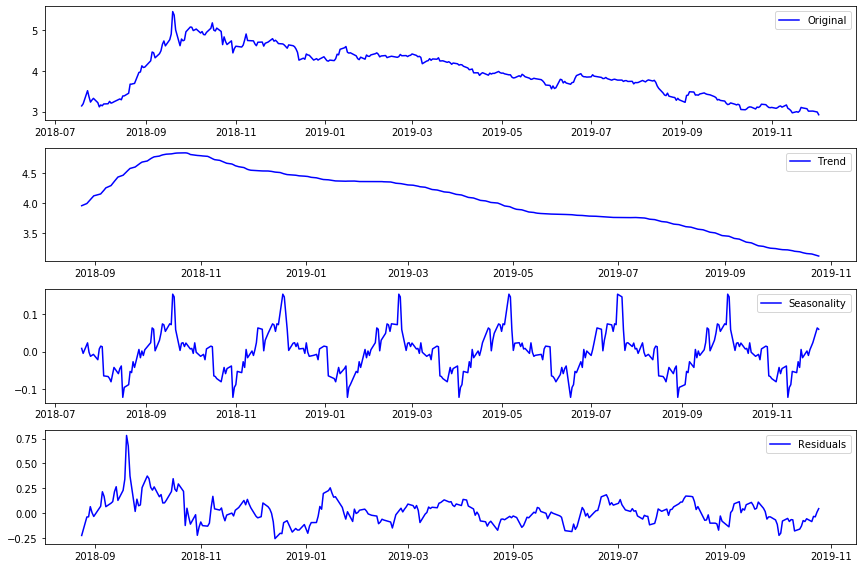

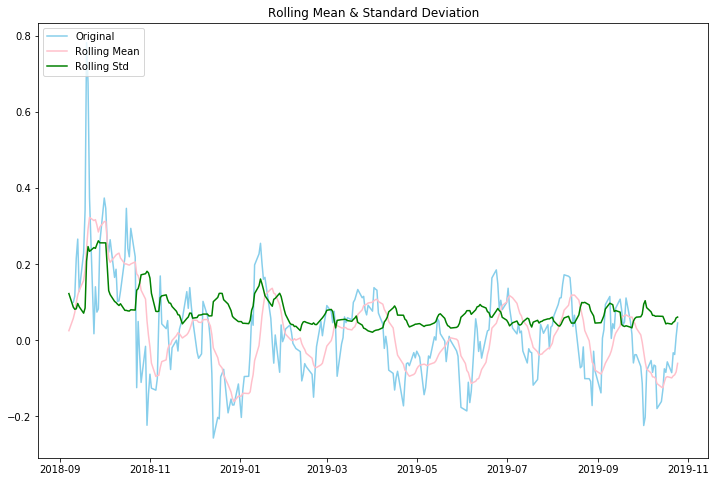

In [28]:
#decomposing tlry_open into trend, seasonal, and residual
decomposition = seasonal_decompose((np.log(tlry_open)), freq=52)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plotting statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(tlry_open), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

test_stationarity(ts_log_decompose, 10)

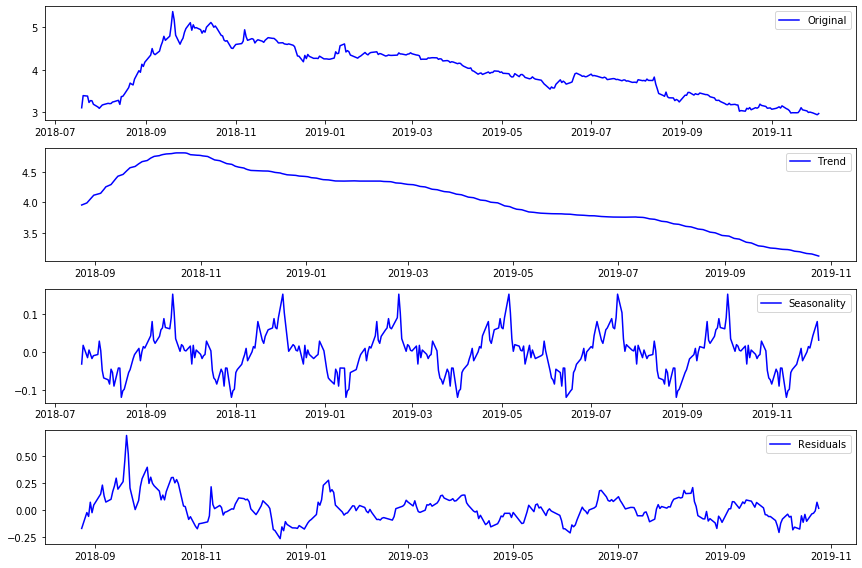

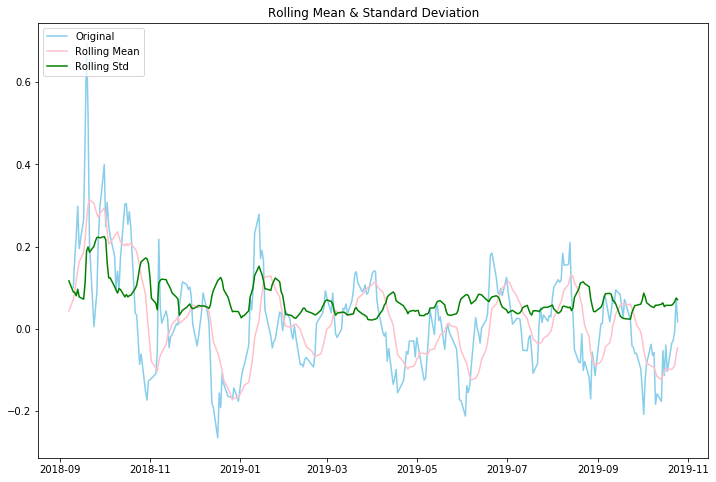

In [29]:
#decomposing tlry_close into trend, seasonal, and residual
decomposition = seasonal_decompose((np.log(tlry_close)), freq=52)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(tlry_close), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

test_stationarity(ts_log_decompose, 10)

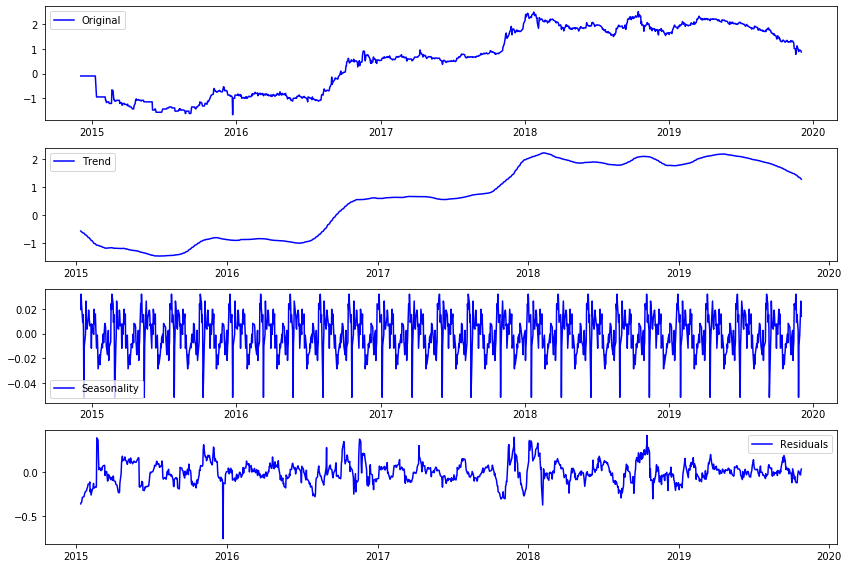

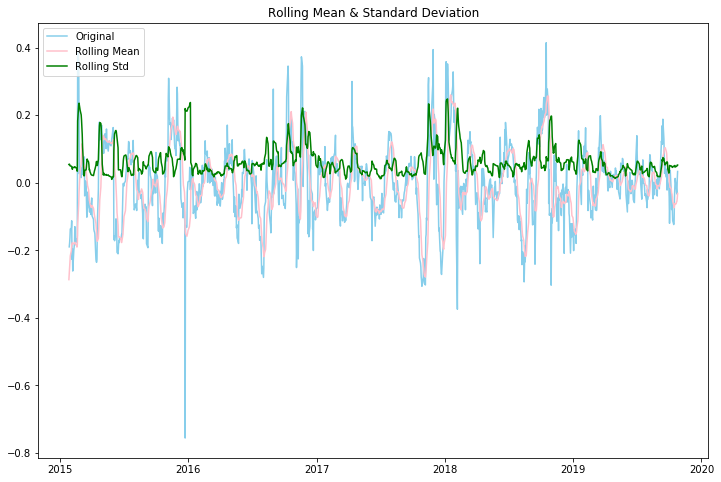

In [30]:
#decomposing acb_open into trend, seasonal, and residual
decomposition = seasonal_decompose((np.log(acb_open)), freq=52)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(acb_open), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

test_stationarity(ts_log_decompose, 10)

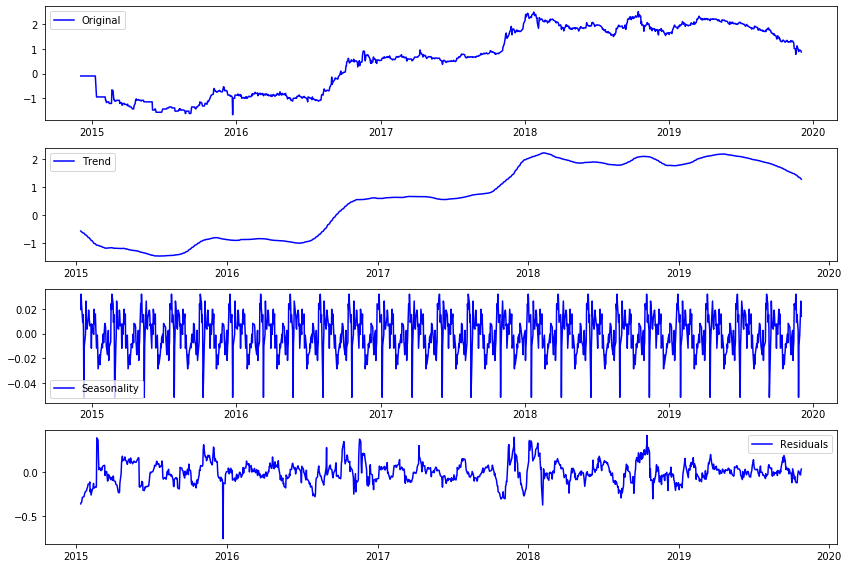

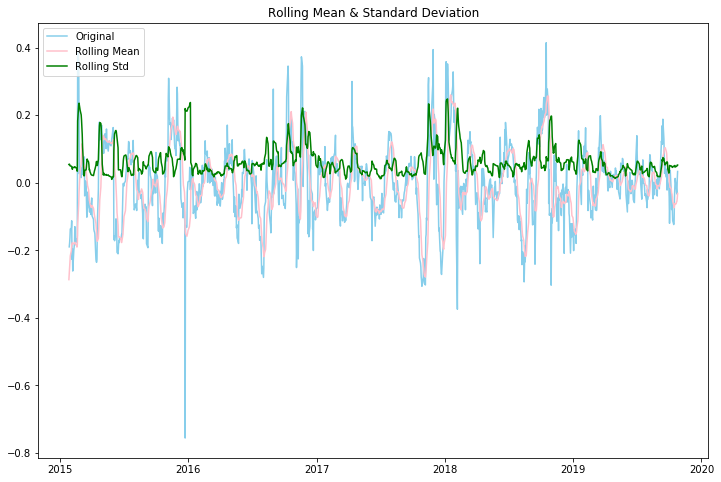

In [31]:
#decomposing acb_close into trend, seasonal, and residual
decomposition = seasonal_decompose((np.log(acb_close)), freq=52)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(acb_close), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

test_stationarity(ts_log_decompose, 10)

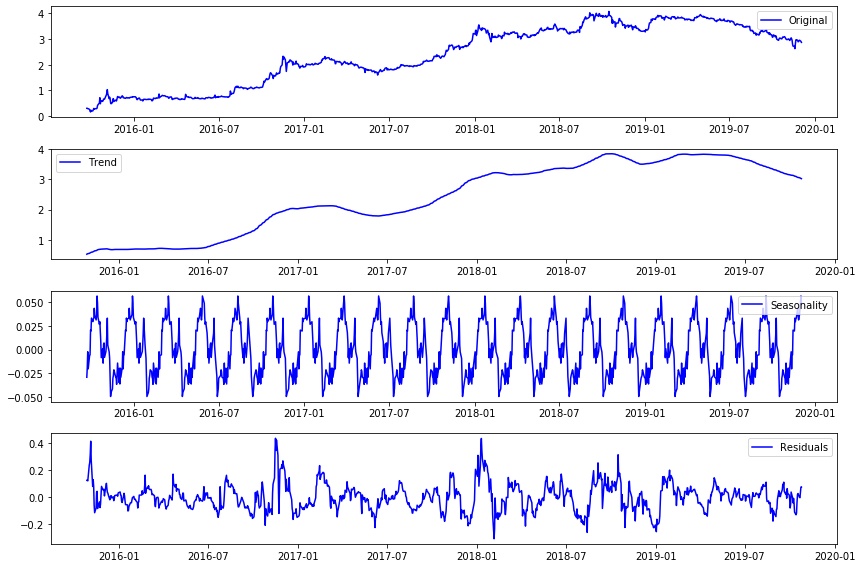

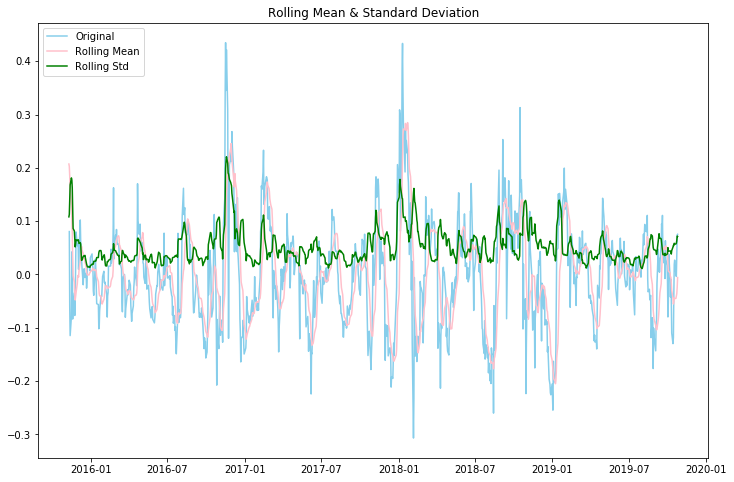

In [32]:
#decomposing cgc_open into trend, seasonal, and residual
decomposition = seasonal_decompose((np.log(cgc_open)), freq=52)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(cgc_open), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

test_stationarity(ts_log_decompose, 10)

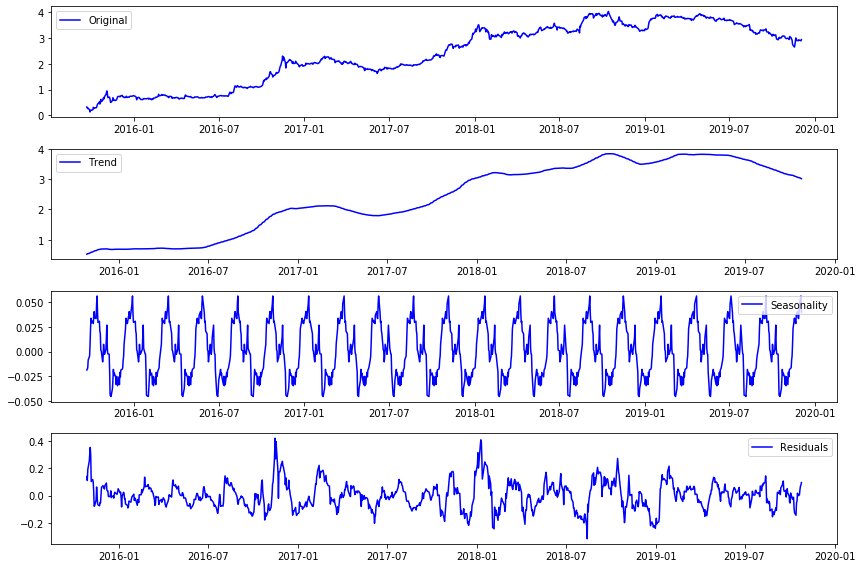

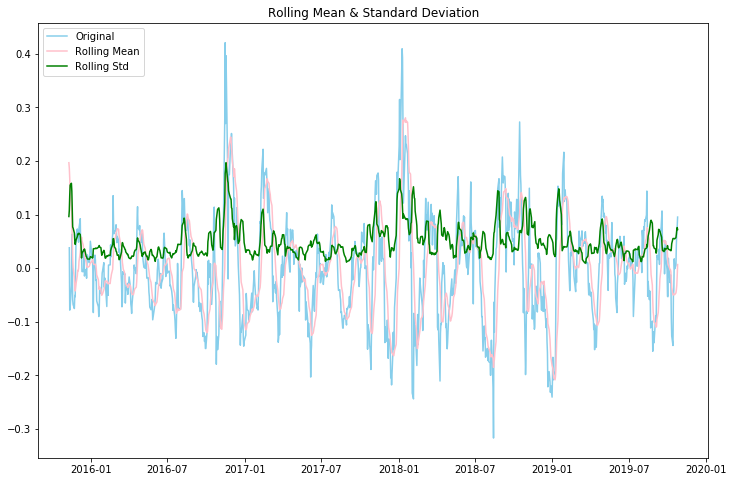

In [33]:
#decomposing cgc_close into trend, seasonal, and residual
decomposition = seasonal_decompose((np.log(cgc_close)), freq=52)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(cgc_close), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

test_stationarity(ts_log_decompose, 10)

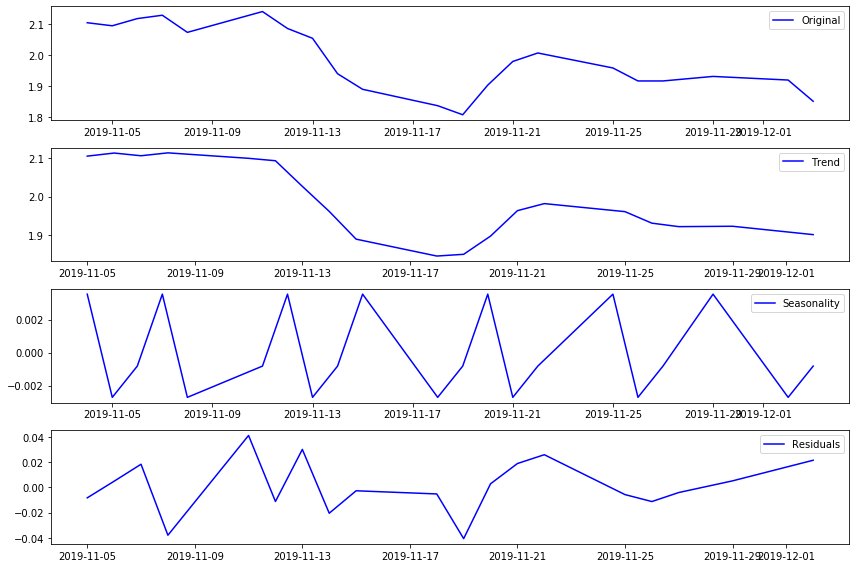

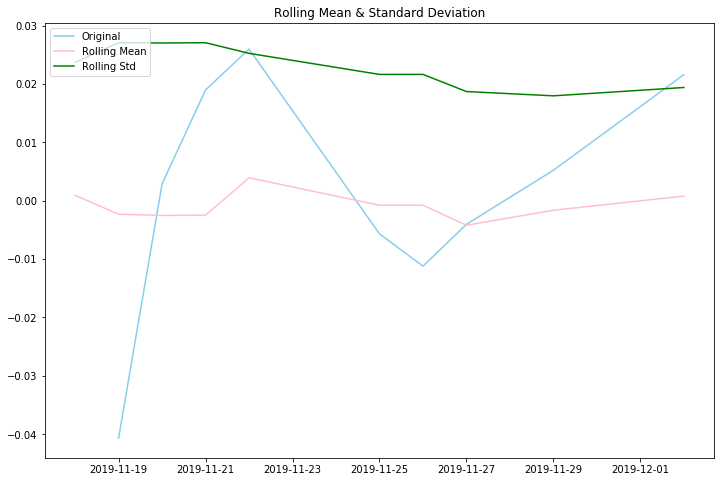

In [34]:
#decomposing cron_open into trend, seasonal, and residual
decomposition = seasonal_decompose((np.log(cron_open)), freq=3)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(cron_open), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

test_stationarity(ts_log_decompose, 10)

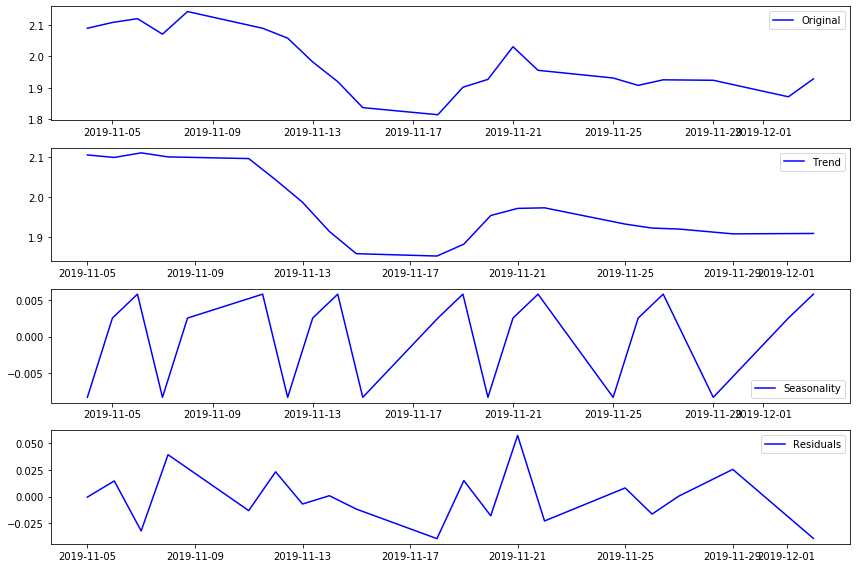

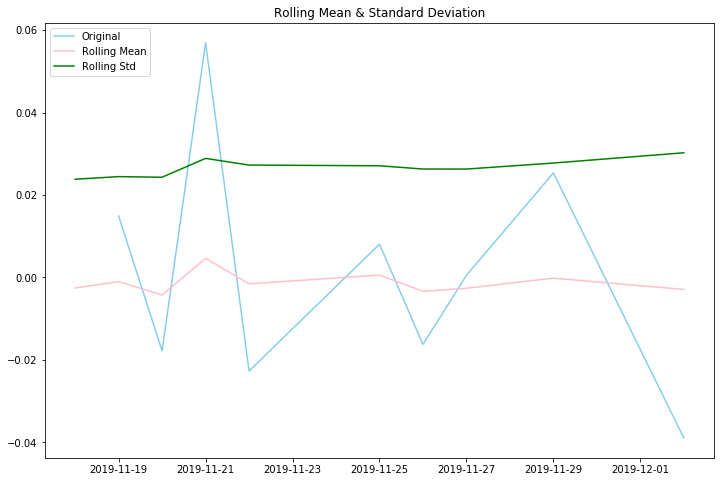

In [35]:
#decomposing cron_close into trend, seasonal, and residual
decomposition = seasonal_decompose((np.log(cron_close)), freq=3)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(cron_close), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

test_stationarity(ts_log_decompose, 10)

The data from Cronos Group (CRON) only goes back to November 2019, hence the sharp peaks and drops. It may not be worth including in the rest of our research as it does not add much information. We can also tell that while Aurora Cannabis (ACB) and Canopy Growth (CGC) show a positive growth trend, Tilray, Inc. shows a negative trend. 

### Autocorrelation

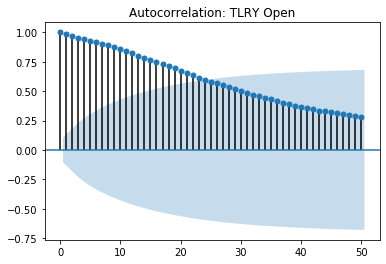

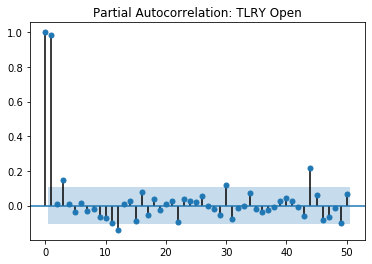

In [36]:
#testing tlry_open for autocorrelation/partial autocorrelation
title = 'Autocorrelation: TLRY Open'
lags = 50
plot_acf((np.log(tlry_open)),title=title,lags=lags);

title = 'Partial Autocorrelation: TLRY Open'
lags = 50
plot_pacf((np.log(tlry_open)),title=title,lags=lags);

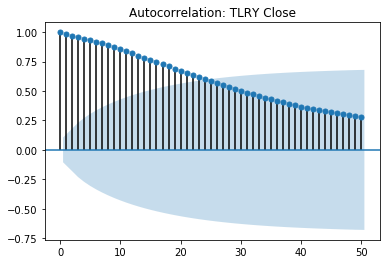

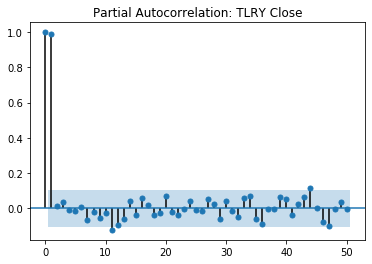

In [37]:
#testing tlry_close for autocorrelation/partial autocorrelation
title = 'Autocorrelation: TLRY Close'
lags = 50
plot_acf((np.log(tlry_close)),title=title,lags=lags);

title = 'Partial Autocorrelation: TLRY Close'
lags = 50
plot_pacf((np.log(tlry_close)),title=title,lags=lags);

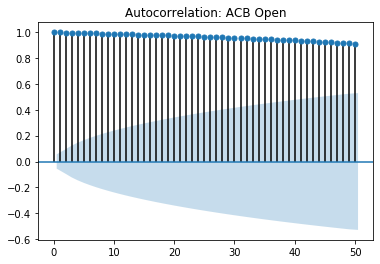

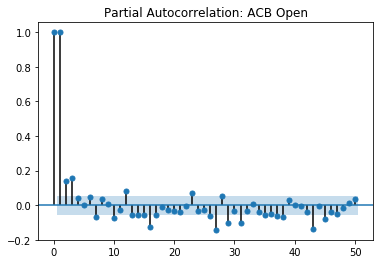

In [38]:
#testing acb_open for autocorrelation/partial autocorrelation
title = 'Autocorrelation: ACB Open'
lags = 50
plot_acf((np.log(acb_open)),title=title,lags=lags);

title = 'Partial Autocorrelation: ACB Open'
lags = 50
plot_pacf((np.log(acb_open)),title=title,lags=lags);

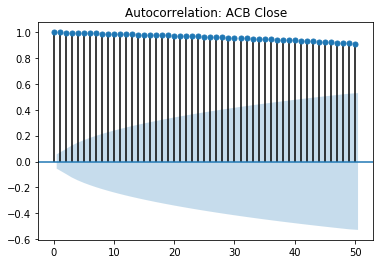

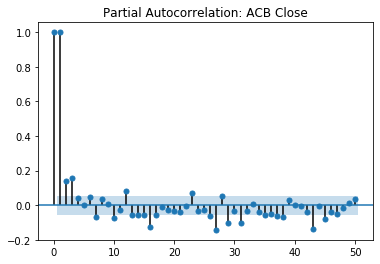

In [39]:
#testing acb_close for autocorrelation/partial autocorrelation
title = 'Autocorrelation: ACB Close'
lags = 50
plot_acf((np.log(acb_close)),title=title,lags=lags);

title = 'Partial Autocorrelation: ACB Close'
lags = 50
plot_pacf((np.log(acb_close)),title=title,lags=lags);

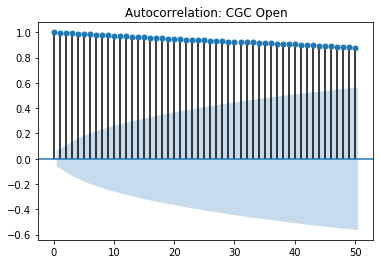

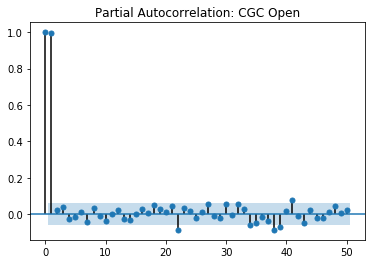

In [40]:
#testing cgc_open for autocorrelation/partial autocorrelation
title = 'Autocorrelation: CGC Open'
lags = 50
plot_acf((np.log(cgc_open)),title=title,lags=lags);

title = 'Partial Autocorrelation: CGC Open'
lags = 50
plot_pacf((np.log(cgc_open)),title=title,lags=lags);

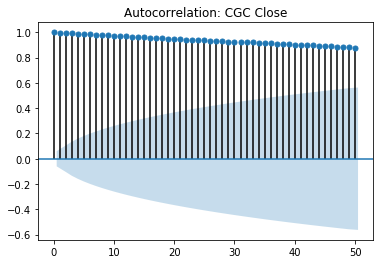

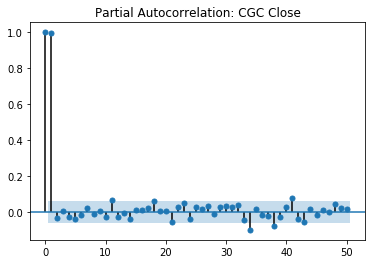

In [41]:
#testing cgc_close for autocorrelation/partial autocorrelation
title = 'Autocorrelation: CGC Close'
lags = 50
plot_acf((np.log(cgc_close)),title=title,lags=lags);

title = 'Partial Autocorrelation: CGC Close'
lags = 50
plot_pacf((np.log(cgc_close)),title=title,lags=lags);

While all three stocks shows very strong positive autocorrelation, indicating that previous stock prices are good indicators of current/future prices, TLRY's drop in correlation and eventual leveling implies that initial prices may have been too high.

### ARIMA Modeling

In [42]:
import itertools
#define the p, d and q parameters to take any value between 0 and 2
P = D = Q = range(0, 2)

#generate all different combinations of p, q and q triplets
PDQ = list(itertools.product(P, D, Q))

#generate all different combinations of seasonal p, q and q triplets
PDQs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]

In [43]:
# determining the ideal order for SARMIMAX modeling
ans = [] 
for comb in PDQ:
    for combs in PDQs:
        try:
            mod = sm.tsa.statespace.SARIMA((np.log(tlry_open)),
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [44]:
tlry_open.dtypes

dtype('float64')

In [45]:
ans_df = pd.DataFrame(ans, columns=['PDQ', 'PDQs', 'AIC'])
ans_df.loc[ans_df['AIC'].idxmin()]

TypeError: reduction operation 'argmin' not allowed for this dtype

In [46]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX((np.log(tlry_open)),
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output_to = ARIMA_MODEL.fit()

print(output_to.summary().tables[1])

/Users/shannonamcchesney/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4859      0.206     -2.360      0.018      -0.889      -0.082
ma.L1          0.5247      0.206      2.543      0.011       0.120       0.929
sigma2         0.0063      0.000     29.891      0.000       0.006       0.007


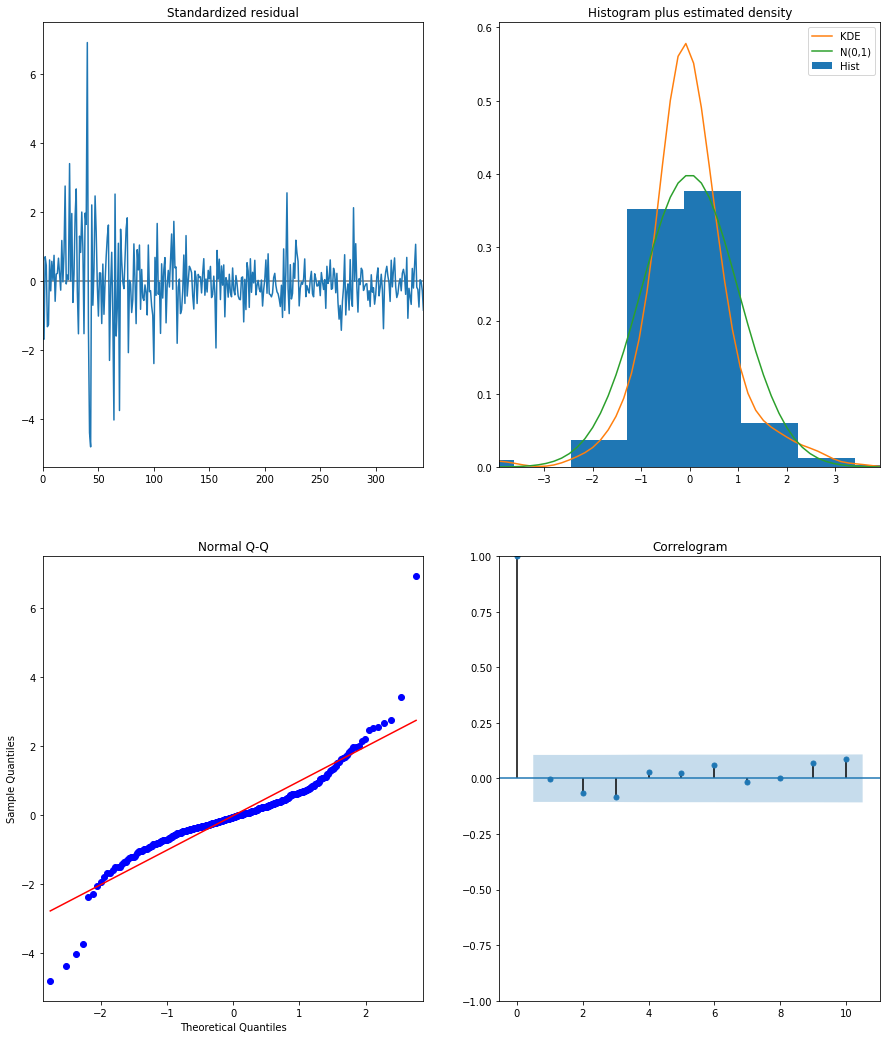

In [47]:
output_to.plot_diagnostics(figsize=(15, 18))
plt.show() #plotting results of ARIMA model

In [48]:
# determining the ideal order for SARMIMAX modeling
ans = []
for comb in PDQ:
    for combs in PDQs:
        try:
            mod = sm.tsa.statespace.SARIMA((np.log(tlry_close)),
                                            order=comb,
                                            seasonal_order=combs)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue


In [49]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX((np.log(tlry_close)),
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 12))

output_tc = ARIMA_MODEL.fit()

print(output_tc.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1469      0.330     -0.445      0.656      -0.794       0.500
ma.L1          0.2429      0.330      0.737      0.461      -0.403       0.889
sigma2         0.0051      0.000     20.550      0.000       0.005       0.006


/Users/shannonamcchesney/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


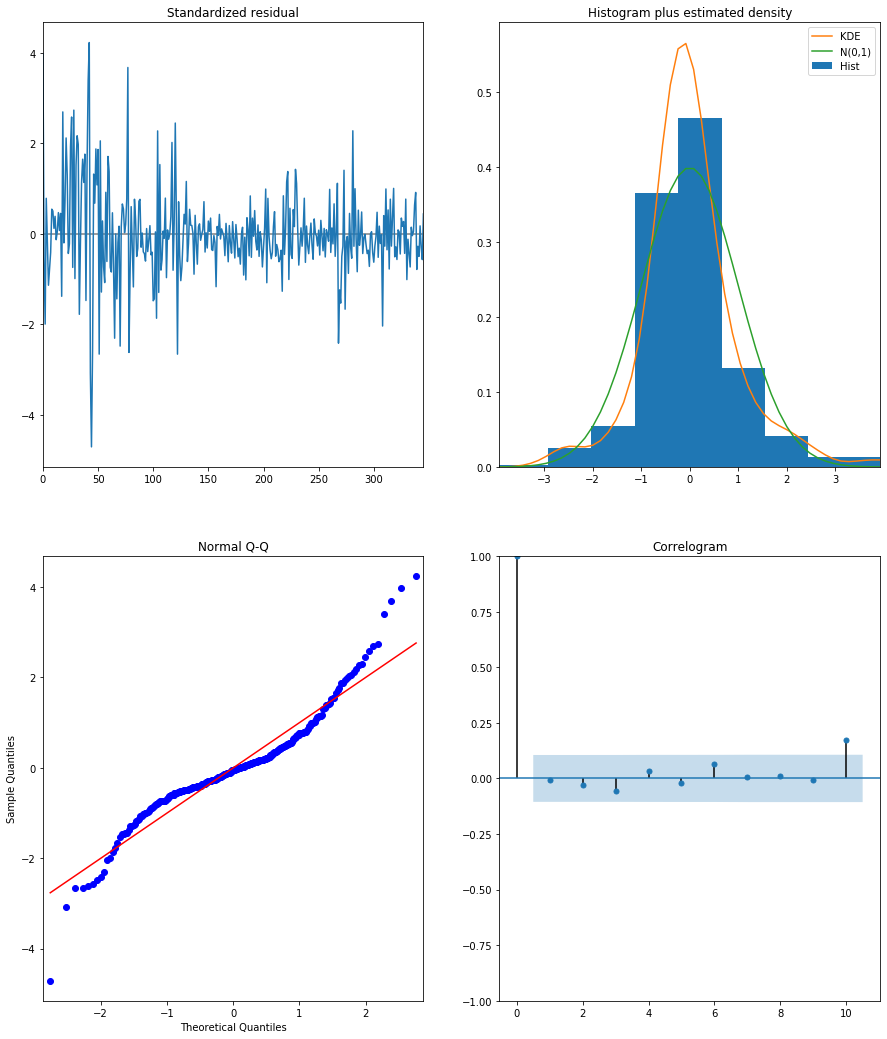

In [50]:
output_tc.plot_diagnostics(figsize=(15, 18))
plt.show()  #plotting results of ARIMA modeling

In [51]:
# determining the ideal order for SARMIMAX modeling
ans = []
for comb in PDQ:
    for combs in PDQs:
        try:
            mod = sm.tsa.statespace.SARIMA((np.log(acb_open)),
                                            order=comb,
                                            seasonal_order=combs)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [52]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX((np.log(acb_open)),
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 12))

output_ao = ARIMA_MODEL.fit()

print(output_ao.summary().tables[1])

/Users/shannonamcchesney/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4325      0.153      2.827      0.005       0.133       0.732
ma.L1         -0.5290      0.148     -3.566      0.000      -0.820      -0.238
sigma2         0.0049   4.91e-05    100.734      0.000       0.005       0.005


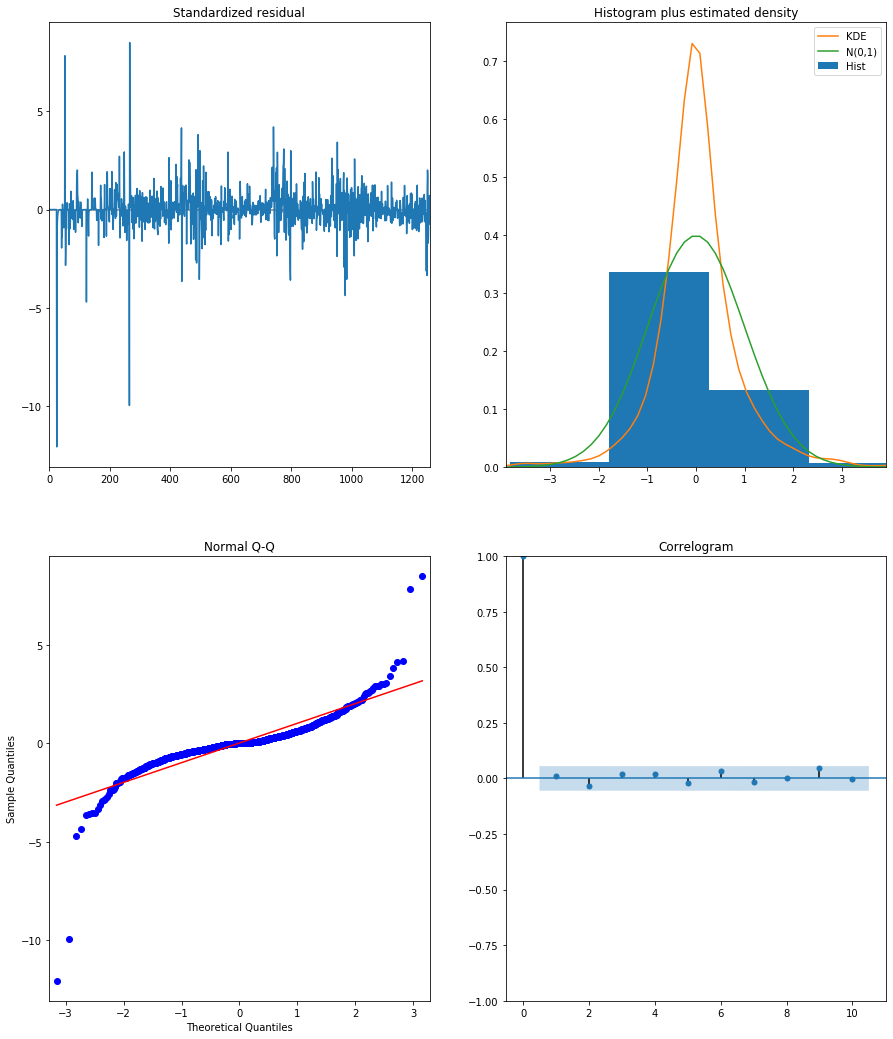

In [53]:
output_ao.plot_diagnostics(figsize=(15, 18))
plt.show() #plotting statistics from ARIMA modeling

In [54]:
# determining the ideal order for SARMIMAX modeling
ans = []
for comb in PDQ:
    for combs in PDQs:
        try:
            mod = sm.tsa.statespace.SARIMA((np.log(acb_close)),
                                            order=comb,
                                            seasonal_order=combs)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [55]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX((np.log(acb_close)),
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 12))

output_ac = ARIMA_MODEL.fit()

print(output_ac.summary().tables[1])

/Users/shannonamcchesney/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4325      0.153      2.827      0.005       0.133       0.732
ma.L1         -0.5290      0.148     -3.566      0.000      -0.820      -0.238
sigma2         0.0049   4.91e-05    100.734      0.000       0.005       0.005


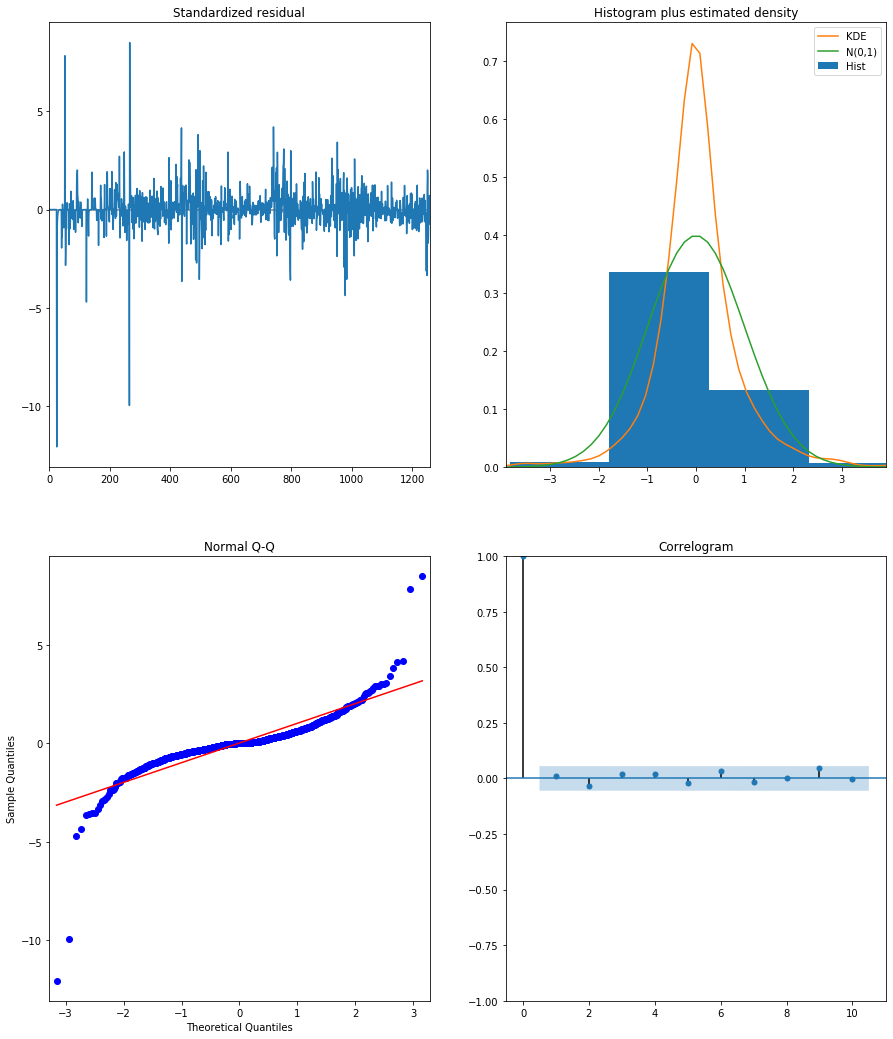

In [56]:
output_ac.plot_diagnostics(figsize=(15, 18))
plt.show() #plotting statistics from ARIMA modeling

In [57]:
# determining the ideal order for SARMIMAX modeling
ans = []
for comb in PDQ:
    for combs in PDQs:
        try:
            mod = sm.tsa.statespace.SARIMA((np.log(cgc_open)),
                                            order=comb,
                                            seasonal_order=combs)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [58]:
ans_df = pd.DataFrame(ans, columns=['PDQ', 'PDQs', 'AIC', 'BIC'])
ans_df.loc[ans_df['AIC'].idxmin()]

TypeError: reduction operation 'argmin' not allowed for this dtype

In [59]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX((np.log(cgc_open)),
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 12))

output_co = ARIMA_MODEL.fit()

print(output_co.summary().tables[1])

/Users/shannonamcchesney/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4618      0.197      2.345      0.019       0.076       0.848
ma.L1         -0.5255      0.189     -2.774      0.006      -0.897      -0.154
sigma2         0.0029    7.1e-05     40.881      0.000       0.003       0.003


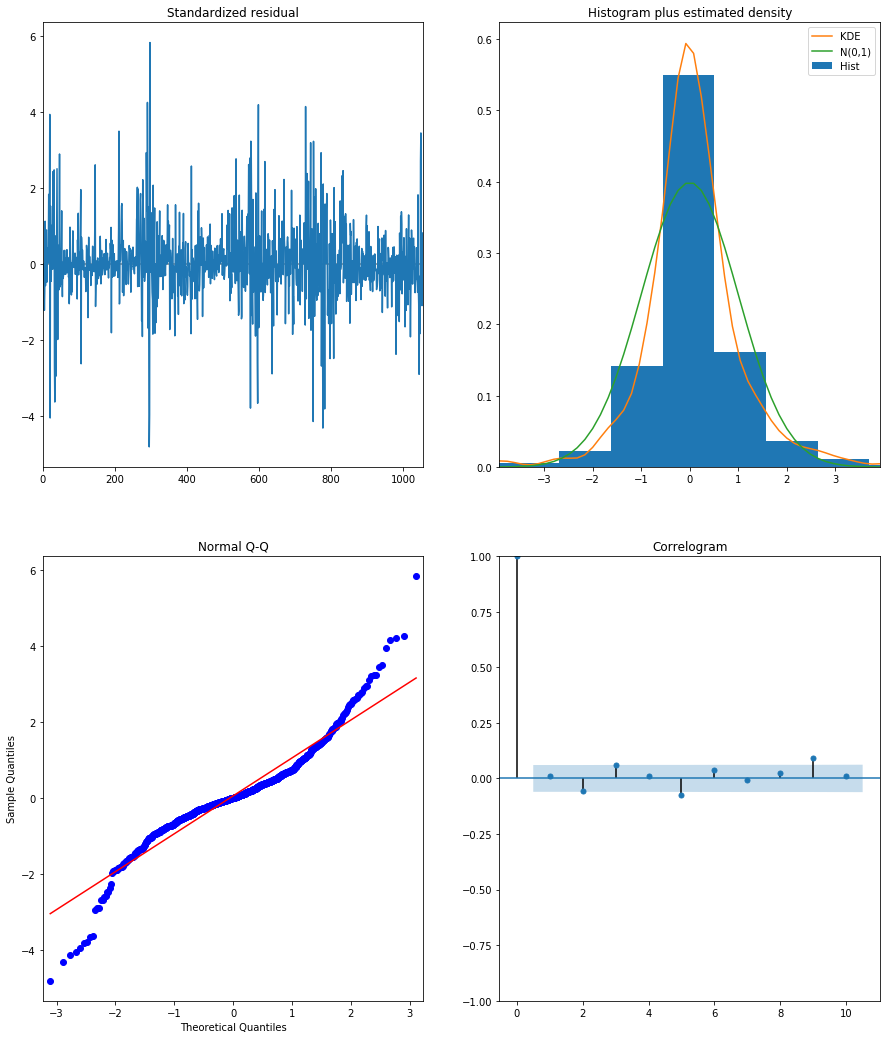

In [60]:
output_co.plot_diagnostics(figsize=(15, 18))
plt.show() #plotting statistics from ARIMA modeling

In [61]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX((np.log(cgc_close)),
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output_cc = ARIMA_MODEL.fit()

print(output_cc.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7466      0.171     -4.373      0.000      -1.081      -0.412
ma.L1          1.2725      0.262      4.852      0.000       0.758       1.786
sigma2         0.0013      0.001      2.420      0.016       0.000       0.002


/Users/shannonamcchesney/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


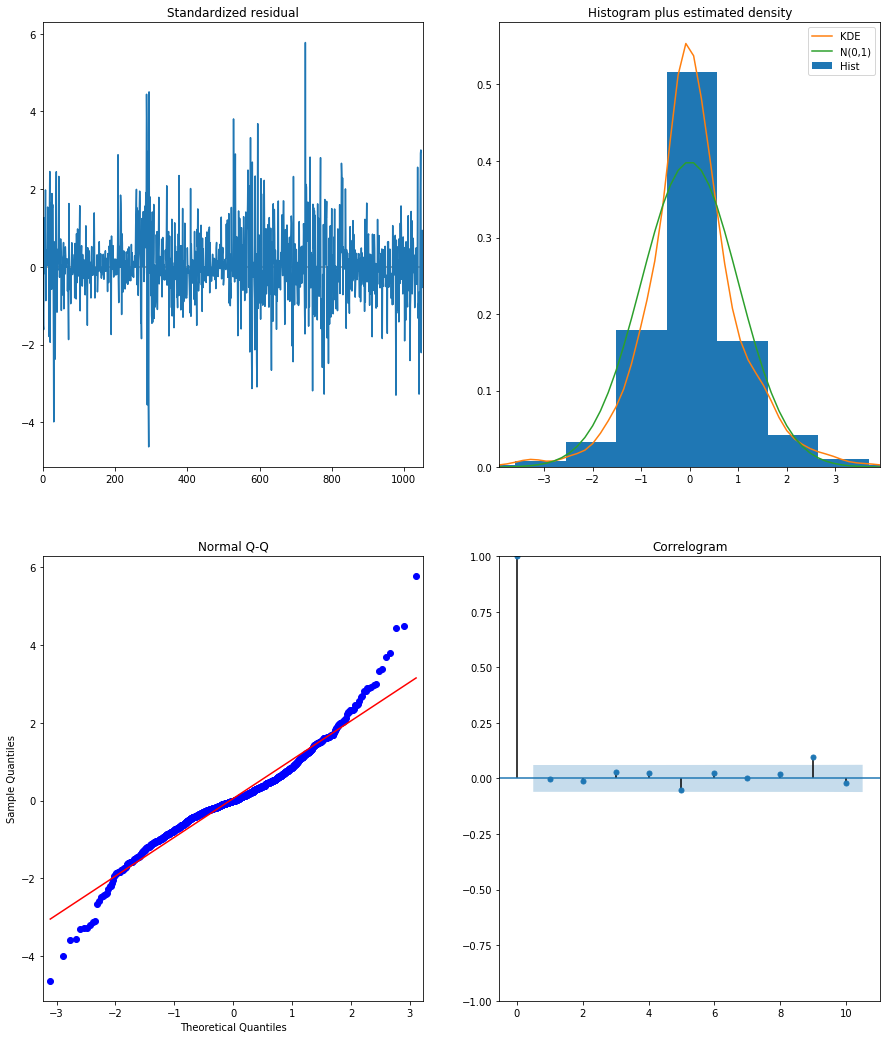

In [62]:
output_cc.plot_diagnostics(figsize=(15, 18))
plt.show() #plotting statistics from ARIMA modeling

While Aurora Cannabis (ACB) and Canopy Group Corporation(CGC) have good p-values, Tilray, Inc. (TLRY) does not. This is consistent with the other irregularities we've seen with TLRY in this project. This hints at the possibility of TLRY's price being more affected/manipulated by media hype. 

All three shows spikes in the Standard Residual Chart at similar points, but Canopy Group (CGC) shows a lot of spikes, indicating that there are external factors at play. Our NLTK/Word2Vec analysis below will help to determine if this is true or not.

## Step 4: Scraping Data From News Articles

In [63]:
# importing libraries/packages necessary for webscraping/classifier-building
from bs4 import BeautifulSoup
import nltk
from nltk.classify.scikitlearn import SklearnClassifier
import pickle
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC, NuSVC
from nltk.classify import ClassifierI
from statistics import mode
from nltk.tokenize import word_tokenize
import re

In [3]:
!pip install newsapi-python #ensuring News API is installed properly

In [4]:
from newsapi import NewsApiClient

# Init
newsapi = NewsApiClient(api_key='65a4ae9f8ab541aca327051f16f80077')

# /v2/top-headlines
top_headlines = newsapi.get_top_headlines(q='TLRY',
                                          category='business',
                                          language='en',
                                          country='us')

# /v2/everything
all_articles = newsapi.get_everything(q='TLRY',
                                      from_param='2018-07-01',
                                      to='2018-12-01',
                                      language='en',
                                      sort_by='relevancy',
                                      page=2)

NewsAPIException: {'status': 'error', 'code': 'parameterInvalid', 'message': 'You are trying to request results too far in the past. Your plan permits you to request articles as far back as 2019-12-22, but you have requested 2018-07-01. To extend this please upgrade to a paid plan.'}

Ideally, we'd like to use an API like the one above to make our web-scraping lives easier. However, because we want a date-range further back than one month (and our budget does not cover the cost of a subscription), we'll have to scrape the articles using 'requests' and BeautifulSoup. If you're doing a lot of article scraping and you have the budget to do so, it may be worth your time (and money) to use an API instead.

In [64]:
#individually scraping each news article
r_tlry1 = requests.get('https://www.forbes.com/sites/greatspeculations/2018/07/19/ipo-coverage-tilray-inc-tlry/#4c5031bc1554')
content = r_tlry1.text
soup = BeautifulSoup(content, "html.parser") #utilizing BeautifulSoup to parse content
tlry_1 = []
for i in range(0, 20): #range adjusted to include all relevant paragraphs
    paragraphs1 = soup.find_all('p')[i].text
    tlry_1.append(paragraphs1)
print(tlry_1)

['Head grower Mark Vlahos, of Milford, Mass., tends to cannabis plants, Thursday, July 12, 2018, at... [+] Sira Naturals medical marijuana cultivation facility, in Milford, Mass. The lack of any approved independent testing laboratories for recreational marijuana remains a key stumbling block to opening pot shops in Massachusetts. (AP Photo/Steven Senne)', 'Tilray Inc., Canadian marijuana producer and processor, will IPO on Thursday, June 19. At a price range of $14 to $16 per share, the company plans to raise up to $144 million and has an expected market cap of ~$1.4 billion. At the midpoint of its price range, TLRY currently earns an\xa0unattractive rating.', 'Tilray looks to capitalize on growing support for the legalization of marijuana usage. 30 states in the U.S. have some form of legal marijuana and Canada recently approved a bill to legalize recreational usage, which would make it the first Group of Seven nation to legalize cannabis. Is Tilray’s IPO coming at the perfect time, 

In [65]:
r_tlry2 = requests.get('https://www.cnbc.com/2018/07/18/tilray-joins-nasdaq-in-first-us-cannabis-ipo-.html')
content = r_tlry2.text
soup = BeautifulSoup(content, "html.parser")
tlry_2 = []
for i in range(0, 20):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_2.append(paragraphs1)
print(tlry_2)

['Keep Me Logged In', 'Amid a big year in markets for cannabis companies, Canadian medical marijuana company Tilray made its debut on the Nasdaq on Thursday — becoming the first pure-play marijuana company to go public on a major U.S. exchange.', 'And Tilray President and CEO Brendan Kennedy told CNBC that the buzz around cannabis is only going to continue to grow.', '"Eight years ago you would have seen 90 percent of the revenues in Colorado would have come from products that would be smoked," Kennedy said Thursday on "Power Lunch." "Today it’s about 40 percent. Long term, I think we’ll end up with smoking being about 10 percent [of cannabis consumption] and all the other products being 90 percent."', 'In fact, Kennedy envisions a world where consumers can order their cannabis "as a beverage in a bar."', '"Instead of alcohol, they’ll have cannabis," said Kennedy, who is also a member of Tilray\'s board of directors. "And they’ll have a low, or no-calorie product with no hangover."', '

In [66]:
r_tlry3 = requests.get('https://www.seattletimes.com/business/tilray-completes-ipo-begins-trading-on-nasdaq/')
content = r_tlry3.text
soup = BeautifulSoup(content, "html.parser")
tlry_3 = []
for i in range(0, 7):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_3.append(paragraphs1)
print(tlry_3)

['Shares will begin trading on the Nasdaq Thursday under the ticker symbol TLRY.', 'Canadian marijuana company Tilray, a subsidiary of Seattle-based Privateer Holdings, completed its initial public offering Wednesday of 9 million shares at a price of $17 apiece.', 'Shares will begin trading on the Nasdaq Thursday under the ticker symbol TLRY. Tilray’s offering, sold above the previously estimated range of $14-$16 a share, raised approximately $153 million before costs.', 'While other marijuana companies have obtained listings on U.S. stock exchanges, often through mergers, Tilray says it is the first to successfully complete an IPO.', 'With a research facility in Nanaimo, B.C., and cultivation and processing sites in Ontario and Portugal, Tilray supplies “tens of thousands of patients in 10 countries,” according to its prospectus. It also has exclusive Canadian rights to a list of recreational brands of cannabis products, including Privateer-owned Marley Natural and The Goodship.', 'Th

In [67]:
r_tlry4 = requests.get('https://markets.businessinsider.com/news/stocks/weed-stocks-aurora-cannabis-debuts-new-york-stock-exchange-2018-10-1027644264')
content = r_tlry4.text
soup = BeautifulSoup(content, "html.parser")
tlry_4 = []
for i in range(0, 5):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_4.append(paragraphs1)
print(tlry_4)

[' ', 'Weed stocks were under pressure Tuesday morning as one of the largest cannabis producers, Aurora Cannabis, debuted for trading on the New York Stock Exchange. Aurora shares fell as much as 12% at the open.\xa0\xa0', 'Tilray, Canopy Growth, and Cronos, who were already trading on US markets, were lower between 7% and 14% before paring their losses.\xa0Before Tuesday, Aurora was trading solely on the Toronto Stock Exchange.\xa0', 'Aurora, which grows cannabis for both the adult-use and medicinal market, has seen its market capitalization double since August — to just more that $10 billion — as both corporate giants and investors have gotten in on the "green rush" into marijuana.', 'That includes the recent sell-off that has taken hold ever since last week Wednesday, the day before marijuana was legalized in Canada. Aurora shares have plunged about 35% since putting in their record high that morning.\xa0\n\n\n']


In [68]:
r_tlry5 = requests.get('https://www.fool.com/investing/2018/10/02/4-reasons-tilray-could-easily-lose-half-its-value.aspx')
content = r_tlry5.text
soup = BeautifulSoup(content, "html.parser")
tlry_5 = []
for i in range(0, 20):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_5.append(paragraphs1)
print(tlry_5)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', "The green rush is nearly upon us. In just 15 days, on Oct. 17, the green flag will wave in Canada, marking the official start of recreational marijuana sales in licensed dispensaries. Despite being a long time coming, the legalization of adult-use weed in Canada should yield billions of dollars in added annual sales for the industry, once it's fully ramped up.", 'This large expected influx of demand, and the belief that pot stocks will be rolling in the dough, has sent marijuana stock valuations through the roof in recent months. But no marijuana stock has caught fire to the extent of Tilray (NASDAQ:TLRY), which has only been a publicly traded company for about two and a half months after pricing its shares at $17.', 'Image source: Getty Ima

In [69]:
r_tlry6 = requests.get('https://www.fool.com/earnings/call-transcripts/2018/11/13/tilray-inc-tlry-q3-2018-earnings-conference-call-t.aspx')
content = r_tlry6.text
soup = BeautifulSoup(content, "html.parser")
tlry_6 = []
for i in range(0, 20):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_6.append(paragraphs1)
print(tlry_6)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', 'Image source: The Motley Fool.', 'Tilray, Inc. (NASDAQ:TLRY)Q3 2018 Earnings Conference CallNovember 13, 2018, 4:30 p.m. ET', 'Operator', 'Good day, ladies and gentlemen and welcome to the Tilray third quarter 2018 earnings conference call. At this time, all participants are in a listen-only mode. Later, we will conduct a question and answer session and instructions will be given at that time. If anyone should require assistance during the conference, please press * then 0 on your touchstone telephone. As a reminder, this conference is being recorded.', "I would like now like to introduce your hosts for today's call, Miss Katie Turner. Miss Turner, you may begin.", 'Katie Turner -- Head of Investor Relations ', "Good afternoon and thank you 

In [70]:
r_tlry7 = requests.get('https://www.fool.com/investing/2018/09/30/the-best-performing-marijuana-stock-of-all-time-hi.aspx')
content = r_tlry7.text
soup = BeautifulSoup(content, "html.parser")
tlry_7 = []
for i in range(0, 23):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_7.append(paragraphs1)
print(tlry_7)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', "Sports fans like to argue about which basketball player is the greatest of all time -- the GOAT. Some like Michael Jordan. Others go with Lebron James. Perhaps a few throw out the names of other great basketball players of the past. But the arguments usually aren't settled, mainly because it comes down to personal opinion and which stats receive higher prioritization.", "However, no argument is needed when it comes to determining the best-performing marijuana stock of all time. There's a hands-down winner. and it's probably not who you think it is.", 'Image source: Getty Images.', "Let's first acknowledge several marijuana stocks that have performed really well, but not close enough to take the top spot.", 'You might have thought that Canopy

In [71]:
r_tlry8 = requests.get('https://www.nasdaq.com/articles/tilray-tlrys-valuation-may-look-crazy-it-2018-08-29')
content = r_tlry8.text
soup = BeautifulSoup(content, "html.parser")
tlry_8 = []
for i in range(0, 20):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_8.append(paragraphs1)
print(tlry_8)

['\n\n<!--/*--><![CDATA[/* ><!--*/\n\n<!--/*--><![CDATA[/* ><!--*/\n#block-survival-2 {\ndisplay: none;\n}\n@media only screen and (min-width: 48rem) {\n.symbol-page-header__pricing-changes {\ntext-align: right;\n}\n}\n@media only screen and (min-width: 75rem) {\n.page-node-type-symbol-screener .with-primary-nav .page__main {\npadding-top: 140px;\n}\n}\n@media only screen and (min-width: 90rem) {\n.symbol-page-header__eyebrow {\npadding: 0 45px;\n}\n}\n@media only screen and (min-width: 108.75rem) {\n.symbol-page-header__eyebrow {\npadding: 0 24px;\n}\n}\n\n.with-sub-nav .page__main {\npadding-top: 120px;\n}\n\n.ui-dialog.external-link-popup { z-index: 2147483647 !important}\n\n@media only screen and (min-width:1200px) and (max-width:1599px){.find-symbol--dark .find-symbol__form{padding:20px;min-height:140px}.find-symbol--dark .find-symbol__screener-link{top:-25px}}\n\n/*--><!]]]]><![CDATA[>*/\n\n/*--><!]]>*/\n', 'Yesterday, when the recently IPO’d cannabis company Tilray Inc. (TLRY) r

In [72]:
r_tlry9 = requests.get('https://www.fool.com/investing/2018/11/07/these-5-pot-stocks-are-now-listed-on-the-nyse-or-n.aspx')
content = r_tlry9.text
soup = BeautifulSoup(content, "html.parser")
tlry_9 = []
for i in range(0, 18):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_9.append(paragraphs1)
print(tlry_9)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', "The historic year for marijuana stocks marches on. While you're probably familiar with the biggest event of the year -- the legalization of recreational cannabis in Canada\xa0-- a lot more history has been made than just this occurrence.", 'For instance, Vermont became the first U.S. state to legalize adult-use marijuana entirely through the legislative process in January (i.e., without putting the measure to a vote of state residents). We also saw\xa0GW Pharmaceuticals becoming the first drug developer to get a cannabis-derived therapy approved by the U.S. Food and Drug Administration on June 25. This cannabidiol-based oral solution known as Epidiolex also received the lowest possible classification (Schedule V) for a controlled substance, 

In [73]:
r_tlry10 = requests.get('https://investorplace.com/2018/11/tlry-tilray-stock-skyrocket-management-right-message/')
content = r_tlry10.text
soup = BeautifulSoup(content, "html.parser")
tlry_10 = []
for i in range(0, 20):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_10.append(paragraphs1)
print(tlry_10)

['Please contact us with any questions or concerns regarding our products, your account and billing. ', 'Monday - Friday9 a.m. – 5 p.m. ET', '(800) 219-8592', 'feedback@investorplace.com', 'We bring you a diverse group of leaders in investment advice.\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\tSubscribe Now!\n', '\n\t\t\tCopyright © 2020 InvestorPlace Media, LLC. All rights reserved. 9201 Corporate Blvd, Rockville, MD 20850.\t\t', '9 Monster Microcaps for 2020', 'On February 5, Matt McCall will release his nine favorite high-growth-potential microcaps for rare 2,500% gains or more.', 'Source: Shutterstock', 'Very few, if any, market segments can compete with cannabis stocks for sheer magnitude of volatility. A prime example is Tilray (NASDAQ:TLRY). Having only enjoyed its initial public offering this July, TLRY stock has already obliterated all expectations.', 'At the same time, extreme bullishness often meets extreme bearishness. When compared to its all-time high, Tilray stock has mathematically

In [74]:
r_tlry11 = requests.get('https://www.fool.com/investing/2018/10/22/why-pot-stocks-canopy-growth-cronos-group-and-tilr.aspx')
content = r_tlry11.text
soup = BeautifulSoup(content, "html.parser")
tlry_11 = []
for i in range(0,9):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_11.append(paragraphs1)
print(tlry_11)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', "Canadian pot stocks are getting hit hard across the board today. As of 1:21 p.m. EDT, for example, shares of\xa0Canopy Growth\xa0Corporation\xa0(NYSE:CGC) and\xa0Cronos Group (NASDAQ:CRON) were both down by 11.2%, whereas Tilray's(NASDAQ:TLRY) stock had fallen by 14.4%. What's going on?", 'Canopy, Cronos, and Tilray all seem to be succumbing to a so-called "sell the news" event. On Oct. 17, Canada officially opened the floodgates to allow adults to use marijuana for recreational purposes. Since then, however, Canopy, Cronos, and Tilray have all seen their share prices fall in dramatic fashion.\xa0\xa0', 'Image Source: Getty Images.', "This widespread sell-off shouldn't be all that surprising to investors. Shares of these first three cannabis

In [75]:
r_tlry12 = requests.get('https://www.fxstreet.com/analysis/tlry-gives-new-meaning-to-high-201809201205')
content = r_tlry12.text
soup = BeautifulSoup(content, "html.parser")
tlry_12 = []
for i in range(0, 20):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_12.append(paragraphs1)
print(tlry_12)

['\n\n\n\n\nKenny Polcari\n\nKennyPolcari.com\n\n\n\n\nFollow\n\n\n\nFollowing\n\n\n', 'And the roll continues....stocks push towards new highs as investors continue to accentuate the positive and eliminate the negatives....focus on the US economy is the theme, Unemployment at historic lows, corp earnings at historic highs, while another move by the FED next week is not only welcomed, but expected and is being shopped around as a testament, a badge of honor of sorts, as to the strength of the economy.\xa0\n\xa0\nThe thought of emerging mkt weakness, or trade disputes, or unrest in the Middle East are nothing but a distant memory....as investors vote with their dollars, their Euro’s, Yen, Renminbi’s Peso’s, Kiwi’s, Rubles - whatever.... they are putting money to work and being rewarded handsomely for doing so.\n\xa0\nBut is it beginning to feel a lot like Champagne in some sectors of the mkt?\xa0\xa0\xa0 Maybe just a bit too bubbly?\xa0 Think POT stocks - yes - as the industry would lik

In [76]:
r_tlry13 = requests.get('https://www.fool.com/investing/2018/11/09/tilray-has-something-to-prove.aspx')
content = r_tlry13.text
soup = BeautifulSoup(content, "html.parser")
tlry_13 = []
for i in range(0, 20):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_13.append(paragraphs1)
print(tlry_13)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', 'Investors have jumped into the marijuana market aggressively, banking on the rising demand as more jurisdictions legalize cannabis to drive sales across the industry. Among the top stocks in the industry, Tilray (NASDAQ:TLRY) has gotten a lot of attention from its initial public offering on the Nasdaq Stock Market earlier this year and its subsequent surge amid excitement for the legalization of recreational marijuana in Canada.', "Tilray expects to release its third-quarter financial report on Nov. 13, and investors have high hopes that the newly public company can live up to all the hype. Yet rather than focusing too much on current results, you should concentrate on what Tilray says about its immediate future. The company will give some g

In [77]:
r_tlry14 = requests.get('https://www.marketwatch.com/story/tilray-ipo-five-things-to-know-about-the-first-pot-company-to-go-public-on-nasdaq-2018-07-10')
content = r_tlry14.text
soup = BeautifulSoup(content, "html.parser")
tlry_14 = []
for i in range(0, 28):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_14.append(paragraphs1)
print(tlry_14)

['Published: July 18, 2018 10:11 p.m. ET', 'Tilray sold the equivalent of 1,299 kilos of weed in the first quarter while growing in Canada and Europe', 'By', 'Tilray Inc. is boldly going where few marijuana growers dare—Wall Street. The Canada-based marijuana production and processor has officially become the first company in the once-clandestine sector to debut on Nasdaq Inc.’s \r\n\r\n                            \r\n                            \r\n                                  \r\n      \r\n      \r\n      \r\n      \r\n      \r\n      \r\n      \r\n                                  \r\n                                    NDAQ, +0.72%\r\n\r\n                            \r\n                                  \r\n      \r\n      \r\n      \r\n      \r\n      \r\n      \r\n      \r\n                                        \xa0Global Select Market exchange.', 'Tilray \r\n\r\n                            \r\n                            \r\n                                  \r\n      \r\

In [78]:
r_tlry15 = requests.get('https://simplywall.st/stocks/us/pharmaceuticals-biotech/nasdaq-tlry/tilray/news/how-much-of-tilray-inc-nasdaqtlry-do-institutions-own/')
content = r_tlry15.text
soup = BeautifulSoup(content, "html.parser")
tlry_15 = []
for i in range(0, 13):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_15.append(paragraphs1)
print(tlry_15)

['\n    If you want to know who really controls Tilray Inc (NASDAQ:TLRY), then you’ll have to look at the makeup of its share registry.\n\n    Insiders often own a large chunk of younger, smaller, companies while huge companies tend to have institutions as shareholders.\n\n    \n      We also tend to see lower insider ownership in companies that were previously publicly owned.\n\n    \n  ', '\n    \n      With a market capitalization of US$11b, Tilray is rather large. We’d expect to see institutional investors on the register. Companies of this size are usually well known to retail investors, too.\n\n    Taking a look at the our data on the ownership groups (below), it’s seems that\n\n      institutional investors have bought into the company.\n    \n    Let’s delve deeper into each type of owner, to discover more about TLRY.\n  ', '\n\n\n        Check out our latest analysis for Tilray\n      \n\n', '\n    Institutions typically measure themselves against a benchmark when reporting to

In [79]:
r_tlry16 = requests.get('https://finance.yahoo.com/news/3-smokin-hot-marijuana-stocks-171834556.html')
content = r_tlry16.text
soup = BeautifulSoup(content, "html.parser")
tlry_16 = []
for i in range(0, 20):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_16.append(paragraphs1)
print(tlry_16)

['Amid all the ruckus of 2018 an investing thesis has emerged that has taken Wall Street by storm: Marijuana stocks surged almost like bitcoin did in its heyday.', 'There was extreme exuberance stemming from the legalization of pot in Canada and marijuana stocks like Canopy Growth (NYSE:CGC) and Tilray (NASDAQ:TLRY) were rocket ships that seemed unstoppable. TLRY especially was a short stock nightmare as it became difficult to trade even through options. I was lucky enough to ride perfectly through long calls and short puts and it was still tough to fill my winning orders.', 'Now that the event has passed, the trade becomes more fundamental than gambling. And therein lies the opportunity.', 'InvestorPlace - Stock Market News, Stock Advice & Trading Tips', 'The concept is viable. Use of pot will increase because now, as the legalization trend propagates, millions more potential users will access it. Moreover, the applications will become more user-friendly. It’s a lot easier to justify 

In [80]:
r_tlry17 = requests.get('https://www.investopedia.com/news/6-marijuana-companies-make-90-short-interest-sector/')
content = r_tlry17.text
soup = BeautifulSoup(content, "html.parser")
tlry_17 = []
for i in range(0, 8):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_17.append(paragraphs1)
print(tlry_17)

['Short-sellers are beginning to make some serious money on bets that the biggest cannabis companies by market capitalization are overvalued.', 'Since Oct. 16, the day before Canada legalized recreational marijuana, cannabis stocks have been in freefall, with some of the most popular exchange-traded funds covering the sector, the ETFMG Alternative Harvest ETF (MJ), Horizons Marijuana Life Sciences ETF (HMMJ) and Evolve Marijuana ETF (SEED), each falling more than 20%.', 'Sector-wide losses made short-sellers $450 million in just the first two days of this week alone, financial analytics firm S3 Partners reported, helping bears to cut nearly a third off their year-to-date losses.\xa0', 'In a research note, S3 Partners revealed that the majority of short interest in the sector has been concentrated\xa0with only seven stocks having over $100 million in short interest each. Combined, shares of Canopy Growth Corp. (CGC),\xa0Aurora Cannabis Inc.\xa0(ACB),\xa0GW Pharma PLC (GWPH), Tilray Inc.

In [81]:
r_tlry18 = requests.get('https://www.fool.com/investing/2018/09/05/why-tilray-inc-is-setting-record-highs-again-today.aspx')
content = r_tlry18.text
soup = BeautifulSoup(content, "html.parser")
tlry_18 = []
for i in range(0, 13):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_18.append(paragraphs1)
print(tlry_18)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', 'Shares of Tilray, Inc. (NASDAQ:TLRY) were up 20.8% as of 3:15 p.m. on Wednesday, marking the second consecutive day this week of double-digit gains and setting another record high for the stock.', "Tilray didn't make any announcements that would cause its stock to rise, so what was behind the big move? You can probably chalk it up to continued buying by institutional investors. Trading volume for Tilray was more than three times heavier than average.", "When a stock steadily increases as Tilray has over the last few weeks with little or no news from the company itself, investors should delve into what's driving the optimism. For Tilray, there are three likely reasons behind the sustained upward trend.", 'Image source: Getty Images.', 'One is

In [82]:
r_tlry19 = requests.get('https://www.fool.com/investing/2018/08/19/better-marijuana-stock-cronos-group-vs-tilray.aspx')
content = r_tlry19.text
soup = BeautifulSoup(content, "html.parser")
tlry_19 = []
for i in range(0, 22):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_19.append(paragraphs1)
print(tlry_19)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', "You can count on one hand the number of Canadian marijuana stocks that trade on the Nasdaq\xa0stock exchange. And you'd have three fingers left over. Cronos Group (NASDAQ:CRON) became the first Canadian marijuana grower to list on the Nasdaq in February. Tilray (NASDAQ:TLRY) followed suit in July.", "Both Cronos Group and Tilray have tremendous growth prospects. But which marijuana stock is the better pick for investors? Here's how Cronos and Tilray stack up against each other.", 'Image source: Getty Images.', "Cronos Group's opportunities are, in order of size, the medical marijuana market in Canada, the recreational marijuana market in Canada, and the global medical marijuana market. Let's look at how Cronos is positioned in each of these 

In [83]:
r_tlry20 = requests.get('https://www.fool.com/investing/2018/09/27/marijuana-investors-dont-say-tilray-didnt-warn-you.aspx')
content = r_tlry20.text
soup = BeautifulSoup(content, "html.parser")
tlry_20 = []
for i in range(0, 18):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_20.append(paragraphs1)
print(tlry_20)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', "Investors across the globe are looking at marijuana stocks, and the resulting flood of investment capital has sent share prices soaring in the sector. Yet as Tilray's (NASDAQ:TLRY) recent experience shows, what goes up to ridiculous heights almost always has to come back down to earth. A lot of hard-hit investors who bought at the top and have seen the share price plunge subsequently feel like they've been unfairly burned.", "Yet the risks of marijuana stocks are clear. Even Tilray itself has identified key risk areas that shareholders simply have to take into consideration before buying shares. Below, we'll look at some of the most important risk factors that Tilray has identified for shareholders and what they say about the knowledge you n

In [84]:
r_tlry21 = requests.get('https://www.fool.com/investing/2018/11/16/why-tilrays-still-up-over-400-in-2018-to-date.aspx')
content = r_tlry21.text
soup = BeautifulSoup(content, "html.parser")
tlry_21 = []
for i in range(0, 26):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_21.append(paragraphs1)
print(tlry_21)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', 'When it comes to investing, timing is everything. For Tilray (NASDAQ:TLRY), the decision to do an initial public offering shortly after Canada started the countdown toward legalizing recreational marijuana was a masterstroke, feeding the hunger of U.S. investors to get access to the companies best positioned to profit from the Canadian move. Share prices predictably surged following the IPO, and Tilray continued to benefit from increased attention from cannabis investors.', "In the past couple of months, though, the ride for marijuana stocks has turned rougher, and that's left Tilray licking its wounds. Yet even though the stock is now well off its highs, Tilray investors are still enjoying huge gains so far in 2018 -- and many see a brighte

In [85]:
r_tlry22 = requests.get('https://www.fool.com/investing/2018/11/25/the-most-dangerous-big-marijuana-stock-on-the-mark.aspx')
content = r_tlry22.text
soup = BeautifulSoup(content, "html.parser")
tlry_22 = []
for i in range(0, 20):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_22.append(paragraphs1)
print(tlry_22)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', "It's no secret that investing in marijuana stocks comes with significant levels of risk. That's especially true for penny stocks linked to the cannabis industry. However, even the stocks of large marijuana companies with rapidly increasing sales and seemingly bright prospects can be riskier than that you might think.", "One big marijuana stock, in particular, appears to be more precariously positioned than any of its peers. Investing in this stock should be viewed as especially risky. What's the most dangerous big marijuana stock on the market? Tilray (NASDAQ:TLRY).", 'Image source: Getty Images.', 'Probably the most critical factor that makes Tilray more dangerous than other leading marijuana stocks is the looming\xa0initial public offering

In [86]:
r_tlry23 = requests.get('https://www.fool.com/investing/2018/11/07/why-tilray-crushed-it-today.aspx')
content = r_tlry23.text
soup = BeautifulSoup(content, "html.parser")
tlry_23 = []
for i in range(0, 13):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_23.append(paragraphs1)
print(tlry_23)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', "Shares of Tilray Inc. (NASDAQ:TLRY)\xa0had skyrocketed 29.6% higher as of 3:37 p.m. EST on Wednesday. The Canadian marijuana stock's big jump followed results from U.S. elections on Tuesday that were generally positive for the cannabis industry.", 'In particular, Michigan voters passed a measure legalizing recreational marijuana in the state. Missouri and Utah passed ballot initiatives to legalize medical marijuana. With Democrats gaining control of the U.S. House of Representatives, the chance of federal marijuana laws changing also appears more likely now.\xa0', 'Image source: Getty Images.', 'None of the U.S. election news affects Tilray immediately. So why the huge gain?', "With Tilray's low stock float of roughly 10 million shares and a

In [87]:
r_tlry24 = requests.get('https://www.fool.com/investing/2018/11/29/ignore-tilray-here-are-2-better-marijuana-stocks.aspx')
content = r_tlry24.text
soup = BeautifulSoup(content, "html.parser")
tlry_24 = []
for i in range(0, 17):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_24.append(paragraphs1)
print(tlry_24)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', "Tilray\xa0(NASDAQ:TLRY) made a lot of early investors rich this year, but now that it's a $10.6 billion company, further gains won't be so easy to come by. In fact, buying the stock at the moment is an extremely risky bet. Tilray investors need to worry about gaining a significant share of legal cannabis sales in Canada, and the market's extremely unpredictable. Legal Canadian cannabis sales could reach $5 billion next year, but oversupply issues and competition with the unregulated illicit market could make it hard for Tilray to turn a profit.", "The market for legal cannabis has a lot of room to grow, but Tilray probably isn't a good stock for anyone's portfolio right now. Instead, you might want to consider Innovative Industrial Propertie

In [88]:
r_tlry25 = requests.get('https://www.marketwatch.com/story/all-pot-stocks-arent-tilray-and-thats-a-good-thing-says-ceo-of-rival-canopy-growth-2018-09-22')
content = r_tlry25.text
soup = BeautifulSoup(content, "html.parser")
tlry_25 = []
for i in range(0, 20):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_25.append(paragraphs1)
print(tlry_25)

['Published: Sept 22, 2018 12:04 p.m. ET', 'Tilray’s wild trading this week shouldn’t be considered typical of the marijuana stock sector, insists Bruce Linton', 'By', 'Investors shouldn’t let pot stock Tilray Inc.’s \r\n\r\n                            \r\n                            \r\n                                  \r\n      \r\n      \r\n      \r\n      \r\n      \r\n      \r\n      \r\n                                  \r\n                                    TLRY, -7.65%\r\n\r\n                            \r\n                                  \r\n      \r\n      \r\n      \r\n      \r\n      \r\n      \r\n      \r\n                                         wild trading week turn them off from the marijuana sector, rival cannabis concern Canopy Growth Corp.\r\n\r\n                            \r\n                            \r\n                                  \r\n      \r\n      \r\n      \r\n      \r\n      \r\n      \r\n      \r\n                                  \r\n         

In [89]:
r_tlry26 = requests.get('https://www.marketwatch.com/story/why-tilray-stock-is-susceptible-to-wild-price-swings-2018-09-19')
content = r_tlry26.text
soup = BeautifulSoup(content, "html.parser")
tlry_26 = []
for i in range(0, 19):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_26.append(paragraphs1)
print(tlry_26)

['Published: Sept 20, 2018 6:55 a.m. ET', 'Marijuana producer’s stock was halted five times in less than an hour Wednesday, after rising more than 400% in a month', 'By', 'Cannabis producer Tilray Inc. experienced one of the wildest trading sessions in recent memory Wednesday, with trading halted five times in a roller-coaster end to the session, but the end result — a 38% gain— has become somewhat normal for a stock that is more susceptible than others to wild price swings.', 'Tilray \r\n\r\n                            \r\n                            \r\n                                  \r\n      \r\n      \r\n      \r\n      \r\n      \r\n      \r\n      \r\n                                  \r\n                                    TLRY, -7.65%\r\n\r\n                            \r\n                                  \r\n      \r\n      \r\n      \r\n      \r\n      \r\n      \r\n      \r\n                                        \xa0stock’s outsize volatility and meteoric gains from i

In [90]:
r_tlry27 = requests.get('https://www.fool.com/investing/2018/10/14/the-worst-mistake-tilray-investors-can-make-right.aspx')
content = r_tlry27.text
soup = BeautifulSoup(content, "html.parser")
tlry_27 = []
for i in range(0, 20):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_27.append(paragraphs1)
print(tlry_27)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', "Let's face it. There are lots of mistakes that you can make with investing. It's a lot easier to do something wrong than to do it right.\xa0", "Tilray (NASDAQ:TLRY) investors have certainly seen plenty of opportunities to mess up lately, especially with the stock experiencing huge swings both up and down on a frequent basis. But there's one mistake that Tilray investors can make right now that's the worst of all: believing the hype surrounding the stock.", 'Image source: Getty Images.', 'AC/DC had it right when they sang, "It\'s a long way to the top if you wanna rock and roll." It\'s also a long way to the top if you want the world\'s premier cannabis business. At least it should be.', "When Tilray conducted its initial public offering (IPO

In [91]:
r_tlry28 = requests.get('https://investorplace.com/2018/09/the-tilray-bubble-has-popped-and-tlry-stock-still-has-further-to-fall/')
content = r_tlry28.text
soup = BeautifulSoup(content, "html.parser")
tlry_28 = []
for i in range(0, 29):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_28.append(paragraphs1)
print(tlry_28)

['Please contact us with any questions or concerns regarding our products, your account and billing. ', 'Monday - Friday9 a.m. – 5 p.m. ET', '(800) 219-8592', 'feedback@investorplace.com', 'We bring you a diverse group of leaders in investment advice.\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\tSubscribe Now!\n', '\n\t\t\tCopyright © 2020 InvestorPlace Media, LLC. All rights reserved. 9201 Corporate Blvd, Rockville, MD 20850.\t\t', '9 Monster Microcaps for 2020', 'On February 5, Matt McCall will release his nine favorite high-growth-potential microcaps for rare 2,500% gains or more.', 'Source: Shutterstock', 'Since going public at $17 per share at the end of July, shares of Canadian cannabis producer Tilray (NASDAQ:TLRY) had gone so far, so fast that TLRY stock had bubble written all over it. That is why I, and many others, warned that as Tilray stock surpassed a $20 billion valuation (a 14-fold increase from its IPO valuation in just two months), the rally had become nonsensical. At those levels, 

In [92]:
r_tlry29 = requests.get('https://www.marketwatch.com/story/all-pot-stocks-arent-tilray-and-thats-a-good-thing-says-ceo-of-rival-canopy-growth-2018-09-22')
content = r_tlry29.text
soup = BeautifulSoup(content, "html.parser")
tlry_29 = []
for i in range(0, 20):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_29.append(paragraphs1)
print(tlry_29)

['Published: Sept 22, 2018 12:04 p.m. ET', 'Tilray’s wild trading this week shouldn’t be considered typical of the marijuana stock sector, insists Bruce Linton', 'By', 'Investors shouldn’t let pot stock Tilray Inc.’s \r\n\r\n                            \r\n                            \r\n                                  \r\n      \r\n      \r\n      \r\n      \r\n      \r\n      \r\n      \r\n                                  \r\n                                    TLRY, -7.70%\r\n\r\n                            \r\n                                  \r\n      \r\n      \r\n      \r\n      \r\n      \r\n      \r\n      \r\n                                         wild trading week turn them off from the marijuana sector, rival cannabis concern Canopy Growth Corp.\r\n\r\n                            \r\n                            \r\n                                  \r\n      \r\n      \r\n      \r\n      \r\n      \r\n      \r\n      \r\n                                  \r\n         

In [93]:
r_tlry30 = requests.get('https://www.fool.com/investing/2018/09/23/better-marijuana-stock-tilray-inc-vs-hexo-corp.aspx')
content = r_tlry30.text
soup = BeautifulSoup(content, "html.parser")
tlry_30 = []
for i in range(0, 20):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_30.append(paragraphs1)
print(tlry_30)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', 'Canadian marijuana grower HEXO Corp. (NYSE:HEXO), formerly known as Hydropothecary, has enjoyed a really good year so far in 2018. Its stock is up more than 60%. HEXO also landed a key deal with a big company outside of the cannabis industry.', 'But "really good" doesn\'t begin to describe the year for Tilray, Inc. (NASDAQ:TLRY). The stock skyrocketed 850% since its initial public offering (IPO) in July before giving up some of those gains. Tilray is still up more than seven times its IPO price.\xa0', 'Which of these two marijuana\xa0stocks is the better buy now? Here are the strongest arguments for both Tilray and HEXO.\xa0', 'Image source: Getty Images.', "Let's first address the elephant in the room about Tilray: The stock is still ridicu

In [94]:
r_tlry31 = requests.get('https://finance.yahoo.com/news/tilray-inc-tlry-stock-sinks-214509099.html')
content = r_tlry31.text
soup = BeautifulSoup(content, "html.parser")
tlry_31 = []
for i in range(0, 9):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_31.append(paragraphs1)
print(tlry_31)

["Tilray, Inc. (TLRY) closed at $90.41 in the latest trading session, marking a -0.3% move from the prior day. This move lagged the S&P 500's daily gain of 1.29%. At the same time, the Dow added 1.55%, and the tech-heavy Nasdaq gained 1.27%.", 'Investors will be hoping for strength from TLRY as it approaches its next earnings release, which is expected to be November 27, 2018.', "Investors might also notice recent changes to analyst estimates for TLRY. These revisions typically reflect the latest short-term business trends, which can change frequently. With this in mind, we can consider positive estimate revisions a sign of optimism about the company's business outlook.", 'Research indicates that these estimate revisions are directly correlated with near-term share price momentum. We developed the Zacks Rank to capitalize on this phenomenon. Our system takes these estimate changes into account and delivers a clear, actionable rating model.', 'Ranging from #1 (Strong Buy) to #5 (Strong 

In [95]:
r_tlry32 = requests.get('https://finance.yahoo.com/news/u-s-markets-open-higher-weed-stocks-surge-133655588.html?guccounter=1&guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbS8&guce_referrer_sig=AQAAAL6fBG-wT05pwI4teG6aN8NTnx-_f4XsT5a6ySsRC0BYRab6CsIh8N2yu4RqdJZ9G3bLMQnZqHHOQdDspzSpZlsP5cdWJ9XpDFhc5Mb1PRZlAkuzTI84MWhAMuprnZqb0PxrmIEUAO6l4AfadvDQNpPslSGoygAZlVqmNyNmHqqK')
content = r_tlry32.text
soup = BeautifulSoup(content, "html.parser")
tlry_32 = []
for i in range(0, 12):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_32.append(paragraphs1)
print(tlry_32)

['US markets were mixed at the close Wednesday in the wake of trade uncertainty between the U.S. and some of its major foreign counterparts. Meanwhile, cannabis stocks ballooned, posting gains\xa0at rates echoing the cryptocurrencies craze of last year.\xa0', 'The Dow Jones Industrial Average (^DJI) closed up 0.6%, to 26,405.76, lifted largely by bank shares. The S&P 500 (^GSPC) was up 0.1%, while\xa0the NASDAQ Composite (^IXIC) closed down 0.1% to 7,950.', 'Canada’s Minister of Foreign Affairs Chrystia Freeland spoke Wednesday in Washington with U.S. Trade Representative Robert Lighthizer\xa0in talks to try and reach a U.S.-Canada deal for the North American Free Trade Agreement. Canada’s dairy industry has been at the center of the debate, with the Trump administration signaling a refusal to reach an agreement unless the country eases up on its high dairy tariffs.', 'A preliminary deal between the U.S. and Mexico last month left Canada out of the bloc, and Steve Scalise, a key House 

In [96]:
r_tlry33 = requests.get('https://www.fool.com/investing/2018/10/01/why-new-age-beverages-euronet-worldwide-and-tilray.aspx')
content = r_tlry33.text
soup = BeautifulSoup(content, "html.parser")
tlry_33 = []
for i in range(6, 7):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_33.append(paragraphs1)
print(tlry_33)

["Finally, shares of Tilray gained 15%. The Canadian cannabis manufacturer said that its High Park Farms subsidiary had gotten a license from health regulator Health Canada to sell recreational cannabis, a key approval in advance of the opening of the Canadian market in just over two weeks. There's still a lot of controversy surrounding whether Tilray's big gains since its IPO just a few months ago are warranted, especially given the stock's limited number of outstanding shares and the appetite among investors for any investment related to marijuana. However, after plunging by two-thirds from its all-time highs in the span of just a few days, Tilray has quietly jumped by more than 60% in just over a week's time."]


In [97]:
r_tlry34 = requests.get('https://markets.businessinsider.com/news/stocks/weed-stocks-aurora-canopy-tilray-cronos-are-getting-clobbered-2018-8-1027490911')
content = r_tlry34.text
soup = BeautifulSoup(content, "html.parser")
tlry_34 = []
for i in range(0,8):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_34.append(paragraphs1)
print(tlry_34)

['Thomson Reuters', "\n\nMarijuana producers saw a major sell-off on Tuesday.\nA slew of investments by beverage companies spurred a rally across sector in recent months.\xa0\nTilray, one of the largest marijuana stocks, is set to report earnings after the closing bell Tuesday.\n\n\nAfter a week of massive gains, shares of the three largest publicly traded marijuana companies saw a massive sell-off Tuesday, down between 5% and 9%, as Tilray plans to release its first-ever earnings report.\nHere's how they stand:\n\nCanopy Growth: -10.8%\nTilray: - 4.6%\nCronos Group: -11.9%\nAurora Cannabis: -10.4%\n\nThe\xa0Horizons Emerging Marijuana Growers Index ETF, which tracks other smaller producers in Canada, fell about 5%.\xa0\n\n\n\nTilray, the second largest publicly traded cannabis company by market cap has surged 138% since its initial public offering in July. Analysts polled by Bloomberg are expecting the British Columbia-based company to report an adjusted second quarter loss of $0.85 a

In [98]:
r_tlry35 = requests.get('https://www.fool.com/investing/2018/09/09/the-marijuana-stock-that-wall-street-likes-the-mos.aspx')
content = r_tlry35.text
soup = BeautifulSoup(content, "html.parser")
tlry_35 = []
for i in range(0, 18):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_35.append(paragraphs1)
print(tlry_35)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', "Marijuana stocks\xa0haven't felt much love in the past from Wall Street. There's one really good reason why. Until this year, there was only one marijuana stock trading on a U.S. stock exchange -- Scotts Miracle-Gro (NYSE:SMG). And Scotts' primary business is selling lawn and garden products, so its designation as a marijuana stock comes with an asterisk.", 'Now, however, three pure-play marijuana stocks are listed on U.S. stock exchanges\xa0in addition to Scotts Miracle-Gro.\xa0Canopy Growth Corporation (NYSE:CGC) trades on the New York Stock Exchange (NYSE), while Cronos Group (NASDAQ:CRON) and Tilray\xa0(NASDAQ:TLRY) trade on the Nasdaq. But which marijuana stock does Wall Street like the most?', 'Image source: Getty Images.', "One way to

In [99]:
r_tlry36 = requests.get('https://www.marketwatch.com/press-release/tlry-and-nmtc-two-takes-on-treating-brain-disorders-that-could-be-worth-billions-2018-11-27')
content = r_tlry36.text
soup = BeautifulSoup(content, "html.parser")
tlry_36 = []
for i in range(0, 13):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_36.append(paragraphs1)
print(tlry_36)

['Published: Nov 27, 2018 7:30 a.m. ET', "November 27, 2018 (ACCESSWIRE via COMTEX) -- Two emerging approaches to treating neurological conditions are getting traction across the investment world: medical marijuana and neurostimulation. Both are addressing conditions like pain, movement disorders, seizures and many other problems with the nervous system. Both will be big winners, and many of the smartest investors are long BOTH. One neurostimulation company called NeuroOne Medical Technologies (NMTC) has yet to get much investor attention even though the company is using technology out of The Mayo Clinic, and the institute is a 10% shareholder of the company's public stock. NMTC has put together a rock star advisory board around using their electrodes in bioelectronics and artificial intelligence applications. They're planning to file their first product for FDA approval in early 2019, and they have a number of additional neurostimulation devices in the pipeline. 2019 is likely full of

In [100]:
r_tlry37 = requests.get('https://www.fool.com/investing/2018/10/05/why-tilray-stock-soared-120-in-september-and-how-i.aspx')
content = r_tlry37.text
soup = BeautifulSoup(content, "html.parser")
tlry_37 = []
for i in range(0, 15):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_37.append(paragraphs1)
print(tlry_37)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', 'Tilray (NASDAQ:TLRY) stock\xa0rocketed 120% in September,\xa0according to data from S&P Global Market Intelligence.', 'Bringing investors up to date, shares of the Canadian marijuana grower have tacked on 2.2% so far in October through Friday the 5th, when they closed at $146.91 per share. This brings their total gain since the company went public at $17 per share on July 19 to a whopping 764%.\xa0 ', 'Image source: Getty Images.', "We can attribute Tilray's powerful September performance to several catalysts. First, Tilray is benefiting from a tailwind that's boosting the entire cannabis space: Recreational pot will become legal for adults in Canada on Oct. 17.\xa0", 'Second, Tilray stock has been getting a lift from the belief among some m

In [101]:
r_tlry38 = requests.get('https://www.fool.com/investing/2018/07/29/better-marijuana-stock-canopy-growth-corporation-v.aspx')
content = r_tlry38.text
soup = BeautifulSoup(content, "html.parser")
tlry_38 = []
for i in range(0, 15):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_38.append(paragraphs1)
print(tlry_38)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', 'Only three Canadian marijuana stocks trade on the major U.S. stock exchanges. One of them claims the largest market cap of any marijuana stock -- Canopy Growth Corporation (NYSE:CGC). Another is the newest marijuana stock\xa0 -- Tilray, Inc. (NASDAQ:TLRY).', 'Canopy Growth got off to a great start in 2018, ranking as one of the best-performing marijuana stocks of the first half of the year\xa0before fading somewhat recently. Tilray enjoyed a fantastic initial public offering, although the stock has given up some of its early gains. But which of these two stocks is the better pick for investors now?\xa0', 'Image source: Getty Images.', "I think the arguments for buying Canopy Growth stock should be separated into short term and long term. The

In [102]:
r_tlry39 = requests.get('https://www.fool.com/investing/2018/10/07/3-reasons-you-should-stay-away-from-marijuana-etfs.aspx')
content = r_tlry39.text
soup = BeautifulSoup(content, "html.parser")
tlry_39 = []
for i in range(0, 17):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_39.append(paragraphs1)
print(tlry_39)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', 'There are plenty of reasons to love exchange-traded funds (ETFs). ETFs give investors a convenient way to buy lots of stocks in one swoop. They provide more diversification than individual stocks, which can lower risk and volatility. But not every ETF deserves a whole lot of love.', "I'm especially leery of the two marijuana ETFs on the market right now -- Horizons Marijuana Life Sciences ETF (NASDAQOTH: HMLSF) and ETFMG Alternative Harvest ETF (NYSEMKT:MJ). My view is that investors wanting to profit from growth in the cannabis industry are better off staying away from these ETFs. Here are three reasons why.", 'Image source: Getty Images.', "The fees associated with ETFs are typically a lot lower than those of mutual funds. However, the two

In [103]:
r_tlry40 = requests.get('https://www.fool.com/investing/2018/09/18/is-now-a-good-time-to-buy-tilray-inc.aspx')
content = r_tlry40.text
soup = BeautifulSoup(content, "html.parser")
tlry_40 = []
for i in range(0, 18):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_40.append(paragraphs1)
print(tlry_40)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', "Momentum is building for marijuana stocks ahead of the opening of Canada's recreational cannabis market in October, and Tilray Inc. (NASDAQ:TLRY) is among the industry's biggest recent winners. Tilray's shares have almost doubled this month because of growing optimism that it will be the next marijuana stock to strike a deal with a major consumer products company. Can this stock continue to climb?", 'Tilray has four facilities with a combined 912,000 square feet of space that can be used to grow cannabis, extract chemical cannabinoids found in marijuana, and package cannabinoids for sale as medicine and as consumer products.', 'Image source: Getty Images.', 'Unlike some marijuana growers, Tilray is less interested in profiting from pot itsel

In [104]:
r_tlry41 = requests.get('https://www.fool.com/investing/2018/08/09/why-canopy-growth-corporations-shares-fell-101-in.aspx')
content = r_tlry41.text
soup = BeautifulSoup(content, "html.parser")
tlry_41 = []
for i in range(0,6):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_41.append(paragraphs1)
print(tlry_41)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', 'Shares of Canopy Growth Corporation (NYSE:CGC) fell 10.1% in July, according to data provided by S&P Global Market Intelligence, after the company got a little more competition in the pot industry.\xa0', "Canopy Growth stock\xa0sold off ahead of the IPO of Tilray, Inc. (NASDAQ:TLRY) another Canadian cannabis supplier with growth aspirations. Tilray being public doesn't necessarily change Canopy Growth's earnings prospects, but it adds to the places investors can put their cannabis investment dollars.\xa0", 'Image source: Getty Images.', "I don't think it's a coincidence that the low point of the month for Canopy Growth was the day after Tilray's IPO. There was a rotation of investors out of Canopy Growth and into Tilray, which had the short-

In [105]:
r_tlry42 = requests.get('https://www.fool.com/investing/2018/09/30/forget-tilray-heres-a-marijuana-stock-youll-probab.aspx')
content = r_tlry42.text
soup = BeautifulSoup(content, "html.parser")
tlry_42 = []
for i in range(0, 20):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_42.append(paragraphs1)
print(tlry_42)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', "You can't get away from Tilray (NASDAQ:TLRY). The Canadian marijuana stock makes news when it goes up, which has happened a whole lot over the last couple of months. And it makes news when it goes down. Tilray has done a good bit of that, too, over the past few days, at one point losing over half of its market cap.", "But despite all the hype about Tilray, it's not the best marijuana stock on the market. One that has flown under the radar this year could quietly generate tremendous returns over the next few years. Forget Tilray -- here's why you'll probably like Liberty Health Sciences (OTC:LHSIF) a lot more.", 'Image source: Getty Images.', "First of all, Liberty Health Sciences has a couple of things in common with Tilray. Both companies a

In [106]:
r_tlry43 = requests.get('https://www.fool.com/investing/2018/10/12/why-tilray-is-jumping-today.aspx')
content = r_tlry43.text
soup = BeautifulSoup(content, "html.parser")
tlry_43 = []
for i in range(0, 16):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_43.append(paragraphs1)
print(tlry_43)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', "Shares of Tilray, Inc. (NASDAQ:TLRY) were up 11.8% as of 3:43 p.m. EDT on Friday. Tilray didn't report any new developments of its own. However, there were three potential factors behind the stock's nice gains.", "First of all, investors are eagerly awaiting the opening of Canada's recreational marijuana market on Oct. 17. This anticipation could be driving major Canadian marijuana stocks higher to some extent. Second, the United Kingdom is on track to legalize medical cannabis effective Nov. 1, 2018 -- potentially good news for Tilray.\xa0", "We're also likely seeing a continued pattern of volatility with Tilray. The stock has experienced multiple double-digit percentage\xa0swings, both up and down, over the last several weeks on little or 

In [107]:
r_tlry44 = requests.get('https://www.fool.com/investing/2018/09/04/why-tilray-inc-shares-soared-today.aspx')
content = r_tlry44.text
soup = BeautifulSoup(content, "html.parser")
tlry_44 = []
for i in range(0, 10):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_44.append(paragraphs1)
print(tlry_44)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', "Shares of Tilray, Inc. (NASDAQ:TLRY) were up 17.1% as of 11:38 a.m. EDT on Tuesday. There wasn't any news from the Canadian marijuana grower. So what caused Tilray stock to jump higher? The most likely answer is simply that investors continued to jump into major Canadian marijuana stocks ahead of the opening of the recreational marijuana market in Canada in October and in anticipation that Tilray could be selected as a partner by a major company outside the cannabis industry.", "Tilray wasn't the only big Canadian marijuana grower to enjoy solid gains in early trading today. Shares of Cronos Group (NASDAQ:CRON) and Canopy Growth (NYSE:CGC) were up nicely as well. Like Tilray, both Cronos and Canopy should enjoy tremendous growth after the Ca

In [108]:
r_tlry45 = requests.get('https://www.fool.com/investing/2018/11/11/better-marijuana-stock-tilray-vs-marimed.aspx')
content = r_tlry45.text
soup = BeautifulSoup(content, "html.parser")
tlry_45 = []
for i in range(0, 17):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_45.append(paragraphs1)
print(tlry_45)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', 'Investors interested in marijuana stocks are breathing sighs of relief that October is over. Most marijuana stocks took a beating during the month. The biggest marijuana stock winner so far this year, Tilray (NASDAQ:TLRY), saw its share price plunge 34% during October. Not every marijuana stock suffered, though. MariMed (OTC:MRMD), for example, gained nearly 19% -- the second best performance among marijuana stocks in the month.', "But October is in the past. Which of these two marijuana stocks is the better pick for the future? Here's what you need to know about the prospects for Tilray and MariMed.", 'Image source: Getty Images.', "Tilray's opportunities start right at home in Canada. The cannabis producer has already carved out a solid po

In [109]:
r_tlry46 = requests.get('https://www.fool.com/investing/2018/09/21/why-high-flying-tilray-is-crashing-again-today.aspx')
content = r_tlry46.text
soup = BeautifulSoup(content, "html.parser")
tlry_46 = []
for i in range(0, 10):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_46.append(paragraphs1)
print(tlry_46)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', "Turn out the lights, the party's over. That might seem to be the sentiment as Tilray, Inc. (NASDAQ:TLRY) crashed for the second consecutive day. Shares of Tilray were down 27.1% as of 11:06 a.m. EDT Friday. As was the case on Thursday, today's nosedive didn't stem from any announcements made by the Canadian marijuana grower. Instead, it looks like a short squeeze that propelled Tilray stock to dizzying heights has now abruptly ended.", 'Tilray has\xa0served as a textbook example of a short squeeze over the last few weeks. The company has a low stock float with only around 17.8 million shares available for trading. It has a high level of short interest. And Tilray has benefited from several positive developments recently, including the compan

In [110]:
r_tlry47 = requests.get('https://investorplace.com/2018/09/5-top-stock-trades-for-thursday-jd-amd-aapl-tlry-hd/')
content = r_tlry47.text
soup = BeautifulSoup(content, "html.parser")
tlry_47 = []
for i in range(17, 22):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_47.append(paragraphs1)
print(tlry_47)

['Admittedly, we took our long position off far too early in hindsight, but we still got to feast on AMD stock.', 'The stock has an unsustainable RSI (blue circle). However, AMD’s current rally has had a tendency to move up, consolidate (blue rectangles) and rally again. Let’s see how it consolidates going forward.', '', 'Like AMD stock, Apple (NASDAQ:AAPL) also has a high RSI. This morning, the reading stood at 86, a rather high number for a $1 trillion market cap company. The RSI isn’t our only consideration, but it is one input in the equation. Long-term investors probably won’t consider taking profits and that’s just fine.', 'But we can probably buy this one, reasonably, on a pullback down to $220. Keep in mind its 50-day moving average is all the way down at $201. We have been a big-time bull on Apple stock, but this move has been too much, too fast. Plus, there’s no telling what it will do ahead of its iPhone event on Sept. 12. It feels like it has already rallied ahead. Maybe no

In [111]:
r_tlry48 = requests.get('https://www.fool.com/investing/2018/10/04/2-pot-stocks-that-are-better-buys-than-tilray-inc.aspx')
content = r_tlry48.text
soup = BeautifulSoup(content, "html.parser")
tlry_48 = []
for i in range(0, 15):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_48.append(paragraphs1)
print(tlry_48)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', "Canada's Tilray (NASDAQ:TLRY) has now surpassed Canopy Growth Corporation (NYSE:CGC) as the largest marijuana company in the world by market capitalization. The bizarre part is that Tilray's production capacity pales in comparison to Canopy's at present. As a result, Wall Street has Canopy's 2019 sales coming in at over $130 million higher than Tilray's under current projections. Tilray's stock, therefore, could be seriously overvalued, implying that cannabis investors might want to look for greener pastures moving forward.", 'With this theme in mind, I think marijuana investors might want to check out both MariMed (OTC:MRMD) and\xa0The Green Organic Dutchman Holdings Ltd. (OTC:TGODF) right now. While neither is an out-and-out bargain in the

In [112]:
r_tlry49 = requests.get('https://www.cnbc.com/2018/11/07/tilray-ceo-on-michigan-missouri-weed-legalization-tlry-stock-price.html')
content = r_tlry49.text
soup = BeautifulSoup(content, "html.parser")
tlry_49 = []
for i in range(0, 10):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_49.append(paragraphs1)
print(tlry_49)

['Keep Me Logged In', 'The midterm election results are a win for the marijuana industry, according to the CEO of a prominent cannabis company.', "Utah and Missouri approved the use of cannabis for medical purposes on Tuesday, according to projections. While Michigan gave the green light to the recreational use of marijuana, having allowed its use for medical purposes before. North Dakota rejected proposals to allow recreational use of marijuana on Tuesday but it's still allowed for medical purposes.", '"It is definitely (a win). Last night we saw one state legalize for adult use and two for medical (purposes), which brings us to 33 medical states and 10 adult use states," Tilray Chief Executive Brendan Kennedy told CNBC Wednesday morning.', '"We\'re now at a point where 93 percent of Americans believe that medical cannabis should be legal, 65 percent believe that cannabis should be legal for adult use," Kennedy told CNBC\'s Karen Tso.', 'Tilray, a Canadian pharmaceutical and cannabis 

In [113]:
r_tlry50 = requests.get('https://markets.businessinsider.com/news/stocks/weed-stocks-tilray-stock-price-jeff-sessions-resigns-attorney-general-2018-11-1027703643')
content = r_tlry50.text
soup = BeautifulSoup(content, "html.parser")
tlry_50 = []
for i in range(0, 12):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_50.append(paragraphs1)
print(tlry_50)

['Markets Insider', '\n\nAttorney General Jeff Sessions, a longtime opponent of legal marijuana, resigned Wednesday as attorney general.\nThe cannabis producer Tilray was up 30% following the news.\nIn the 2018 midterm elections on Tuesday, voters in Michigan passed a measure to make the state the 10th to legalize recreational marijuana.\xa0\nWatch Tilray trade live.\n\nThe cannabis producer Tilray exploded higher Wednesday, up as much as 30%,\xa0after\xa0Attorney General Jeff Sessions, a longtime opponent of legal marijuana, resigned as after months of speculation about his future. Shares had already been up about 15% for the day.\n"At your request, I am submitting my resignation," Sessions said in his resignation letter, adding that it came at the request of President Donald Trump.\nSessions resignation could be good news for the federal legalization of marijuana, depending on who Trump picks as his replacement. \n\n\n\nIn January, Sessions rescinded an Obama-era policy directing the

In [114]:
r_tlry51 = requests.get('https://markets.businessinsider.com/news/stocks/weed-stocks-tilray-subsidiary-gets-sales-license-health-canada-2018-10-1027579140')
content = r_tlry51.text
soup = BeautifulSoup(content, "html.parser")
tlry_51 = []
for i in range(0, 7):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_51.append(paragraphs1)
print(tlry_51)

['Tilray', '\n\nTilray subsidiary High Park Farms announced Monday that it has received a cannabis sales license from Health Canada.\xa0\nTilray shares are up almost 18% on the news.\nWatch Tilray trade in real time here.\n\nThe Canadian cannabis producer Tilray is rallying Monday morning, up almost 18%, after its\xa0High Park Farms subsidiary received a sales license from Health Canada.\xa0\nThe license will allow\xa0High Park Farms to "supply and sell finished cannabis products within the ACMPR as well as sales in anticipation of the launch of the adult-use market in Canada upon its legalization on October 17, 2018," the press release\xa0said.\xa0\nMonday\'s surge is the latest in a series of wild swings for Tilray shares — which have gained 750% since their July initial public offering — and the marijuana space in general. Companies in the sector have seen media appearances and press releases add billions of dollars to their market capitalization.\xa0\n\n\n\nIn the middle of Septemb

In [115]:
r_tlry52 = requests.get('https://markets.businessinsider.com/news/stocks/weed-stocks-under-pressure-on-eve-of-canada-legalization-marijuana-cannabis-2018-10-1027622426')
content = r_tlry52.text
soup = BeautifulSoup(content, "html.parser")
tlry_52 = []
for i in range(0, 8):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_52.append(paragraphs1)
print(tlry_52)

['REUTERS/Patrick Doyle', '\n\nCannabis stocks were frothy Tuesday — one day ahead of Canada\'s full legalization.\xa0\nAfter previously setting record highs, Canopy Growth and Aurora Cannabis had fallen into the red alongside the entire sector.\n\nCanada will become the first developed country to legalize recreational cannabis on Wednesday, but with mere hours left before the first sales are legal, many of the largest marijuana stocks were seeing red.\nCanopy Growth, Aurora Cannabis, and Tilray — collectively the three largest producers by market cap — had all fallen into the red by midday Tuesday, hours after Canopy and Aurora\xa0soared to record highs.\nHere\'s the scoreboard:\n\n\n\n\nCanopy Growth: -7.19%\nTilray: -5.73%\nAurora Cannabis: -6.7%\n\nThe recreational market for cannabis in Canada could reach $10.5 billion CAD by 2023, analysts at Benchmark estimated Tuesday, with Tilray already leading the pack.\n"We expect Tilray to acquire a meaningful share of the Canadian cannabi

In [117]:
r_tlry53 = requests.get('https://www.marketwatch.com/story/sec-vs-tilray-what-regulators-wanted-to-know-about-the-largest-us-pot-ipo-2018-08-16')
content = r_tlry53.text
soup = BeautifulSoup(content, "html.parser")
tlry_53 = []
for i in range(0, 15):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_53.append(paragraphs1)
print(tlry_53)

['Published: Aug 17, 2018 6:55 a.m. ET', 'Tilray removed entire CEO letter from IPO filing, according to SEC documents', 'By', 'As the largest pot IPO in the U.S. was on deck earlier this year, the Securities and Exchange Commission sought to cut down on Tilray Inc.’s soaring rhetoric and add disclosures about the side effects of weed, according to SEC documents made public this week. Among other changes, the SEC’s comments led the company to pull a letter to shareholders from Chief Executive Brendan Kennedy.', 'Changes to initial public offering documents at the behest of regulators are nothing new, but the cannabis industry is, and Tilray’s exchange with regulators will give investors an early taste of what to expect in the future as more companies follow in its footsteps. Among the 36 initial comments SEC officials had for Tilray \r\n\r\n                            \r\n                            \r\n                                  \r\n      \r\n      \r\n      \r\n      \r\n     

In [118]:
r_tlry54 = requests.get('https://investorplace.com/2018/11/3-marijuana-stocks-to-buy-cgc-tlry-cron-stz/')
content = r_tlry54.text
soup = BeautifulSoup(content, "html.parser")
tlry_54 = []
for i in range(0, 20):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_54.append(paragraphs1)
print(tlry_54)

['Please contact us with any questions or concerns regarding our products, your account and billing. ', 'Monday - Friday9 a.m. – 5 p.m. ET', '(800) 219-8592', 'feedback@investorplace.com', 'We bring you a diverse group of leaders in investment advice.\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\tSubscribe Now!\n', '\n\t\t\tCopyright © 2020 InvestorPlace Media, LLC. All rights reserved. 9201 Corporate Blvd, Rockville, MD 20850.\t\t', '9 Monster Microcaps for 2020', 'On February 5, Matt McCall will release his nine favorite high-growth-potential microcaps for rare 2,500% gains or more.', 'Source: Shutterstock', 'Editor’s Note: An earlier version of this article stated that recreation marijuana is now legal in 11 U.S. states plus Washington D.C. The correct number is 10.', 'Looking for marijuana stocks to buy again? The group held up well in the first half of October, in the lead-up to Canada legalizing recreational marijuana. Since then, these stocks have suffered through a brutal slide. That is, unti

In [119]:
r_tlry55 = requests.get('https://www.fool.com/investing/2018/10/09/heres-why-this-will-be-the-next-marijuana-stock-to.aspx')
content = r_tlry55.text
soup = BeautifulSoup(content, "html.parser")
tlry_55 = []
for i in range(0, 16):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_55.append(paragraphs1)
print(tlry_55)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', "Following in the footsteps of its biggest Canadian competitor, Aurora Cannabis (NYSE:ACB) has officially filed to list its shares on the New York Stock Exchange (NYSE). The decision follows\xa0the listing\xa0of\xa0Canopy Growth's (NYSE:CGC)\xa0shares\xa0on the NYSE in May, and it will offer more investors an opportunity to participate in the fast-growing marijuana market. Read on to find out why Aurora Cannabis' decision to trade on a major U.S. stock exchange is important.", 'A $150 billion global market, marijuana sales are beginning to shift from black market transactions to transactions in government-regulated dispensaries and retail stores.\xa0', 'IMAGE SOURCE: GETTY IMAGES.', 'Marijuana has been illegal in the U.S. federally since 1937

In [120]:
r_tlry56 = requests.get('https://www.cnbc.com/2018/09/19/stocks-making-the-biggest-move-premarket-tsla-tlry-nflx-abbv-and-more.html')
content = r_tlry56.text
soup = BeautifulSoup(content, "html.parser")
tlry_56 = []
for i in range(3, 4):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_56.append(paragraphs1)
print(tlry_56)

['Tilray — Shares of the Canadian cannabis producer shot up more than 40 percent in the premarket after CEO Brendan Kennedy hinted to CNBC\'s  that partnerships between pot companies and alcohol companies and pharmaceuticals could be coming. "If you\'re an investor in a pharmaceutical company or you\'re a pharmaceutical company, you have to hedge the offset from cannabis substitution," he said. "I think all the alcohol companies need to enter this industry. It\'s a great hedge for them."']


In [121]:
r_tlry57 = requests.get('https://www.fool.com/investing/2018/08/17/these-3-marijuana-stocks-are-most-likely-to-follow.aspx')
content = r_tlry57.text
soup = BeautifulSoup(content, "html.parser")
tlry_57 = []
for i in range(0, 19):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_57.append(paragraphs1)
print(tlry_57)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', "Who's next? That's the question many investors have after the announcement on Wednesday that large alcoholic beverage maker Constellation Brands\xa0(NYSE:STZ)\xa0bought an additional $4 billion stake in its partner, Canopy Growth (NYSE:CGC). The deal rocked the cannabis industry because of its size -- the largest ever -- and the implications that it has. If Constellation thinks so highly of the prospects for the cannabis market, it stands to reason that other beverage companies could have similar perspectives.", "The stock market itself could provide a big clue as to which Canadian marijuana growers are most likely to follow in Canopy's footsteps. Investors bid up the share prices of three stocks in particular: Tilray (NASDAQ:TLRY), Aurora C

In [122]:
r_tlry58 = requests.get('https://www.thestreet.com/video/jim-cramer-you-gotta-wait-to-invest-in-cannabis-1474667014746670')
content = r_tlry58.text
soup = BeautifulSoup(content, "html.parser")
tlry_58 = []
for i in range(0, 6):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_58.append(paragraphs1)
print(tlry_58)

['The prohibition of recreational cannabis ends Wednesday Oct. 17.', "For a lot of investors, this might be the alarm bell to start investing in cannabis, but Cramer says that investors have missed their chances if they're not already in companies such as Tilray \n (TLRY) - Get Report , Canopy Growth \n (CGC) - Get Report , or Green Organic Dutchman \n  (TGOWF)  .", "The reason behind Cramer's advice is due to the fact that both Canopy and Tilray skyrocketed yesterday. Both stocks were up double-digits by the time that trading closed for the day.", 'In his Morning Jolt newsletter, Jacob Sonenshine wrote about cannabis.\xa0', '"Don\'t be so quick to assume that newly relaxed regulations on cannabis in Canada means a huge market expansion for the entire industry. The new regulations will become official on Wednesday, Oct. 17, making adult use of cannabis legal in all parts of Canada, with specific regions maintaining authority to adjust the rule in some ways," reported Sonenshine "Pot st

In [123]:
r_tlry59 = requests.get('https://www.fool.com/investing/2018/10/15/why-marijuana-stocks-cronos-group-canopy-growth-an.aspx')
content = r_tlry59.text
soup = BeautifulSoup(content, "html.parser")
tlry_59 = []
for i in range(0, 10):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_59.append(paragraphs1)
print(tlry_59)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', "The stock market pulled back on Monday, with major benchmarks failing to build on the positive momentum from last Friday. Investors are looking forward to earnings season ramping up to full intensity, but ongoing turmoil in international markets seems to be holding back sentiment despite signs that the U.S. economy remains reasonably strong. Even on a pretty lackluster day, though, market participants were excited about the prospects for major new players in the cannabis industry. Cronos Group (NASDAQ:CRON), Canopy Growth (NYSE:CGC), and Tilray (NASDAQ:TLRY) were among the best performers. Here's why they did so well.", "All three of these stocks have something in common: They all stand to benefit from Wednesday's effective date for legal sa

In [124]:
r_tlry60 = requests.get('https://www.marketwatch.com/press-release/cannabis-or-coal-this-unknown-coal-technology-stock-could-be-poised-for-a-tlry-like-surge-2018-10-17')
content = r_tlry60.text
soup = BeautifulSoup(content, "html.parser")
tlry_60 = []
for i in range(0, 5):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_60.append(paragraphs1)
print(tlry_60)

['Published: Oct 17, 2018 7:31 a.m. ET', "October 17, 2018 (ACCESSWIRE via COMTEX) -- Cannabis stocks have been big winners in 2018 as this industry has undergone a revolution in parts of the world. Investors long companies like \r\n\r\n                            \r\n                            \r\n                                  \r\n      \r\n      \r\n      \r\n      \r\n      \r\n      \r\n      \r\n                                  \r\n                                    TLRY, -8.58%,\r\n\r\n                            \r\n                                  \r\n      \r\n      \r\n      \r\n      \r\n      \r\n      \r\n      \r\n                                         NBEV and CGC have enjoyed triple-digit returns or more. Coal still accounts for 40% of the world's energy mix and is expected to remain at this level for at least the next several decades. Despite a modest decline in the U.S., coal consumption abroad is soaring. Rising oil prices are also driving higher demand for

In [125]:
r_tlry61 = requests.get('https://www.fool.com/investing/2018/09/10/why-tilray-is-jumping-again-today.aspx')
content = r_tlry61.text
soup = BeautifulSoup(content, "html.parser")
tlry_61 = []
for i in range(0, 12):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_61.append(paragraphs1)
print(tlry_61)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', "Shares of\xa0Tilray, Inc. (NASDAQ:TLRY) were up 13.9% as of 11:05 a.m. EDT on Monday. The only news related to the Canadian marijuana grower was that it entered into a supply agreement with Supreme Cannabis for dried cannabis. But that deal was much more important news for Supreme Cannabis, which saw an even larger double-digit percentage gain, than it was for Tilray. So why did Tilray's share price jump?", "Perhaps the most likely answer is that institutional investors are continuing to buy shares of Tilray in anticipation of the opening of the Canadian recreational marijuana market next month. It's also possible that investors think that Tilray could be a top partnership candidate for a large company outside of the cannabis industry.", 'Im

In [126]:
r_tlry62 = requests.get('https://www.fool.com/investing/2018/08/05/better-marijuana-stock-aurora-cannabis-vs-tilray.aspx')
content = r_tlry62.text
soup = BeautifulSoup(content, "html.parser")
tlry_62 = []
for i in range(0, 20):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_62.append(paragraphs1)
print(tlry_62)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', 'Aurora Cannabis (NYSE:ACB) shareholders might have been able to tell investors buying Tilray (NASDAQ:TLRY) stock to enjoy the ride while they could. Tilray enjoyed a nice pop after its initial public offering last month, only to give up most of the gains. Aurora is in the same boat: up more than 30% earlier this year but now down more than 10% year to date.', "As thrilling -- or dejecting -- as short-term stock gyrations are, though, they're not very meaningful in helping investors determine whether to buy a stock. What matters most are the long-term opportunities and the ability of companies to take advantage of those opportunities. How do Aurora and Tilray compare in these key areas?", 'Image source: Getty Images.', "Opportunities for Auro

In [127]:
r_tlry63 = requests.get('https://www.fool.com/investing/2018/11/04/better-marijuana-stock-tilray-vs-origin-house.aspx')
content = r_tlry63.text
soup = BeautifulSoup(content, "html.parser")
tlry_63 = []
for i in range(0, 20):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_63.append(paragraphs1)
print(tlry_63)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', 'Most marijuana stocks took a beating in October. Once-high-flying Tilray (NASDAQ:TLRY) plunged more than 30%, although it still claims the highest market cap among its peers. But not every marijuana stock experienced misery last month. Shares of\xa0Origin House (OTC:ORHOF), formerly known as CannaRoyalty, actually ended October up a little.', "Which of these two marijuana stocks is the better pick for long-term investors? Here's how Tilray and Origin House stack up against each other.\xa0", 'Image source: Getty Images.', 'We can pretty much sum up the argument for buying Tilray in two sentences: The global marijuana market will be huge. Tilray will be a major player in this huge market.', "There are probably few who would argue that the firs

In [128]:
r_tlry64 = requests.get('https://markets.businessinsider.com/news/stocks/ogen-abuzz-ntgn-glows-nept-on-a-high-tlry-back-in-news-1027581074')
content = r_tlry64.text
soup = BeautifulSoup(content, "html.parser")
tlry_64 = []
for i in range(25, 28):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_64.append(paragraphs1)
print(tlry_64)

['News: The Company made an investor presentation today.', 'The Company develops turnkey nutrition product solutions available in various unique delivery forms, offers specialty ingredients such as MaxSimil, a patented ingredient that enhances the absorption of lipid-based nutraceuticals, and a variety of other marine and seed oils. Leveraging its scientific, technological and innovative expertise, Neptune is preparing to commence production of products for legal cannabis markets.', 'Recreational marijuana is all set to become officially become legal in Canada on October 17, 2018. The first country to have legalized recreational marijuana is Uruguay, and that was in December 2013.']


In [129]:
r_tlry65 = requests.get('https://www.fool.com/investing/2018/11/24/one-statistic-shows-why-aurora-cannabis-is-a-bette.aspx')
content = r_tlry65.text
soup = BeautifulSoup(content, "html.parser")
tlry_65 = []
for i in range(0, 15):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_65.append(paragraphs1)
print(tlry_65)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', "When it comes to capturing market share in Canada's emerging adult-use marijuana market, size matters. The company that produces the most cannabis is likely to command the most market share, and that's true whether we're talking about dried flower, cannabis oils, or (eventually) edibles and beverages. The battle for market share could very well wind up being determined by which company has product on the shelves, and following reports of widespread marijuana shortages in the first few weeks following Canada's recreational market opening\xa0last month, that's especially true.", 'While a lot can happen in this fast-growing market,\xa0Aurora Cannabis (NYSE:ACB) has Tilray (NASDAQ:TLRY) beat when it comes to production, and that could make it th

In [130]:
r_tlry66 = requests.get('https://www.businesswire.com/news/home/20180723005661/en/Tilray-Announces-Closing-Initial-Public-Offering-Full')
content = r_tlry66.text
soup = BeautifulSoup(content, "html.parser")
tlry_66 = []
for i in range(0, 5):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_66.append(paragraphs1)
print(tlry_66)

['NANAIMO, British Columbia--(BUSINESS WIRE)--Tilray, Inc. (NASDAQ: TLRY), a vertically-integrated and \n      federally-licensed cannabis cultivator, processor and distributor, today \n      announced the closing of its initial public offering (IPO) of 10,350,000 \n      shares of Class 2 common stock, including the full exercise by the \n      underwriters of their option to purchase 1,350,000 additional shares of \n      Class 2 common stock, at US$17.00 per share (CAD$ $22.451 per \n      share). Tilray’s Class 2 common stock began trading on the Nasdaq Global \n      Select Market under the trading symbol "TLRY" on Thursday, July 19, 2018.\n    ', '', '\n      The offering was made only by means of a prospectus. Copies of the U.S. \n      prospectus may be obtained from the U.S. Securities and Exchange \n      Commission’s (the “SEC”) website or from Cowen by contacting Cowen c/o \n      Broadridge Financial Services, 1155 Long Island Avenue, Edgewood, NY, \n      11717, Attn: Pro

In [131]:
r_tlry67 = requests.get('https://www.fool.com/investing/2018/10/21/heres-which-marijuana-stocks-investors-are-betting.aspx')
content = r_tlry67.text
soup = BeautifulSoup(content, "html.parser")
tlry_67 = []
for i in range(0, 19):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_67.append(paragraphs1)
print(tlry_67)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', "Canada's recreational marijuana market is now open for business. But not everyone thinks that business will necessarily be great enough to drive marijuana stocks higher. Some are confident enough that certain marijuana stocks will fall that they're putting a lot of money on the line expecting that's exactly what will happen.", "You might think that Tilray (NASDAQ:TLRY) would be near the top of the short-sellers' list. The marijuana grower's low stock float and wild swings over the last month have received a lot of attention. But Tilray isn't even the most heavily shorted stock among the big Canadian marijuana producers. That dubious honor belongs to Aurora Cannabis (NYSE:ACB), which had 18.69% of its available shares for trading sold short a

In [132]:
r_tlry68 = requests.get('https://www.fool.com/investing/2018/10/17/just-how-big-will-the-marijuana-market-really-be.aspx')
content = r_tlry68.text
soup = BeautifulSoup(content, "html.parser")
tlry_68 = []
for i in range(0, 20):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_68.append(paragraphs1)
print(tlry_68)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', "Many investors are understandably excited about the opening of Canada's recreational marijuana market. It's certainly a big deal. The Canadian market could easily top $5 billion in annual sales.", "But some CEOs of marijuana companies, including Canopy Growth (NYSE:CGC) co-CEO Bruce Linton and Tilray (NASDAQ:TLRY) CEO Brendan Kennedy, have thrown around huge figures for the global marijuana market. These numbers make Canada's market look like a mere drop in the bucket.", 'Just how big will the worldwide marijuana market really be? It depends on your perspective.', 'Image source: Getty Images.', "Tilray CEO Brendan Kennedy has publicly stated that cannabis is a $150 billion industry. Where does Kennedy's number come from? The company's invest

In [133]:
r_tlry69 = requests.get('https://investorplace.com/2018/10/is-new-age-beverages-stock-a-good-cannabis-play/')
content = r_tlry69.text
soup = BeautifulSoup(content, "html.parser")
tlry_69 = []
for i in range(0, 15):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_69.append(paragraphs1)
print(tlry_69)

['Please contact us with any questions or concerns regarding our products, your account and billing. ', 'Monday - Friday9 a.m. – 5 p.m. ET', '(800) 219-8592', 'feedback@investorplace.com', 'We bring you a diverse group of leaders in investment advice.\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\tSubscribe Now!\n', '\n\t\t\tCopyright © 2020 InvestorPlace Media, LLC. All rights reserved. 9201 Corporate Blvd, Rockville, MD 20850.\t\t', '9 Monster Microcaps for 2020', 'On February 5, Matt McCall will release his nine favorite high-growth-potential microcaps for rare 2,500% gains or more.', 'We’re almost to the point where my grandmother will start asking about cannabis stocks (although she’ll probably call “cannabis” something different). In the investment community. though, pot stocks are nothing new as investors have been looking for the best way to play this trend for some time.', 'Aurora Cannabis (NYSE:ACB), Canopy Growth (NYSE:CGC), Tilray (NASDAQ:TLRY) and New Age Beverages (NASDAQ:NBEV) are just 

In [134]:
r_tlry70 = requests.get('https://www.fool.com/investing/2018/10/29/why-canopy-growth-corporation-cronos-group-and-til.aspx')
content = r_tlry70.text
soup = BeautifulSoup(content, "html.parser")
tlry_70 = []
for i in range(0, 8):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_70.append(paragraphs1)
print(tlry_70)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', "Since Canada officially ended prohibition on adult-use recreational marijuana on Oct. 17, the country's top pot companies have seen their stocks absolutely implode. And this dramatic downturn across the industry is continuing today.", "Shares of Canopy Growth Corporation (TSX:WEED) (NYSE:CGC), Cronos Group (NASDAQ:CRON), and Tilray (NASDAQ:TLRY), for instance, are all down by double-digits, as of 1:17 p.m. EDT today. Turning to the details, Canopy's share price fell by as much as 11.3%; Cronos Group's stock slid by a hefty 10.7%; and Tilray's shares dipped by a sizable 12%, during the first half of today's trading session.", 'Image source: Getty Images.', 'This industrywide sell off is arguably overdue in many respects. Prior to this pullbac

In [135]:
r_tlry71 = requests.get('https://www.marketwatch.com/story/tfirst-pot-company-to-ipo-on-nasdaq-raises-153-million-2018-07-18')
content = r_tlry71.text
soup = BeautifulSoup(content, "html.parser")
tlry_71 = []
for i in range(2, 3):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_71.append(paragraphs1)
print(tlry_71)

['Tilray Inc. \r\n\r\n                            \r\n                            \r\n                                  \r\n      \r\n      \r\n      \r\n      \r\n      \r\n      \r\n      \r\n                                  \r\n                                    TLRY, -8.55%\r\n\r\n                            \r\n                                  \r\n      \r\n      \r\n      \r\n      \r\n      \r\n      \r\n      \r\n                                         late Wednesday raised $153 million via an inital public offering of 9 million shares of which 6.524 million shares will be offered in the U.S. at $17 a share, above its expected pricing range of $14 to $16. Another 2.476 million shares classified as subordinate voting shares will be offered in Canada and other countries at 22.45 Canadian dollar a share. Tilray, a federally-licensed marijuana cultivator, processor and distributor, will receive the bulk of the proceeds and will be majority controlled by the Seattle, Wash.-based

In [136]:
r_tlry72 = requests.get('https://investorplace.com/2018/10/fans-tilray-stock-ride-mj-success/')
content = r_tlry72.text
soup = BeautifulSoup(content, "html.parser")
tlry_72 = []
for i in range(0, 18):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_72.append(paragraphs1)
print(tlry_72)

['Please contact us with any questions or concerns regarding our products, your account and billing. ', 'Monday - Friday9 a.m. – 5 p.m. ET', '(800) 219-8592', 'feedback@investorplace.com', 'We bring you a diverse group of leaders in investment advice.\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\tSubscribe Now!\n', '\n\t\t\tCopyright © 2020 InvestorPlace Media, LLC. All rights reserved. 9201 Corporate Blvd, Rockville, MD 20850.\t\t', '9 Monster Microcaps for 2020', 'On February 5, Matt McCall will release his nine favorite high-growth-potential microcaps for rare 2,500% gains or more.', 'Source: Shutterstock', 'It seems that anyone who invests in marijuana stocks these days has a fundamental reason why they’re backing a particular horse in what’s become the world’s biggest stakes race.\nThose big on Tilray (NASDAQ:TLRY) and Tilray stock like the fact that the company generates nearly half of its revenue from cannabis oils, which has higher margins than the dried marijuana flower. That’s 50% more than

In [137]:
r_tlry73 = requests.get('https://www.fool.com/investing/2018/11/15/why-arena-pharmaceuticals-smart-final-stores-and-t.aspx')
content = r_tlry73.text
soup = BeautifulSoup(content, "html.parser")
tlry_73 = []
for i in range(6, 7):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_73.append(paragraphs1)
print(tlry_73)

["Finally, shares of Tilray finished up 5%. The cannabis company got comments from stock analysts at Cowen that investors took as being positive, focusing on statements saying that Tilray's efforts to build recognizable brands and use consumer data effectively should pay off in the long run. Cowen merely maintained its outperform rating on the stock and actually cut its price target by $22 per share to $150, but the analyst company is still optimistic that the cannabis player's global scope makes Tilray a smart long-term play in the marijuana industry even if near-term results aren't quite as good as shareholders have hoped."]


In [138]:
r_tlry74 = requests.get('https://www.marketwatch.com/press-release/cannabis-mergers-acquisitions-and-ipos-2018-07-25')
content = r_tlry74.text
soup = BeautifulSoup(content, "html.parser")
tlry_74 = []
for i in range(0, 20):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_74.append(paragraphs1)
print(tlry_74)

['Published: July 25, 2018 10:20 a.m. ET', 'LAS VEGAS, July 25, 2018 /PRNewswire via COMTEX/ --\nLAS VEGAS, July 25, 2018 /PRNewswire/ --\n', 'FN Media Group Presents Microcapspeculators.com News Commentary\n', 'The Cannabis industry remains volatile, and inconsistent regulations can make expansion difficult. Nonetheless, in 2018 the cannabis industry in states like California are still finding their footing on many fronts with both a regulatory framework and banking solution being very much under construction. As these normalize, companies will be able to establish their business metrics and get a firmer idea of the size of their opportunity, and then naturally increased M&A activity will follow, as has been the norm in other states, like Oregon, Nevada and Colorado.\n', 'These companies could benefit from an increase in M&A in the Legal Cannabis space: Nightfood Hldgs Inc. \r\n\r\n                            \r\n                            \r\n                                  \r\n  

In [139]:
r_tlry75 = requests.get('https://www.fool.com/investing/2018/09/27/why-marijuana-stocks-gw-pharmaceuticals-tilray-and.aspx')
content = r_tlry75.text
soup = BeautifulSoup(content, "html.parser")
tlry_75 = []
for i in range(0, 7):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_75.append(paragraphs1)
print(tlry_75)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', "The stock market pushed higher on Thursday, as major benchmarks bounced back from their late-session drop Wednesday following the Federal Reserve's decision to raise interest rates. Short-term rates have now climbed by 2 full percentage points from their lows, and the central bank has acknowledged that its monetary policy stance is no longer unusually accommodative, instead balancing inflation concerns with the desire to foster economic growth. Even as the broader market posted gains, some companies in the red-hot marijuana industry saw much larger increases in their share prices. GW Pharmaceuticals (NASDAQ:GWPH), Tilray (NASDAQ:TLRY), and Aleafia Health (OTC:ALEAF) were among the best performers on the day. Here's why they did so well.", "S

In [140]:
r_tlry76 = requests.get('https://investorplace.com/2018/11/3-pot-stocks-to-consider-on-the-dip/')
content = r_tlry76.text
soup = BeautifulSoup(content, "html.parser")
tlry_76 = []
for i in range(0, 24):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_76.append(paragraphs1)
print(tlry_76)

['Please contact us with any questions or concerns regarding our products, your account and billing. ', 'Monday - Friday9 a.m. – 5 p.m. ET', '(800) 219-8592', 'feedback@investorplace.com', 'We bring you a diverse group of leaders in investment advice.\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\tSubscribe Now!\n', '\n\t\t\tCopyright © 2020 InvestorPlace Media, LLC. All rights reserved. 9201 Corporate Blvd, Rockville, MD 20850.\t\t', '9 Monster Microcaps for 2020', 'On February 5, Matt McCall will release his nine favorite high-growth-potential microcaps for rare 2,500% gains or more.', 'It took pot stocks just a few weeks in August and September to become the hottest investments on Wall Street. Likewise, it has taken just a few weeks in October to make them some of the coldest investments.', 'In August and September, pot stocks went crazy. Almost all of them rallied by more than 50%. Some doubled. Some tripled. One rose by more 1,000%. The fundamental backdrop was that pot stocks were gearing up for

In [141]:
r_tlry77 = requests.get('https://markets.businessinsider.com/news/stocks/weed-stocks-short-sellers-getting-smoked-as-prices-surge-refuse-to-give-up-2018-9-1027566271')
content = r_tlry77.text
soup = BeautifulSoup(content, "html.parser")
tlry_77 = []
for i in range(0, 10):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_77.append(paragraphs1)
print(tlry_77)

['Kevork Djansezian/Getty', '\n\nShort sellers, or investors betting against weed stocks, have $1.7 billion on the line as valuations have surged this quarter.\nInvestors are paying $1.1 million a day to borrow stocks in order to short them, data from the financial-analytics firm S3 Partners shows.\nDespite the surge in prices, not many of those short sellers are buying shares to cover their bets — a sign of their conviction.\xa0\n\nHigh-flying marijuana stocks have already cost short sellers more than $900 million this year, but those skeptics don\'t appear to be giving up anytime soon.\nThere\'s at least $1.7 billion riding against the sector, according to data from the financial-analytics firm S3 Partners, and very few of those investors have bought shares outright in order to cover their wagers.\n"It looks like the shorts have just as much conviction as the longs in this sector and both sides are hanging tough even with the wild price swings we’ve had over the last week," Ihor Dusa

In [142]:
r_tlry78 = requests.get('https://investorplace.com/2018/10/5-marijuana-stocks-to-watch/')
content = r_tlry78.text
soup = BeautifulSoup(content, "html.parser")
tlry_78 = []
for i in range(0, 20):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_78.append(paragraphs1)
print(tlry_78)

['Please contact us with any questions or concerns regarding our products, your account and billing. ', 'Monday - Friday9 a.m. – 5 p.m. ET', '(800) 219-8592', 'feedback@investorplace.com', 'We bring you a diverse group of leaders in investment advice.\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\tSubscribe Now!\n', '\n\t\t\tCopyright © 2020 InvestorPlace Media, LLC. All rights reserved. 9201 Corporate Blvd, Rockville, MD 20850.\t\t', '9 Monster Microcaps for 2020', 'On February 5, Matt McCall will release his nine favorite high-growth-potential microcaps for rare 2,500% gains or more.', 'Source: Shutterstock', 'To be honest, I’m not entirely thrilled about investing in marijuana stocks at the moment. Movement toward legalization at the state level in the United States and at the national level in Canada has sent a number of pot stocks soaring. But not all marijuana stocks necessarily are going to be winners. The sector may not be an outright bubble — yet — but there’s certainly a case that rising mar

In [143]:
r_tlry79 = requests.get('https://www.fool.com/investing/2018/11/12/canopy-growth-not-tilray-is-once-again-the-biggest.aspx')
content = r_tlry79.text
soup = BeautifulSoup(content, "html.parser")
tlry_79 = []
for i in range(0, 14):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_79.append(paragraphs1)
print(tlry_79)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', 'This has been nothing short of a transformative year for the North American cannabis industry. In midterm elections this past week, two additional states -- Utah and Missouri --\xa0joined the ranks of having legalized medical marijuana. The U.S. is now just one state away from having two-thirds of the nation legalized in some capacity.', "Meanwhile, Canada made some history of its own on Oct. 17 by becoming the first industrialized country in the world -- and only the second country overall -- to have legalized recreational marijuana. Although it's been a bit of a bumpy beginning, with demand handily outpacing supply, the industry is fully expected to generate $5 billion (or more) in added annual sales within a few years.", 'Image source: Ge

In [144]:
r_tlry80 = requests.get('https://www.profitconfidential.com/stock/tilray-stock/tlry-forecast-overvaluation-tilray-stock/')
content = r_tlry80.text
soup = BeautifulSoup(content, "html.parser")
tlry_80 = []
for i in range(0, 31):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_80.append(paragraphs1)
print(tlry_80)

['Home » Stocks » Tilray Stock » TLRY Stock Forecast: No Overvaluation Seen in the Tilray Stock Price', 'By Stephen Karmazyn, BA', 'Published: August 23, 2018', ' Stephen Karmazyn, BA\n\nRead Full Bio ', 'There have been few marijuana stocks as exciting as Tilray Inc\xa0(NASDAQ:TLRY). The first legal marijuana company to have an initial public offering (IPO) on the Nasdaq has seen its value grow by triple-digits in the few short weeks it has existed as a publicly traded company.', 'The TLRY stock IPO is concrete proof that many U.S. investors are aching for more marijuana companies to register on stock exchanges. But does the company have substance beyond the hype of the IPO? Looking at the TLRY stock forecast, I believe it does.', 'The Tilray stock price today is about 125% higher than it was when it first entered the market. That’s an insane amount of gains in just over a month. It represents one of the best investments for the marijuana bulls who were lucky or sharp enough to have b

In [145]:
r_tlry81 = requests.get('https://oracledispatch.com/2018/07/19/tilray-inc-nasdaqtlry-exploits-paradigm-shift-cannabis-investing/')
content = r_tlry81.text
soup = BeautifulSoup(content, "html.parser")
tlry_81 = []
for i in range(0, 8):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_81.append(paragraphs1)
print(tlry_81)

['Tilray Inc (NASDAQ:TLRY) is making history as one of the first cannabis producers and processors to go public on a major U.S. exchange. The IPO launched today – a cannabis “plant touching” pure play – and TLRY is doing better than predicted. Most analysts saw it starting out between $14-$18 range and the stock has traded above $20. This move and the excitement behind opening day reflect the change in investor’s thinking on the once gray area that was cannabis.', 'With a research facility in Nanaimo, B.C., and cultivation and processing sites in Ontario and Portugal, Tilray supplies “tens of thousands of patients in 10 countries,” according to its prospectus. It also has exclusive Canadian rights to a list of recreational brands of cannabis products, including Privateer-owned Marley Natural and The Goodship. In addition, mirroring the changing times, big banks are backing TLRY. In the U.S., the shares will be offered by a syndicate comprising Cowen, Roth Capital Partners and Northland

In [146]:
r_tlry82 = requests.get('https://www.fool.com/investing/2018/11/14/why-aurora-cannabis-canopy-growth-and-tilray-sank.aspx')
content = r_tlry82.text
soup = BeautifulSoup(content, "html.parser")
tlry_82 = []
for i in range(0, 11):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_82.append(paragraphs1)
print(tlry_82)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', 'Big Canadian marijuana stocks had a rough day on Wednesday. Shares of Aurora Cannabis (NYSE:ACB) were down 8.5% as of 3:32 p.m. EST, with Canopy Growth Corp. (NYSE:CGC) sinking 12% and Tilray (NASDAQ:TLRY) dropping 8.3%.', "Canopy Growth announced disappointing fiscal 2019 second-quarter results before the market opened on Wednesday. The company's Q2 revenue was lower than expected. Canopy also posted its biggest loss in the company's history.", 'This letdown, combined with a broader market pullback, weighed on Aurora Cannabis and Tilray as well. Both companies reported their latest quarterly results earlier this week.', 'Image source: Getty Images.', 'Tilray CEO Brendan Kennedy hit the nail on the head with his comments on the company\'s Q3

In [147]:
r_tlry83 = requests.get('https://www.fool.com/investing/2018/09/03/why-tilray-inc-stock-sky-rocketed-in-august.aspx')
content = r_tlry83.text
soup = BeautifulSoup(content, "html.parser")
tlry_83 = []
for i in range(0, 6):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_83.append(paragraphs1)
print(tlry_83)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', 'Shares of the Canadian marijuana grower Tilray (NASDAQ:TLRY) gained a jaw-dropping 184% last month,\xa0according to data from\xa0S&P Global Market Intelligence. What sparked this monstrous move higher?', "Tilray's shares burst higher last month in response to two key events:", 'Image Source: Getty Images.', "The catch here is that Tilray's premium valuation isn't supported by its underlying fundamentals -- that is, unless the company does obtain a multibillion-dollar partnering deal soon. As things stand now, after all, Tilray's shares are presently trading at nearly 40-times the company's projected revenue haul for 2019. No matter how you slice it, that's a rather rich valuation.\xa0"]


In [148]:
r_tlry84 = requests.get('https://www.fool.com/investing/2018/11/27/the-very-first-marijuana-etf-has-lost-a-third-of-i.aspx')
content = r_tlry84.text
soup = BeautifulSoup(content, "html.parser")
tlry_84 = []
for i in range(0, 18):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_84.append(paragraphs1)
print(tlry_84)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', 'The marijuana industry has truly been something special this year.', 'For starters, Canada became the first industrialized country in the world to legalize recreational cannabis on Oct. 17. When the industry is fully up to speed, Wall Street believes it could be generating in excess of $5 billion in annual added sales, atop what it was already bringing in from medical weed sales and exports to medically legalized foreign countries.', "Aside from Canada's making history, two new states\xa0-- Missouri and Utah -- have joined the ranks of the medically legal in the United States. Meanwhile, residents of Michigan voted to become the 10th state to legalize adult-use pot during midterm elections. We've also seen many of the largest marijuana deals

In [149]:
r_tlry85 = requests.get('https://www.fool.com/investing/2018/10/07/better-marijuana-stock-tilray-vs-auxly-cannabis.aspx')
content = r_tlry85.text
soup = BeautifulSoup(content, "html.parser")
tlry_85 = []
for i in range(0, 17):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_85.append(paragraphs1)
print(tlry_85)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', "You've probably heard Tilray (NASDAQ:TLRY) mentioned or read about the stock more times than you can keep track of over the last few weeks. The marijuana stock's phenomenal rise, fall, and rebound have certainly attracted plenty of attention.\xa0", "Tilray's performance has made Auxly Cannabis Group's (OTC:CBWTF)\xa0year-to-date gain of around 25% seem puny in comparison. Auxly\xa0definitely hasn't gotten even a fraction of the hype that Tilray has.", "But which is the better marijuana stock now? Here's a quick look at how Tilray and Auxly\xa0stack up against each other.", 'Image source: Getty Images.', "Let's put all the buzz about Tilray's stock gyrations aside. There's more to Tilray than just the sizzle that's drawn so much attention lat

In [150]:
r_tlry86 = requests.get('https://www.businesswire.com/news/home/20180709005277/en/Tilray-Launches-Initial-Public-Offering')
content = r_tlry86.text
soup = BeautifulSoup(content, "html.parser")
tlry_86 = []
for i in range(0, 6):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_86.append(paragraphs1)
print(tlry_86)

['NANAIMO, British Columbia--(BUSINESS WIRE)--Tilray\xa0Inc., a vertically-integrated and federally-licensed cannabis \n      cultivator, processor and distributor, today announced\xa0that it has \n      launched an initial public offering (IPO) of its Class 2 common stock \n      pursuant to a registration statement on Form S-1 previously filed with \n      the United States Securities and Exchange Commission (the “SEC”). Tilray \n      has applied to list its common stock on the Nasdaq Global Select Market \n      under the ticker symbol “TLRY”.\n    ', '', '\n      Tilray is offering 9,000,000 shares of Class 2 common stock at an \n      initial price to the public between US$14.00 and US$16.00 per share \n      (approximately CAD$18.40 to CAD$21.00 per share1). Tilray \n      intends to grant the underwriters a 30-day over-allotment option to \n      purchase up to 1,350,000 additional shares.\n    ', '\n      In order to qualify the offering of securities in Canada and to ensure \

In [151]:
r_tlry87 = requests.get('https://www.fool.com/investing/2018/11/16/which-marijuana-stock-won-earnings-week-aurora-can.aspx')
content = r_tlry87.text
soup = BeautifulSoup(content, "html.parser")
tlry_87 = []
for i in range(0, 12):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_87.append(paragraphs1)
print(tlry_87)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', 'For several leading Canadian marijuana growers, this was a big week. Four of the biggest players in the Canadian cannabis industry reported their quarterly results: Aurora Cannabis (NYSE:ACB),\xa0Canopy Growth (NYSE:CGC), Cronos Group (NASDAQ:CRON), and Tilray (NASDAQ:TLRY).', 'Although quarterly updates are often referred to as earnings releases, the reality is that a lot more than just earnings (or lack thereof) are reported. These companies provided a wide range of financial and operational information related to the most recent quarter.', "So which marijuana stock won the latest earnings week? Here's how they stacked up against each other in key areas.", 'Image source: Getty Images.', 'Last-Quarter Revenue\xa0', 'Prior-Year Period Revenu

In [152]:
r_tlry88 = requests.get('https://www.fool.com/investing/2018/10/13/is-the-marijuana-market-opportunity-legit.aspx')
content = r_tlry88.text
soup = BeautifulSoup(content, "html.parser")
tlry_88 = []
for i in range(0, 23):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_88.append(paragraphs1)
print(tlry_88)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', 'Marijuana is one of the most exciting emerging industries for investors right now, but a lot of that excitement could be misplaced. The potential to profit from marijuana stocks will depend significantly upon cooperative governments and willing consumers, and not everyone is convinced that marijuana stocks are going to get much bigger than they are now.', "In this clip from The Motley Fool's Industry Focus: Healthcare, analyst Shannon Jones is joined by Todd Campbell, Sean Williams, and Keith Speights to discuss if the excitement surrounding marijuana stocks like Tilray (NASDAQ:TLRY) is warranted or overblown.", 'A full transcript follows the video.', '', '', 'This video was recorded on Oct. 10, 2018.', 'Shannon Jones: Let\'s dive right in. 

In [153]:
r_tlry89 = requests.get('https://www.fool.com/investing/2018/11/05/why-this-marijuana-stock-jumped-19-in-october-whil.aspx')
content = r_tlry89.text
soup = BeautifulSoup(content, "html.parser")
tlry_89 = []
for i in range(0, 13):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_89.append(paragraphs1)
print(tlry_89)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', 'Shares of MariMed (OTC:MRMD) jumped 18.9% in October,\xa0according to data from S&P Global Market Intelligence. The\xa0S&P 500\xa0declined 6.8% last month.', 'MariMed, based in the Boston area, describes itself as a "multi-state cannabis organization that develops, owns and manages cannabis facilities and branded product lines." ', "MariMed stock's performance last month was notable since nearly all the stocks in the marijuana sector took a beating, except for it, fellow U.S.-based player MedMen\xa0(a high-end retailer and grower), and Canada's Origin House (formerly known as CannaRoyalty, a grower that's targeting the California market), as fellow Fool contributor Sean Williams wrote.\xa0For instance, shares of\xa0Tilray (NASDAQ:TLRY),\xa0C

In [154]:
r_tlry90 = requests.get('https://www.fool.com/investing/2018/11/18/best-big-marijuana-stock-aurora-cannabis-canopy-gr.aspx')
content = r_tlry90.text
soup = BeautifulSoup(content, "html.parser")
tlry_90 = []
for i in range(0, 28):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_90.append(paragraphs1)
print(tlry_90)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', 'There are distinct categories for Canadian marijuana stocks when it comes to market cap. Most of these stocks have market caps of well under $1 billion. A few are between $1 billion and $5 billion. But only three claim market caps greater than $5 billion: Aurora Cannabis (NYSE:ACB), Canopy Growth (NYSE:CGC), and Tilray (NASDAQ:TLRY).', 'Which of these big marijuana stocks is the best pick for investors? Individuals looking to buy a diamond use the so-called "four Cs" -- cut, color, clarity, and carat -- with some adding cost as a fifth C. There are also five Cs that investors can use to determine the best big marijuana stock to buy: capacity, competitive position, connections, cash, and cost. How do Aurora, Canopy Growth, and Tilray compare 

In [155]:
r_tlry91 = requests.get('https://www.cnbc.com/2018/11/14/stocks-making-the-biggest-move-premarket-tlry-aapl-snap-k--more.html')
content = r_tlry91.text
soup = BeautifulSoup(content, "html.parser")
tlry_91 = []
for i in range(5, 6):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_91.append(paragraphs1)
print(tlry_91)

['Tilray — The marijuana producer reported a smaller-than-expected loss for the quarter and an 85 percent growth in revenue. Still, the stock fell nearly 5 percent in the premarket.']


In [156]:
r_tlry92 = requests.get('https://www.fool.com/investing/2018/10/28/better-marijuana-stock-tilray-vs-canntrust-holding.aspx')
content = r_tlry92.text
soup = BeautifulSoup(content, "html.parser")
tlry_92 = []
for i in range(0, 16):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_92.append(paragraphs1)
print(tlry_92)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', "There's good news and bad news when it comes to Tilray (NASDAQ:TLRY) and CannTrust Holdings (NYSE:CTST). First, the bad news: Both Canadian marijuana stocks have tanked over the last couple of weeks. The good news, though, is that Tilray and CannTrust\xa0are still up a lot so far in 2018.", "Tilray has been the bigger winner by far. But which of these two marijuana stocks is the better pick now? Here's how Tilray and CannTrust\xa0compare.", 'Image source: Getty Images.', "Tilray's CEO, Brendan Kennedy, recently stated that there will be multiple $100 billion companies in the cannabis industry. And he thinks that Tilray will be one of them. If Tilray gets even close to achieving Kennedy's prediction, the stock is a great pick right now.", "Ca

In [157]:
r_tlry93 = requests.get('https://investorplace.com/2018/07/tilrays-ipo-looks-badly-overpriced-and-it-might-not-matter/')
content = r_tlry93.text
soup = BeautifulSoup(content, "html.parser")
tlry_93 = []
for i in range(0, 18):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_93.append(paragraphs1)
print(tlry_93)

['Please contact us with any questions or concerns regarding our products, your account and billing. ', 'Monday - Friday9 a.m. – 5 p.m. ET', '(800) 219-8592', 'feedback@investorplace.com', 'We bring you a diverse group of leaders in investment advice.\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\tSubscribe Now!\n', '\n\t\t\tCopyright © 2020 InvestorPlace Media, LLC. All rights reserved. 9201 Corporate Blvd, Rockville, MD 20850.\t\t', '9 Monster Microcaps for 2020', 'On February 5, Matt McCall will release his nine favorite high-growth-potential microcaps for rare 2,500% gains or more.', 'Source: Shutterstock', 'On Thursday, Tilray (NASDAQ:TLRY) became the first U.S. initial public offering of a marijuana company. And the Tilray IPO is off to a good start.', 'After initially projecting a range of $14-$16, TLRY was priced at $17. It closed above $22 on its first day of trading — and then skied another 32% on Friday, topping out above $31 before closing at $29.70.', 'Friday’s close implies a market cap 

In [158]:
r_tlry94 = requests.get('https://www.fool.com/investing/2018/08/24/why-canopy-growth-cronos-group-and-tilray-are-soar.aspx')
content = r_tlry94.text
soup = BeautifulSoup(content, "html.parser")
tlry_94 = []
for i in range(0, 10):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_94.append(paragraphs1)
print(tlry_94)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', 'Shares of major Canadian marijuana stocks enjoyed yet another day of nice gains today. Shares of Canopy Growth (NYSE:CGC) were up 8.2% as of 11:42 a.m. EDT Friday. Tilray (NASDAQ:TLRY) stock rose 10.3% higher. Cronos Group (NASDAQ:CRON) was the biggest mover of the three, with its share price soaring 15.1%. Earlier in the morning, all three stocks were up by double-digit percentages.', "There weren't any new developments for any of these leading marijuana growers. But it appears that institutional investors could still be buying the stocks after Constellation Brands announced a $4 billion investment in Canopy Growth, further legitimizing the cannabis industry.", 'Image source: Getty Images.', 'One-day jumps are great, but Canopy, Cronos Grou

In [159]:
r_tlry95 = requests.get('https://investorplace.com/2018/10/dont-buy-into-cronos-stock-just-yet/')
content = r_tlry95.text
soup = BeautifulSoup(content, "html.parser")
tlry_95 = []
for i in range(0, 15):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_95.append(paragraphs1)
print(tlry_95)

['Please contact us with any questions or concerns regarding our products, your account and billing. ', 'Monday - Friday9 a.m. – 5 p.m. ET', '(800) 219-8592', 'feedback@investorplace.com', 'We bring you a diverse group of leaders in investment advice.\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\tSubscribe Now!\n', '\n\t\t\tCopyright © 2020 InvestorPlace Media, LLC. All rights reserved. 9201 Corporate Blvd, Rockville, MD 20850.\t\t', '9 Monster Microcaps for 2020', 'On February 5, Matt McCall will release his nine favorite high-growth-potential microcaps for rare 2,500% gains or more.', 'Source: Shutterstock', 'Weed is finally legal in Canada. That is big news for pot stocks. Names like Cronos (NASDAQ:CRON), Tilray (NASDAQ:TLRY) and Canopy Growth (NYSE:CGC) all rallied big into this event as it was widely perceived as the biggest legal breakthrough yet in the still nascent cannabis narrative. Yet, the legalization of weed in Canada has become a “sell the news” event for pot stocks. On Oct. 17 — the d

In [160]:
r_tlry96 = requests.get('https://www.fool.com/investing/2018/10/26/1-upcoming-marijuana-stock-ipo-to-stay-the-heck-aw.aspx')
content = r_tlry96.text
soup = BeautifulSoup(content, "html.parser")
tlry_96 = []
for i in range(0, 23):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_96.append(paragraphs1)
print(tlry_96)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', "Although they've cooled off some, marijuana stocks have been among the hottest issues on the market as a group in recent years.\xa0", "In an effort to catch a contact high from this buzz, one marijuana-related company with a storied past is attempting to come to the stock market in an IPO that's currently under way. But you should let this one dissolve in its own smoke; here's why.", 'Image source: Getty Images.', "The company is High Times Holding, and its main asset is the eponymous stoner magazine. Not long ago, the company expanded into other areas such as its famous (to pot cognoscenti, anyway) Cannabis Cup growing competition. It's also acquired related online news outlets such as Culture, a magazine focused on the consumer marijuana s

In [161]:
r_tlry97 = requests.get('https://www.fool.com/investing/2018/08/15/heres-why-tilray-inc-and-cronos-group-inc-jumped-h.aspx')
content = r_tlry97.text
soup = BeautifulSoup(content, "html.parser")
tlry_97 = []
for i in range(0, 9):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_97.append(paragraphs1)
print(tlry_97)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', 'Shares of Tilray (NASDAQ:TLRY) are up 10.5% at 11:49 a.m. EDT after fellow marijuana grower Canopy Growth Corporation\xa0(NYSE:CGC) got a $4 billion backing from beverage maker Constellation Brands (NYSE:STZ), which upped its stake in Canopy to 38%. Cronos Group (NASDAQ:CRON) is also getting a sympathy lift, with shares up 6.3%.', "In an established, winner-takes-all market, adding $4 billion to Canopy Growth's coffers would be bad news for Tilray, Cronos' and Canopy's other competitors. But the marijuana market is relatively immature, so Constellation's investment is seen as a major endorsement of the industry. The market is also likely to be large enough for multiple winners, so Constellation's continued backing of Canopy is a sign that ot

In [162]:
r_tlry98 = requests.get('https://www.fool.com/investing/2018/08/15/heres-why-tilray-inc-and-cronos-group-inc-jumped-h.aspx')
content = r_tlry98.text
soup = BeautifulSoup(content, "html.parser")
tlry_98 = []
for i in range(0, 10):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_98.append(paragraphs1)
print(tlry_98)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', 'Shares of Tilray (NASDAQ:TLRY) are up 10.5% at 11:49 a.m. EDT after fellow marijuana grower Canopy Growth Corporation\xa0(NYSE:CGC) got a $4 billion backing from beverage maker Constellation Brands (NYSE:STZ), which upped its stake in Canopy to 38%. Cronos Group (NASDAQ:CRON) is also getting a sympathy lift, with shares up 6.3%.', "In an established, winner-takes-all market, adding $4 billion to Canopy Growth's coffers would be bad news for Tilray, Cronos' and Canopy's other competitors. But the marijuana market is relatively immature, so Constellation's investment is seen as a major endorsement of the industry. The market is also likely to be large enough for multiple winners, so Constellation's continued backing of Canopy is a sign that ot

In [163]:
r_tlry99 = requests.get('https://www.businesswire.com/news/home/20181009005325/en/Tilray%C2%AE-Strengthens-Presence-Latin-America-Acquisition-Alef')
content = r_tlry99.text
soup = BeautifulSoup(content, "html.parser")
tlry_99 = []
for i in range(0, 10):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_99.append(paragraphs1)
print(tlry_99)

['NANAIMO, British Columbia & SANTIAGO, Chile--(BUSINESS WIRE)--Tilray, Inc. (NASDAQ: TLRY), a global leader in cannabis research and \n      production, today announced that it has completed an acquisition of its \n      existing import and distribution partner Alef Biotechnology SpA \n      (“Alef”). The acquisition will allow Tilray to import, produce and \n      distribute Tilray branded medical cannabis products in Chile and to \n      create a hub to distribute Tilray products throughout Latin America.\n    ', '', '\n      Tilray purchased all the outstanding equity of Alef for approximately \n      C$5,000,000 (Canadian dollars). The purchase was comprised of \n      approximately C$250,000 in cash paid at closing, and C$4,750,000 in \n      Tilray Class 2 common stock, subject to a standard working capital \n      adjustment and Alef achieving certain business milestones within a \n      twelve-month period after closing.\n    ', '\n      “Today’s announcement marks another mil

In [164]:
r_tlry100 = requests.get('https://www.fool.com/investing/2018/09/16/marijuana-stocks-are-doomed-for-a-colossal-collaps.aspx')
content = r_tlry100.text
soup = BeautifulSoup(content, "html.parser")
tlry_100 = []
for i in range(0, 20):
    paragraphs1 = soup.find_all('p')[i].text
    tlry_100.append(paragraphs1)
print(tlry_100)

['Returns as of 1/31/2020', 'Founded in 1993 by brothers Tom and David Gardner, The Motley Fool helps millions of people attain financial freedom through our website, podcasts, books, newspaper column, radio show, and premium investing services.', 'Is the "pot-com" bubble about to pop?\xa0That\'s probably the biggest fear for investors who have already jumped into marijuana stocks or have considered doing so. After all, Tilray\'s (NASDAQ:TLRY) share price has skyrocketed 270% in just one month. Canopy Growth (NYSE:CGC) and Aphria (NASDAQOTH: APHQF) stocks have more than doubled during the same period. Cronos Group (NASDAQ:CRON) isn\'t too far behind with an 80% gain.', "Could marijuana stocks be doomed for a colossal collapse along the lines of what happened with the dot-com bubble in 2001? I think so -- at least for many of the stocks. Here's why a gloomy outlook appears to be warranted.\xa0\xa0", 'Image source: Getty Images.', "First, it's important to understand just how astronomica

## Step 5: Sentiment Analysis

Now that we've scraped the 100 articles in our time frame, it's time we tagged each word as its part of speech, removed stop-words, and tokenized the words from each article.

In [165]:
from nltk.corpus import stopwords
import string

all_words = []

stop_words = list(set(stopwords.words('english')))
allowed_word_types = ["J"]

def clean_doc_pos(doc):
    document = []
    split_str = list(map(str.split, doc))
    # remove punctuations
    cleaned = re.sub(r'[^(a-zA-Z)\s]','', str(split_str))
    
    # tokenize 
    tokenized = word_tokenize(cleaned)
    
    # remove stopwords 
    stopped = [w for w in tokenized if not w in stop_words]
    
    # parts of speech tagging for each word 
    parts_of_speech = nltk.pos_tag(stopped)
    
    # make a list of  all adjectives identified by the allowed word types list above
    for w in parts_of_speech:
        if w[1][0] in allowed_word_types:
            all_words.append(w[0].lower())
            document.append(w[0].lower())
    
    return document

In [166]:
clean_tlry_1 = clean_doc_pos(tlry_1) #passing the first TLRY articlue through the cleaning algorithm
clean_tlry_1
len(all_words) #printing the length of all_words to ensure that the words from the document are appended correctly

52

In [167]:
print(all_words) #previewing all_words after the first article is appended

['cannabis', 'medical', 'independent', 'recreational', 'key', 'expected', 'unattractive', 'support', 'form', 'legal', 'recreational', 'first', 'perfect', 'optimistic', 'financial', 'direct', 'pharmaceutical', 'available', 'available', 'first', 'net', 'aftertax', 'shrinking', 'true', 'net', 'net', 'less', 'gaap', 'net', 'overstated', 'net', 'easier', 'true', 'hard', 'cannabis', 'such', 'significant', 'total', 'illegal', 'adult', 'medical', 'significant', 'regulatory', 'impressive', 'yearoveryear', 'indicative', 'general', 'administrative', 'scale', 'average', 'double', 'gross']


In [168]:
len(clean_tlry_1)

52

In [169]:
clean_tlry_2 = clean_doc_pos(tlry_2)
clean_tlry_2
len(all_words)

110

In [170]:
print(all_words) #previewing all_words after two articles have been appended

['cannabis', 'medical', 'independent', 'recreational', 'key', 'expected', 'unattractive', 'support', 'form', 'legal', 'recreational', 'first', 'perfect', 'optimistic', 'financial', 'direct', 'pharmaceutical', 'available', 'available', 'first', 'net', 'aftertax', 'shrinking', 'true', 'net', 'net', 'less', 'gaap', 'net', 'overstated', 'net', 'easier', 'true', 'hard', 'cannabis', 'such', 'significant', 'total', 'illegal', 'adult', 'medical', 'significant', 'regulatory', 'impressive', 'yearoveryear', 'indicative', 'general', 'administrative', 'scale', 'average', 'double', 'gross', 'big', 'medical', 'first', 'public', 'major', 'percent', 'theyll', 'low', 'nocalorie', 'common', 'sell', 'late', 'cannabis', 'medical', 'pharmaceutical', 'available', 'companys', 'medical', 'illicit', 'legal', 'cannabis', 'regulatory', 'much', 'safer', 'available', 'illicit', 'public', 'private', 'canadian', 'marijuana', 'medical', 'first', 'major', 'biggest', 'doesnt', 'mad', 'canadian', 'possible', 'apply', 'du

In [171]:
len(clean_tlry_2)

58

We can see from the above lengths after running clean_tlry_1 and clean_tlry_2 that the adjectives from both articles are correctly appending to all_words, as well as to their individual documents.

In [172]:
clean_tlry_3 = clean_doc_pos(tlry_3)
clean_tlry_3
len(all_words)

123

In [173]:
clean_tlry_4 = clean_doc_pos(tlry_4)
clean_tlry_4
len(all_words)

133

In [174]:
clean_tlry_5 = clean_doc_pos(tlry_5)
clean_tlry_5
len(all_words)

215

In [175]:
clean_tlry_6 = clean_doc_pos(tlry_6)
clean_tlry_6
len(all_words)

274

In [176]:
clean_tlry_7 = clean_doc_pos(tlry_7)
clean_tlry_7
len(all_words)

343

In [177]:
clean_tlry_8 = clean_doc_pos(tlry_8)
clean_tlry_8
len(all_words)

424

In [178]:
clean_tlry_9 = clean_doc_pos(tlry_9)
clean_tlry_9
len(all_words)

472

In [179]:
clean_tlry_10 = clean_doc_pos(tlry_10)
clean_tlry_10
len(all_words)

519

In [180]:
clean_tlry_11 = clean_doc_pos(tlry_11)
clean_tlry_11
len(all_words)

553

In [181]:
clean_tlry_12 = clean_doc_pos(tlry_12)
clean_tlry_12
len(all_words)

775

In [182]:
clean_tlry_13 = clean_doc_pos(tlry_13)
clean_tlry_13
len(all_words)

845

In [183]:
clean_tlry_14 = clean_doc_pos(tlry_14)
clean_tlry_14
len(all_words)

931

In [184]:
clean_tlry_15 = clean_doc_pos(tlry_15)
clean_tlry_15
len(all_words)

983

In [185]:
clean_tlry_16 = clean_doc_pos(tlry_16)
clean_tlry_16
len(all_words)

1028

In [186]:
clean_tlry_17 = clean_doc_pos(tlry_17)
clean_tlry_17
len(all_words)

1061

In [187]:
clean_tlry_18 = clean_doc_pos(tlry_18)
clean_tlry_18
len(all_words)

1112

In [188]:
clean_tlry_19 = clean_doc_pos(tlry_19)
clean_tlry_19
len(all_words)

1192

In [189]:
clean_tlry_20 = clean_doc_pos(tlry_20)
clean_tlry_20
len(all_words)

1290

In [190]:
clean_tlry_21 = clean_doc_pos(tlry_21)
clean_tlry_21
len(all_words)

1352

In [191]:
clean_tlry_22 = clean_doc_pos(tlry_22)
clean_tlry_22
len(all_words)

1433

In [192]:
clean_tlry_23 = clean_doc_pos(tlry_23)
clean_tlry_23
len(all_words)

1476

In [193]:
clean_tlry_24 = clean_doc_pos(tlry_24)
clean_tlry_24
len(all_words)

1544

In [194]:
clean_tlry_25 = clean_doc_pos(tlry_25)
clean_tlry_25
len(all_words)

1580

In [195]:
clean_tlry_26 = clean_doc_pos(tlry_26)
clean_tlry_26
len(all_words)

1653

In [196]:
clean_tlry_27 = clean_doc_pos(tlry_27)
clean_tlry_27
len(all_words)

1756

In [197]:
clean_tlry_28 = clean_doc_pos(tlry_28)
clean_tlry_28
len(all_words)

1837

In [198]:
clean_tlry_29 = clean_doc_pos(tlry_29)
clean_tlry_29
len(all_words)

1873

In [199]:
clean_tlry_30 = clean_doc_pos(tlry_30)
clean_tlry_30
len(all_words)

1940

In [200]:
clean_tlry_31 = clean_doc_pos(tlry_31)
clean_tlry_31
len(all_words)

1965

In [201]:
clean_tlry_32 = clean_doc_pos(tlry_32)
clean_tlry_32
len(all_words)

2001

In [202]:
clean_tlry_33 = clean_doc_pos(tlry_33)
clean_tlry_33
len(all_words)

2008

In [203]:
clean_tlry_34 = clean_doc_pos(tlry_34)
clean_tlry_34
len(all_words)

2052

In [204]:
clean_tlry_35 = clean_doc_pos(tlry_35)
clean_tlry_35
len(all_words)

2109

In [205]:
clean_tlry_36 = clean_doc_pos(tlry_36)
clean_tlry_36
len(all_words)

2175

In [206]:
clean_tlry_37 = clean_doc_pos(tlry_37)
clean_tlry_37
len(all_words)

2220

In [207]:
clean_tlry_38 = clean_doc_pos(tlry_38)
clean_tlry_38
len(all_words)

2285

In [208]:
clean_tlry_39 = clean_doc_pos(tlry_39)
clean_tlry_39
len(all_words)

2352

In [209]:
clean_tlry_40 = clean_doc_pos(tlry_40)
clean_tlry_40
len(all_words)

2414

In [210]:
clean_tlry_41 = clean_doc_pos(tlry_41)
clean_tlry_41
len(all_words)

2422

In [211]:
clean_tlry_42 = clean_doc_pos(tlry_42)
clean_tlry_42
len(all_words)

2482

In [212]:
clean_tlry_43 = clean_doc_pos(tlry_43)
clean_tlry_43
len(all_words)

2530

In [213]:
clean_tlry_44 = clean_doc_pos(tlry_44)
clean_tlry_44
len(all_words)

2575

In [214]:
clean_tlry_45 = clean_doc_pos(tlry_45)
clean_tlry_45
len(all_words)

2630

In [215]:
clean_tlry_46 = clean_doc_pos(tlry_46)
clean_tlry_46
len(all_words)

2677

In [216]:
clean_tlry_47 = clean_doc_pos(tlry_47)
clean_tlry_47
len(all_words)

2694

In [217]:
clean_tlry_48 = clean_doc_pos(tlry_48)
clean_tlry_48
len(all_words)

2755

In [218]:
clean_tlry_49 = clean_doc_pos(tlry_49)
clean_tlry_49
len(all_words)

2788

In [219]:
clean_tlry_50 = clean_doc_pos(tlry_50)
clean_tlry_50
len(all_words)

2864

In [220]:
clean_tlry_51 = clean_doc_pos(tlry_51)
clean_tlry_51
len(all_words)

2888

In [221]:
clean_tlry_52 = clean_doc_pos(tlry_52)
clean_tlry_52
len(all_words)

2942

In [222]:
clean_tlry_53 = clean_doc_pos(tlry_53)
clean_tlry_53
len(all_words)

2984

In [223]:
clean_tlry_54 = clean_doc_pos(tlry_54)
clean_tlry_54
len(all_words)

3021

In [224]:
clean_tlry_55 = clean_doc_pos(tlry_55)
clean_tlry_55
len(all_words)

3080

In [225]:
clean_tlry_56 = clean_doc_pos(tlry_56)
clean_tlry_56
len(all_words)

3085

In [226]:
clean_tlry_57 = clean_doc_pos(tlry_57)
clean_tlry_57
len(all_words)

3149

In [227]:
clean_tlry_58 = clean_doc_pos(tlry_58)
clean_tlry_58
len(all_words)

3160

In [228]:
clean_tlry_59 = clean_doc_pos(tlry_59)
clean_tlry_59
len(all_words)

3194

In [229]:
clean_tlry_60 = clean_doc_pos(tlry_60)
clean_tlry_60
len(all_words)

3235

In [230]:
clean_tlry_61 = clean_doc_pos(tlry_61)
clean_tlry_61
len(all_words)

3284

In [231]:
clean_tlry_62 = clean_doc_pos(tlry_62)
clean_tlry_62
len(all_words)

3368

In [232]:
clean_tlry_63 = clean_doc_pos(tlry_63)
clean_tlry_63
len(all_words)

3447

In [233]:
clean_tlry_64 = clean_doc_pos(tlry_64)
clean_tlry_64
len(all_words)

3460

In [234]:
clean_tlry_65 = clean_doc_pos(tlry_65)
clean_tlry_65
len(all_words)

3516

In [235]:
clean_tlry_66 = clean_doc_pos(tlry_66)
clean_tlry_66
len(all_words)

3531

In [236]:
clean_tlry_67 = clean_doc_pos(tlry_67)
clean_tlry_67
len(all_words)

3623

In [237]:
clean_tlry_68 = clean_doc_pos(tlry_68)
clean_tlry_68
len(all_words)

3714

In [238]:
clean_tlry_69 = clean_doc_pos(tlry_69)
clean_tlry_69
len(all_words)

3745

In [239]:
clean_tlry_70 = clean_doc_pos(tlry_70)
clean_tlry_70
len(all_words)

3772

In [240]:
clean_tlry_71 = clean_doc_pos(tlry_71)
clean_tlry_71
len(all_words)

3776

In [241]:
clean_tlry_72 = clean_doc_pos(tlry_72)
clean_tlry_72
len(all_words)

3860

In [242]:
clean_tlry_73 = clean_doc_pos(tlry_73)
clean_tlry_73
len(all_words)

3869

In [243]:
clean_tlry_74 = clean_doc_pos(tlry_74)
clean_tlry_74
len(all_words)

3937

In [244]:
clean_tlry_75 = clean_doc_pos(tlry_75)
clean_tlry_75
len(all_words)

3976

In [245]:
clean_tlry_76 = clean_doc_pos(tlry_76)
clean_tlry_76
len(all_words)

4019

In [246]:
clean_tlry_77 = clean_doc_pos(tlry_77)
clean_tlry_77
len(all_words)

4072

In [247]:
clean_tlry_78 = clean_doc_pos(tlry_78)
clean_tlry_78
len(all_words)

4121

In [248]:
clean_tlry_79 = clean_doc_pos(tlry_79)
clean_tlry_79
len(all_words)

4171

In [249]:
clean_tlry_80 = clean_doc_pos(tlry_80)
clean_tlry_80
len(all_words)

4223

In [250]:
clean_tlry_81 = clean_doc_pos(tlry_81)
clean_tlry_81
len(all_words)

4255

In [251]:
clean_tlry_82 = clean_doc_pos(tlry_82)
clean_tlry_82
len(all_words)

4287

In [252]:
clean_tlry_83 = clean_doc_pos(tlry_83)
clean_tlry_83
len(all_words)

4296

In [253]:
clean_tlry_84 = clean_doc_pos(tlry_84)
clean_tlry_84
len(all_words)

4354

In [254]:
clean_tlry_85 = clean_doc_pos(tlry_85)
clean_tlry_85
len(all_words)

4410

In [255]:
clean_tlry_86 = clean_doc_pos(tlry_86)
clean_tlry_86
len(all_words)

4433

In [256]:
clean_tlry_87 = clean_doc_pos(tlry_87)
clean_tlry_87
len(all_words)

4447

In [257]:
clean_tlry_88 = clean_doc_pos(tlry_88)
clean_tlry_88
len(all_words)

4546

In [258]:
clean_tlry_89 = clean_doc_pos(tlry_89)
clean_tlry_89
len(all_words)

4570

In [259]:
clean_tlry_90 = clean_doc_pos(tlry_90)
clean_tlry_90
len(all_words)

4660

In [260]:
clean_tlry_91 = clean_doc_pos(tlry_91)
clean_tlry_91
len(all_words)

4661

In [261]:
clean_tlry_92 = clean_doc_pos(tlry_92)
clean_tlry_92
len(all_words)

4708

In [262]:
clean_tlry_93 = clean_doc_pos(tlry_93)
clean_tlry_93
len(all_words)

4738

In [263]:
clean_tlry_94 = clean_doc_pos(tlry_94)
clean_tlry_94
len(all_words)

4772

In [264]:
clean_tlry_95 = clean_doc_pos(tlry_95)
clean_tlry_95
len(all_words)

4811

In [265]:
clean_tlry_96 = clean_doc_pos(tlry_96)
clean_tlry_96
len(all_words)

4874

In [266]:
clean_tlry_97 = clean_doc_pos(tlry_97)
clean_tlry_97
len(all_words)

4894

In [267]:
clean_tlry_98 = clean_doc_pos(tlry_98)
clean_tlry_98
len(all_words)

4914

In [268]:
clean_tlry_99 = clean_doc_pos(tlry_99)
clean_tlry_99
len(all_words)

4952

In [269]:
clean_tlry_100 = clean_doc_pos(tlry_100)
clean_tlry_100
len(all_words)

5058

After cleaning each article and appending the adjectives to all_words, we now have a list of over five thousand words. It's now time to use that information in conjuction with NLTK's opinion_lexicon to identify the sentiment of each article as postive or negative.

In [270]:
#importing relevant libraries/packages for subjectivity, sentiment, and classifier-building
import nltk
nltk.download('subjectivity')
nltk.download('opinion_lexicon')
from nltk import tokenize
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity, opinion_lexicon
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
import random
from nltk.classify.scikitlearn import SklearnClassifier
import pickle
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from nltk.classify import ClassifierI
from statistics import mode
from nltk.tokenize import word_tokenize
import re

[nltk_data] Downloading package subjectivity to
[nltk_data]     /Users/shannonamcchesney/nltk_data...
[nltk_data]   Package subjectivity is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/shannonamcchesney/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


In [271]:
all_words = nltk.FreqDist(all_words)
pos_words = [] #creating empty list to contain the positive words found in the documents 
neg_words = [] #creating empty list to contain the negative words found in the documents
data = []

def find_features(document):
    words = word_tokenize(str(document))
    features = {}
    pos = 0 #starting the count of positive words at 0
    neg = 0 #starting the count of negative words at 0
    for w in document:
        features[w] = (w in words)
        if w in opinion_lexicon.negative():
            neg_words.append(w) #if the word is found in the negative list of NLTK's opinion lexicon, it's added to the neg_words list
            neg += 1 #and the count of negative words is increased by one
        if w in opinion_lexicon.positive():
            pos_words.append(w) #if the word is found in the negative list of NLTK's opinion lexicon, it's added to the pos_words list
            pos += 1 #and the count of negative words is increased by one
        else:
            continue
    if pos > 0:
        pct_pos = ((pos) / (pos+neg))*100 #calculating percent of sentiment words that are positive
        pct_neg = ((neg) / (pos+neg))*100 #calculating percent of sentiment words that are negative
        data.append(pct_pos)
    else:
        pct_pos = 0 #allowing for 0 as null value for articles in which no sentiment words from NLTK's opinion_lexicon are found
        pct_neg = 0 #allowing for 0 as null value for articles in which no sentiment words from NLTK's opinion_lexicon are found
        data.append(pct_pos)
    print('Positive Words {0} : Negative Words {1}, Percent Positive {2} : Percent Negative {3}'.format(pos, neg, pct_pos, pct_neg))    
    return features

In [272]:
BOW = nltk.FreqDist(all_words) #previewing the most commonly distributed words amongst the articles and their counts
BOW

FreqDist({'medical': 164, 'recreational': 133, 'canadian': 122, 'big': 92, 'financial': 80, 'marijuana': 75, 'major': 70, 'last': 68, 'cannabis': 66, 'global': 66, ...})

In [273]:
find_features(clean_tlry_1) #running tlry_1 through find_features to gauge positivity

Positive Words 9 : Negative Words 5, Percent Positive 64.28571428571429 : Percent Negative 35.714285714285715


{'cannabis': False,
 'medical': False,
 'independent': False,
 'recreational': False,
 'key': False,
 'expected': False,
 'unattractive': False,
 'support': False,
 'form': False,
 'legal': False,
 'first': False,
 'perfect': False,
 'optimistic': False,
 'financial': False,
 'direct': False,
 'pharmaceutical': False,
 'available': False,
 'net': False,
 'aftertax': False,
 'shrinking': False,
 'true': False,
 'less': False,
 'gaap': False,
 'overstated': False,
 'easier': False,
 'hard': False,
 'such': False,
 'significant': False,
 'total': False,
 'illegal': False,
 'adult': False,
 'regulatory': False,
 'impressive': False,
 'yearoveryear': False,
 'indicative': False,
 'general': False,
 'administrative': False,
 'scale': False,
 'average': False,
 'double': False,
 'gross': False}

In [274]:
find_features(clean_tlry_2)

Positive Words 3 : Negative Words 4, Percent Positive 42.857142857142854 : Percent Negative 57.14285714285714


{'big': False,
 'medical': False,
 'first': False,
 'public': False,
 'major': False,
 'percent': False,
 'theyll': False,
 'low': False,
 'nocalorie': False,
 'common': False,
 'sell': False,
 'late': False,
 'cannabis': False,
 'pharmaceutical': False,
 'available': False,
 'companys': False,
 'illicit': False,
 'legal': False,
 'regulatory': False,
 'much': False,
 'safer': False,
 'private': False,
 'canadian': False,
 'marijuana': False,
 'biggest': False,
 'doesnt': False,
 'mad': False,
 'possible': False,
 'apply': False,
 'dual': False,
 'direct': False,
 'hard': False,
 'american': False,
 'financial': False,
 'federal': False,
 'list': False,
 'largest': False,
 'ninthlargest': False,
 'listing': False,
 'confidential': False,
 'hear': False,
 'free': False}

In [275]:
find_features(clean_tlry_3)

Positive Words 0 : Negative Words 0, Percent Positive 0 : Percent Negative 0


{'initial': False,
 'public': False,
 'marijuana': False,
 'complete': False,
 'exclusive': False,
 'canadian': False,
 'recreational': False,
 'cannabis': False,
 'first': False,
 'nationwide': False,
 'net': False}

In [276]:
find_features(clean_tlry_4)

Positive Words 0 : Negative Words 0, Percent Positive 0 : Percent Negative 0


{'largest': False,
 'open': False,
 'lower': False,
 'medicinal': False,
 'double': False,
 'corporate': False,
 'green': False,
 'recent': False,
 'last': False,
 'high': False}

In [277]:
find_features(clean_tlry_5)

Positive Words 5 : Negative Words 9, Percent Positive 35.714285714285715 : Percent Negative 64.28571428571429


{'financial': False,
 'green': False,
 'upon': False,
 'official': False,
 'start': False,
 'recreational': False,
 'long': False,
 'annual': False,
 'large': False,
 'influx': False,
 'pot': False,
 'dough': False,
 'recent': False,
 'marijuana': False,
 'half': False,
 'less': False,
 'intraday': False,
 'rapid': False,
 'reminiscent': False,
 'bubble': False,
 'volatile': False,
 'grim': False,
 'interim': False,
 'successful': False,
 'much': False,
 'possible': False,
 'full': False,
 'square': False,
 'little': False,
 'cry': False,
 'sense': False,
 'major': False,
 'medical': False,
 'international': False,
 'liable': False,
 'foreseeable': False,
 'english': False,
 'lose': False,
 'convertible': False,
 'latest': False,
 'bestknown': False,
 'lean': False,
 'current': False,
 'genuine': False,
 'lockup': False,
 'single': False,
 'free': False,
 'simple': False,
 'able': False,
 'many': False,
 'higher': False,
 'likely': False,
 'least': False,
 'broadbased': False,
 'gobble

In [278]:
find_features(clean_tlry_6)

Positive Words 7 : Negative Words 0, Percent Positive 100.0 : Percent Negative 0.0


{'financial': False,
 'welcome': False,
 'third': False,
 'begin': False,
 'call': False,
 'federal': False,
 'current': False,
 'actual': False,
 'perspective': False,
 'initial': False,
 'public': False,
 'detailed': False,
 'implied': False,
 'nongaap': False,
 'useful': False,
 'net': False,
 'comparable': False,
 'strategic': False,
 'robust': False,
 'global': False,
 'medical': False,
 'longterm': False,
 'open': False,
 'early': False,
 'last': False,
 'disciplined': False,
 'operational': False,
 'key': False,
 'additional': False,
 'sustainable': False,
 'next': False,
 'several': False,
 'overall': False,
 'total': False,
 'meaningful': False,
 'hear': False,
 'available': False,
 'use': False,
 'progress': False,
 'multinational': False}

In [279]:
find_features(clean_tlry_7)

Positive Words 13 : Negative Words 2, Percent Positive 86.66666666666667 : Percent Negative 13.333333333333334


{'financial': False,
 'greatest': False,
 'great': False,
 'personal': False,
 'higher': False,
 'marijuana': False,
 'handsdown': False,
 'several': False,
 'enough': False,
 'highest': False,
 'public': False,
 'close': False,
 'driven': False,
 'clinical': False,
 'regulatory': False,
 'canadian': False,
 'medical': False,
 'countrys': False,
 'recreational': False,
 'best': False,
 'thinking': False,
 'disappointed': False,
 'hottest': False,
 'recent': False,
 'short': False,
 'top': False,
 'least': False,
 'none': False,
 'contest': False,
 'likely': False,
 'good': False,
 'right': False,
 'potential': False,
 'mid': False,
 'smaller': False,
 'positive': False,
 'impressive': False,
 'little': False,
 'bigger': False,
 'significant': False,
 'british': False,
 'half': False,
 'retail': False,
 'biggest': False,
 'international': False,
 'wild': False,
 'low': False,
 'commercial': False,
 'major': False,
 'big': False,
 'tremendous': False,
 'global': False,
 'wont': False,
 '

In [280]:
find_features(clean_tlry_8)

Positive Words 14 : Negative Words 5, Percent Positive 73.68421052631578 : Percent Negative 26.31578947368421


{'minwidth': False,
 'textalign': False,
 'right': False,
 'paddingtop': False,
 'px': False,
 'uidialogexternallinkpopup': False,
 'important': False,
 'massive': False,
 'greater': False,
 'incredulity': False,
 'basic': False,
 'conventional': False,
 'main': False,
 'detailed': False,
 'necessary': False,
 'higher': False,
 'future': False,
 'last': False,
 'obvious': False,
 'recommend': False,
 'sure': False,
 'lofty': False,
 'sharp': False,
 'found': False,
 'short': False,
 'understood': False,
 'powerful': False,
 'upward': False,
 'different': False,
 'rational': False,
 'hot': False,
 'logical': False,
 'new': False,
 'least': False,
 'legal': False,
 'federal': False,
 'adopt': False,
 'inevitable': False,
 'come': False,
 'invest': False,
 'referenced': False,
 'strong': False,
 'canadian': False,
 'degree': False,
 'big': False,
 'limited': False,
 'available': False,
 'major': False,
 'good': False,
 'pot': False,
 'risky': False,
 'illogical': False,
 'logic': False,
 

In [281]:
find_features(clean_tlry_9)

Positive Words 11 : Negative Words 1, Percent Positive 91.66666666666666 : Percent Negative 8.333333333333332


{'financial': False,
 'historic': False,
 'familiar': False,
 'biggest': False,
 'recreational': False,
 'first': False,
 'legislative': False,
 'cannabidiolbased': False,
 'oral': False,
 'lowest': False,
 'possible': False,
 'reputable': False,
 'admirable': False,
 'strict': False,
 'important': False,
 'prominent': False,
 'cannabis': False,
 'right': False,
 'itll': False,
 'positive': False,
 'improved': False,
 'south': False,
 'institutional': False,
 'canadian': False,
 'major': False,
 'grand': False,
 'give': False,
 'needle': False,
 'take': False,
 'aggregate': False,
 'annual': False,
 'overnight': False,
 'pot': False,
 'foreign': False,
 'international': False,
 'good': False,
 'profitable': False,
 'fiscal': False,
 'even': False,
 'push': False,
 'nice': False}

In [282]:
find_features(clean_tlry_10)

Positive Words 3 : Negative Words 2, Percent Positive 60.0 : Percent Negative 40.0


{'diverse': False,
 'favorite': False,
 'highgrowthpotential': False,
 'rare': False,
 'cannabis': False,
 'prime': False,
 'initial': False,
 'public': False,
 'extreme': False,
 'high': False,
 'brutal': False,
 'negative': False,
 'last': False,
 'broader': False,
 'late': False,
 'heightened': False,
 'political': False,
 'midterm': False,
 'gauge': False,
 'key': False,
 'tenth': False,
 'recreational': False,
 'first': False,
 'impact': False,
 'other': False,
 'notable': False,
 'higher': False,
 'inspired': False,
 'maintain': False,
 'prospective': False,
 'thirdquarter': False,
 'assessment': False,
 'potential': False,
 'keen': False,
 'table': False,
 'individual': False,
 'cent': False,
 'next': False,
 'willing': False,
 'forgive': False,
 'legalcannabis': False,
 'real': False}

In [283]:
find_features(clean_tlry_11)

Positive Words 3 : Negative Words 3, Percent Positive 50.0 : Percent Negative 50.0


{'financial': False,
 'canadian': False,
 'hit': False,
 'hard': False,
 'sell': False,
 'marijuana': False,
 'recreational': False,
 'dramatic': False,
 'widespread': False,
 'surprising': False,
 'major': False,
 'pivotal': False,
 'combined': False,
 'official': False,
 'medical': False,
 'peak': False,
 'lucrative': False,
 'offlimits': False,
 'short': False,
 'gotten': False,
 'solid': False,
 'harsh': False,
 'unsustainable': False,
 'least': False,
 'fundamental': False,
 'forwardlooking': False,
 'bottom': False,
 'stick': False,
 'bright': False,
 'justifiable': False}

In [284]:
find_features(clean_tlry_12)

Positive Words 19 : Negative Words 9, Percent Positive 67.85714285714286 : Percent Negative 32.142857142857146


{'new': False,
 'positive': False,
 'theme': False,
 'historic': False,
 'next': False,
 'thought': False,
 'unrest': False,
 'cared': False,
 'lick': False,
 'wasunless': False,
 'cannabis': False,
 'climate': False,
 'indoor': False,
 'hydroponic': False,
 'main': False,
 'active': False,
 'high': False,
 'wide': False,
 'hashish': False,
 'dried': False,
 'least': False,
 'potent': False,
 'edible': False,
 'small': False,
 'thick': False,
 'handrolled': False,
 'known': False,
 'special': False,
 'public': False,
 'shin': False,
 'good': False,
 'specific': False,
 'last': False,
 'doesnt': False,
 'famous': False,
 'bubble': False,
 'big': False,
 'weekly': False,
 'higher': False,
 'dot': False,
 'crazy': False,
 'prophetic': False,
 'right': False,
 'stupid': False,
 'early': False,
 'k': True,
 'streetthe': False,
 'mouth': False,
 'legal': False,
 'numerous': False,
 'outthe': False,
 'educated': False,
 'believe': False,
 'classic': False,
 'short': False,
 'little': False,
 

In [285]:
find_features(clean_tlry_13)

Positive Words 6 : Negative Words 2, Percent Positive 75.0 : Percent Negative 25.0


{'financial': False,
 'cannabis': False,
 'top': False,
 'lot': False,
 'initial': False,
 'public': False,
 'subsequent': False,
 'excitement': False,
 'recreational': False,
 'thirdquarter': False,
 'high': False,
 'live': False,
 'much': False,
 'current': False,
 'immediate': False,
 'good': False,
 'early': False,
 'quarterly': False,
 'last': False,
 'following': False,
 'mixed': False,
 'medical': False,
 'likely': False,
 'future': False,
 'optimistic': False,
 'third': False,
 'volatile': False,
 'first': False,
 'late': False,
 'greater': False,
 'extent': False,
 'past': False,
 'earlier': False,
 'typical': False,
 'small': False,
 'widen': False,
 'ramp': False,
 'canadian': False,
 'international': False,
 'strong': False,
 'global': False,
 'become': False,
 'pivotal': False,
 'longterm': False,
 'useful': False,
 'able': False,
 'many': False,
 'end': False,
 'wont': False,
 'next': False,
 'new': False,
 'unwarranted': False,
 'fundamental': False}

In [286]:
find_features(clean_tlry_14)

Positive Words 3 : Negative Words 5, Percent Positive 37.5 : Percent Negative 62.5


{'pm': False,
 'equivalent': False,
 'first': False,
 'canadabased': False,
 'initial': False,
 'public': False,
 'late': False,
 'dual': False,
 'receive': False,
 'venturecapital': False,
 'marijuana': False,
 'institutional': False,
 'preferred': False,
 'least': False,
 'actual': False,
 'complex': False,
 'regulatory': False,
 'cannabis': False,
 'recreational': False,
 'medical': False,
 'viridian': False,
 'potrelated': False,
 'chase': False,
 'legitimacy': False,
 'american': False,
 'general': False,
 'open': False,
 'legitimate': False,
 'front': False,
 'legal': False,
 'cheap': False,
 'easy': False,
 'several': False,
 'wellrespected': False,
 'finished': False,
 'pharmaceutical': False,
 'main': False,
 'many': False,
 'financial': False,
 'resemble': False,
 'window': False,
 'scary': False,
 'weed': False,
 'overall': False,
 'black': False,
 'worth': False,
 'net': False,
 'yearearlier': False,
 'strange': False,
 'kilos': False,
 'average': False,
 'pot': False,
 'la

In [287]:
find_features(clean_tlry_15)

Positive Words 7 : Negative Words 4, Percent Positive 63.63636363636363 : Percent Negative 36.36363636363637


{'large': False,
 'younger': False,
 'smaller': False,
 'huge': False,
 'lower': False,
 'institutional': False,
 'retail': False,
 'deeper': False,
 'latest': False,
 'enthusiastic': False,
 'major': False,
 'professional': False,
 'cant': False,
 'rely': False,
 'bad': False,
 'wrong': False,
 'multiple': False,
 'higher': False,
 'tilrays': False,
 'historic': False,
 'hedge': False,
 'meaningful': False,
 'plenty': False,
 'vary': False,
 'individual': False,
 'company': False,
 'good': False,
 'difficult': False,
 'accountable': False,
 'less': False,
 'worth': False,
 'current': False,
 'recent': False,
 'important': False,
 'general': False,
 'public': False,
 'real': False,
 'private': False,
 'corporate': False,
 'able': False,
 'different': False,
 'better': False,
 'many': False,
 'dive': False}

In [288]:
find_features(clean_tlry_16)

Positive Words 14 : Negative Words 4, Percent Positive 77.77777777777779 : Percent Negative 22.22222222222222


{'extreme': False,
 'unstoppable': False,
 'short': False,
 'difficult': False,
 'enough': False,
 'tough': False,
 'fundamental': False,
 'viable': False,
 'potential': False,
 'userfriendly': False,
 'easier': False,
 'edible': False,
 'real': False,
 'major': False,
 'worth': False,
 'long': False,
 'shortterm': False,
 'easy': False,
 'momentum': False,
 'traditional': False,
 'small': False,
 'lay': False,
 'perfect': False,
 'leverage': False,
 'aforementioned': False,
 'due': False,
 'comfortable': False,
 'unproven': False,
 'fortress': False,
 'insurmountable': False,
 'several': False,
 'consistent': False,
 'good': False,
 'open': False,
 'legal': False,
 'marijuanabased': False,
 'bullish': False,
 'third': False,
 'pick': False,
 'wildest': False,
 'faint': False,
 'best': False,
 'important': False}

In [289]:
find_features(clean_tlry_17)

Positive Words 4 : Negative Words 0, Percent Positive 100.0 : Percent Negative 0.0


{'serious': False,
 'biggest': False,
 'recreational': False,
 'popular': False,
 'first': False,
 'financial': False,
 'third': False,
 'yeartodate': False,
 'short': False,
 'total': False,
 'big': False,
 'wasnt': False,
 'large': False,
 'average': False,
 'outstanding': False,
 'high': False,
 'small': False,
 'public': False,
 'marijuana': False,
 'relative': False,
 'institutional': False,
 'due': False,
 'many': False,
 'long': False,
 'secondary': False,
 'top': False}

In [290]:
find_features(clean_tlry_18)

Positive Words 5 : Negative Words 0, Percent Positive 100.0 : Percent Negative 0.0


{'financial': False,
 'second': False,
 'consecutive': False,
 'high': False,
 'make': False,
 'big': False,
 'continued': False,
 'institutional': False,
 'heavier': False,
 'average': False,
 'last': False,
 'little': False,
 'likely': False,
 'sustained': False,
 'upward': False,
 'candidate': False,
 'major': False,
 'lucrative': False,
 'cannabisinfused': False,
 'several': False,
 'canadian': False,
 'tilray': False,
 'top': False,
 'probable': False,
 'open': False,
 'large': False,
 'third': False,
 'possible': False,
 'recent': False,
 'enthusiastic': False,
 'longterm': False,
 'global': False,
 'medical': False,
 'biggest': False,
 'international': False,
 'huge': False,
 'current': False,
 'bubble': False,
 'answer': False,
 'reasonable': False,
 'significant': False,
 'surprised': False,
 'pullback': False,
 'future': False}

In [291]:
find_features(clean_tlry_19)

Positive Words 8 : Negative Words 1, Percent Positive 88.88888888888889 : Percent Negative 11.11111111111111


{'financial': False,
 'canadian': False,
 'first': False,
 'tremendous': False,
 'marijuana': False,
 'pick': False,
 'medical': False,
 'recreational': False,
 'global': False,
 'yearoveryear': False,
 'total': False,
 'major': False,
 'solid': False,
 'retail': False,
 'annual': False,
 'joint': False,
 'build': False,
 'large': False,
 'much': False,
 'fiveyear': False,
 'minimum': False,
 'kilograms': False,
 'launch': False,
 'exclusive': False,
 'pharmaceutical': False,
 'important': False,
 'german': False,
 'good': False,
 'domestic': False,
 'top': False,
 'square': False,
 'inked': False,
 'directtoconsumer': False,
 'fantastic': False,
 'tilrays': False,
 'stronger': False,
 'greater': False,
 'able': False,
 'great': False,
 'european': False,
 'foot': False,
 'door': False,
 'international': False,
 'alcoholic': False,
 'wont': False,
 'high': False,
 'aggressive': False,
 'big': False,
 'long': False,
 'small': False}

In [292]:
find_features(clean_tlry_20)

Positive Words 15 : Negative Words 11, Percent Positive 57.692307692307686 : Percent Negative 42.30769230769231


{'financial': False,
 'marijuana': False,
 'flood': False,
 'recent': False,
 'ridiculous': False,
 'top': False,
 'risks': False,
 'clear': False,
 'key': False,
 'important': False,
 'good': False,
 'best': False,
 'potential': False,
 'companys': False,
 'regulatory': False,
 'wellestablished': False,
 'available': False,
 'canadian': False,
 'similar': False,
 'short': False,
 'basic': False,
 'general': False,
 'intellectual': False,
 'corporate': False,
 'specific': False,
 'most': False,
 'certain': False,
 'open': False,
 'legal': False,
 'large': False,
 'many': False,
 'big': False,
 'easy': False,
 'understand': False,
 'collaborative': False,
 'several': False,
 'wellknown': False,
 'degree': False,
 'deliver': False,
 'shocked': False,
 'public': False,
 'high': False,
 'span': False,
 'volatile': False,
 'subject': False,
 'wide': False,
 'numerous': False,
 'fundamental': False,
 'quarterly': False,
 'professional': False,
 'wild': False,
 'significant': False,
 'total':

In [293]:
find_features(clean_tlry_21)

Positive Words 6 : Negative Words 3, Percent Positive 66.66666666666666 : Percent Negative 33.33333333333333


{'financial': False,
 'initial': False,
 'public': False,
 'recreational': False,
 'canadian': False,
 'past': False,
 'couple': False,
 'ride': False,
 'rougher': False,
 'huge': False,
 'many': False,
 'brighter': False,
 'whole': False,
 'particular': False,
 'comfortable': False,
 'close': False,
 'first': False,
 'net': False,
 'able': False,
 'aggressive': False,
 'several': False,
 'major': False,
 'next': False,
 'cannabisderived': False,
 'potential': False,
 'much': False,
 'cannabis': False,
 'long': False,
 'high': False,
 'likely': False,
 'small': False,
 'total': False,
 'turbulent': False,
 'impossible': False,
 'massive': False,
 'fervent': False,
 'front': False,
 'extensive': False,
 'future': False,
 'keep': False,
 'foreseeable': False,
 'tough': False,
 'upward': False,
 'red': False,
 'big': False,
 'viable': False,
 'accomplish': False,
 'strong': False,
 'recent': False}

In [294]:
find_features(clean_tlry_22)

Positive Words 10 : Negative Words 7, Percent Positive 58.82352941176471 : Percent Negative 41.17647058823529


{'financial': False,
 'secret': False,
 'significant': False,
 'true': False,
 'penny': False,
 'cannabis': False,
 'large': False,
 'marijuana': False,
 'bright': False,
 'big': False,
 'particular': False,
 'risky': False,
 'dangerous': False,
 'critical': False,
 'initial': False,
 'public': False,
 'able': False,
 'sell': False,
 'such': False,
 'major': False,
 'likely': False,
 'lockup': False,
 'dump': False,
 'couple': False,
 'problematic': False,
 'strong': False,
 'incentive': False,
 'substantial': False,
 'outstanding': False,
 'available': False,
 'little': False,
 'small': False,
 'private': False,
 'other': False,
 'best': False,
 'possible': False,
 'low': False,
 'unsustainable': False,
 'high': False,
 'higher': False,
 'annual': False,
 'doesnt': False,
 'impact': False,
 'companys': False,
 'end': False,
 'impressive': False,
 'last': False,
 'international': False,
 'much': False,
 'larger': False,
 'recent': False,
 'lower': False,
 'many': False,
 'several': Fal

In [295]:
find_features(clean_tlry_23)

Positive Words 5 : Negative Words 1, Percent Positive 83.33333333333334 : Percent Negative 16.666666666666664


{'financial': False,
 'higher': False,
 'big': False,
 'positive': False,
 'particular': False,
 'recreational': False,
 'medical': False,
 'federal': False,
 'likely': False,
 'huge': False,
 'low': False,
 'high': False,
 'short': False,
 'good': False,
 'upward': False,
 'longer': False,
 'marijuana': False,
 'possible': False,
 'advance': False,
 'next': False,
 'political': False,
 'legislative': False,
 'massive': False,
 'bigger': False,
 'legalize': False,
 'waiting': False,
 'benefit': False,
 'significant': False,
 'initial': False,
 'public': False,
 'plenty': False,
 'great': False,
 'long': False,
 'pricey': False}

In [296]:
find_features(clean_tlry_24)

Positive Words 11 : Negative Words 6, Percent Positive 64.70588235294117 : Percent Negative 35.294117647058826


{'financial': False,
 'early': False,
 'rich': False,
 'easy': False,
 'risky': False,
 'significant': False,
 'legal': False,
 'unpredictable': False,
 'next': False,
 'unregulated': False,
 'hard': False,
 'good': False,
 'thrive': False,
 'rough': False,
 'first': False,
 'marijuana': False,
 'generating': False,
 'real': False,
 'avoids': False,
 'long': False,
 'innovative': False,
 'bottom': False,
 'quarterly': False,
 'third': False,
 'previous': False,
 'able': False,
 'present': False,
 'unattractive': False,
 'recent': False,
 'big': False,
 'different': False,
 'occupied': False,
 'average': False,
 'lease': False,
 'dependable': False,
 'sign': False,
 'responsible': False,
 'variable': False,
 'lower': False,
 'enough': False,
 'steady': False,
 'federal': False,
 'cant': False,
 'sell': False,
 'illegal': False,
 'largest': False,
 'last': False,
 'usbased': False,
 'retail': False,
 'cselisted': False,
 'capitalhungry': False,
 'annual': False,
 'didnt': False,
 'end': 

In [297]:
find_features(clean_tlry_25)

Positive Words 4 : Negative Words 4, Percent Positive 50.0 : Percent Negative 50.0


{'wild': False,
 'typical': False,
 'shouldnt': False,
 'pot': False,
 'much': False,
 'stable': False,
 'outstanding': False,
 'available': False,
 'roof': False,
 'medical': False,
 'public': False,
 'reaction': False,
 'regulatory': False,
 'young': False,
 'cannabis': False,
 'ride': False,
 'invest': False,
 'tilray': False,
 'normal': False,
 'nice': False,
 'past': False,
 'likely': False,
 'courtesy': False,
 'added': False,
 'interested': False,
 'cannabidiol': False,
 'weird': False,
 'subject': False,
 'historical': False,
 'current': False,
 'local': False,
 'last': False,
 'least': False}

In [298]:
find_features(clean_tlry_26)

Positive Words 7 : Negative Words 6, Percent Positive 53.84615384615385 : Percent Negative 46.15384615384615


{'wildest': False,
 'recent': False,
 'rollercoaster': False,
 'normal': False,
 'susceptible': False,
 'wild': False,
 'initial': False,
 'public': False,
 'high': False,
 'several': False,
 'small': False,
 'outstanding': False,
 'significant': False,
 'short': False,
 'many': False,
 'minor': False,
 'available': False,
 'fellow': False,
 'easier': False,
 'interested': False,
 'push': False,
 'higher': False,
 'lower': False,
 'enormous': False,
 'last': False,
 'lockup': False,
 'institutional': False,
 'venturecapital': False,
 'vast': False,
 'other': False,
 'volatile': False,
 'wide': False,
 'much': False,
 'weird': False,
 'outsize': False,
 'massive': False,
 'flurry': False,
 'legalization': False,
 'recreational': False,
 'cannabis': False,
 'canadian': False,
 'leading': False,
 'contain': False,
 'specific': False,
 'predictive': False,
 'mm': False,
 'scarce': False,
 'wacky': False}

In [299]:
find_features(clean_tlry_27)

Positive Words 21 : Negative Words 3, Percent Positive 87.5 : Percent Negative 12.5


{'financial': False,
 'lots': False,
 'easier': False,
 'wrong': False,
 'right': False,
 'plenty': False,
 'huge': False,
 'frequent': False,
 'long': False,
 'top': False,
 'premier': False,
 'least': False,
 'initial': False,
 'public': False,
 'thirdlargest': False,
 'canadian': False,
 'medical': False,
 'international': False,
 'early': False,
 'mantle': False,
 'marijuana': False,
 'greatest': False,
 'new': False,
 'higher': False,
 'annual': False,
 'major': False,
 'fantastic': False,
 'short': False,
 'green': False,
 'light': False,
 'positive': False,
 'werent': False,
 'addbillionsinmarketcap': False,
 'important': False,
 'last': False,
 'several': False,
 'first': False,
 'able': False,
 'lucrative': False,
 'german': False,
 'nice': False,
 'big': False,
 'entire': False,
 'fitting': False,
 'cockiness': False,
 'multiple': False,
 'hundredbilliondollar': False,
 'alcoholic': False,
 'want': False,
 'build': False,
 'true': False,
 'black': False,
 'recreational': Fals

In [300]:
find_features(clean_tlry_28)

Positive Words 9 : Negative Words 2, Percent Positive 81.81818181818183 : Percent Negative 18.181818181818183


{'diverse': False,
 'favorite': False,
 'highgrowthpotential': False,
 'rare': False,
 'public': False,
 'fast': False,
 'many': False,
 'fold': False,
 'become': False,
 'nonsensical': False,
 'bubble': False,
 'close': False,
 'isnt': False,
 'know': False,
 'current': False,
 'bottom': False,
 'keen': False,
 'parabolic': False,
 'big': False,
 'landmark': False,
 'cannabis': False,
 'financial': False,
 'full': False,
 'clear': False,
 'huge': False,
 'gotten': False,
 'selloff': False,
 'speculative': False,
 'biggest': False,
 'whole': False,
 'call': False,
 'right': False,
 'valuable': False,
 'justified': False,
 'longterm': False,
 'relative': False,
 'first': False,
 'surest': False,
 'honor': False,
 'canadian': False,
 'second': False,
 'tiny': False,
 'potential': False,
 'gross': False,
 'drive': False,
 'opex': False,
 'net': False,
 'worth': False,
 'lower': False,
 'arrive': False,
 'present': False,
 'plethora': False,
 'unknowns': False}

In [301]:
find_features(clean_tlry_29)

Positive Words 4 : Negative Words 4, Percent Positive 50.0 : Percent Negative 50.0


{'wild': False,
 'typical': False,
 'shouldnt': False,
 'pot': False,
 'much': False,
 'stable': False,
 'outstanding': False,
 'available': False,
 'roof': False,
 'medical': False,
 'public': False,
 'reaction': False,
 'regulatory': False,
 'young': False,
 'cannabis': False,
 'ride': False,
 'invest': False,
 'tilray': False,
 'normal': False,
 'nice': False,
 'past': False,
 'likely': False,
 'courtesy': False,
 'added': False,
 'interested': False,
 'cannabidiol': False,
 'weird': False,
 'subject': False,
 'historical': False,
 'current': False,
 'local': False,
 'last': False,
 'least': False}

In [302]:
find_features(clean_tlry_30)

Positive Words 8 : Negative Words 1, Percent Positive 88.88888888888889 : Percent Negative 11.11111111111111


{'financial': False,
 'canadian': False,
 'good': False,
 'key': False,
 'big': False,
 'outside': False,
 'describe': False,
 'initial': False,
 'public': False,
 'strongest': False,
 'elephant': False,
 'right': False,
 'surprising': False,
 'much': False,
 'short': False,
 'longterm': False,
 'open': False,
 'recreational': False,
 'biggest': False,
 'great': False,
 'square': False,
 'greater': False,
 'international': False,
 'medical': False,
 'first': False,
 'serious': False,
 'various': False,
 'secured': False,
 'cannabinoid': False,
 'clinical': False,
 'essential': False,
 'neurological': False,
 'involuntary': False,
 'high': False,
 'major': False,
 'other': False,
 'cannabis': False,
 'british': False,
 'retail': False,
 'able': False,
 'large': False,
 'next': False,
 'future': False,
 'marijuana': False,
 'better': False,
 'bigger': False,
 'global': False,
 'expect': False,
 'current': False,
 'alignment': False}

In [303]:
find_features(clean_tlry_31)

Positive Words 6 : Negative Words 0, Percent Positive 100.0 : Percent Negative 0.0


{'latest': False,
 'techheavy': False,
 'next': False,
 'recent': False,
 'positive': False,
 'estimate': False,
 'nearterm': False,
 'clear': False,
 'actionable': False,
 'average': False,
 'past': False,
 'lower': False,
 'top': False,
 'individual': False,
 'bottom': False,
 'sure': False,
 'follow': False,
 'many': False,
 'best': False,
 'free': False}

In [304]:
find_features(clean_tlry_32)

Positive Words 4 : Negative Words 1, Percent Positive 80.0 : Percent Negative 20.0


{'close': False,
 'major': False,
 'foreign': False,
 'last': False,
 'north': False,
 'refusal': False,
 'high': False,
 'preliminary': False,
 'willing': False,
 'digest': False,
 'tariff': False,
 'additional': False,
 'chinese': False,
 'earlier': False,
 'latest': False,
 'global': False,
 'financial': False,
 'significant': False,
 'note': False,
 'nonus': False,
 'such': False,
 'heightened': False,
 'economic': False,
 'several': False,
 'due': False,
 'valuable': False,
 'medical': False,
 'slew': False,
 'devalue': False,
 'add': False,
 'competitive': False}

In [305]:
find_features(clean_tlry_33)

Positive Words 1 : Negative Words 0, Percent Positive 100.0 : Percent Negative 0.0


{'canadian': False,
 'license': False,
 'recreational': False,
 'big': False,
 'outstanding': False,
 'plunging': False}

In [306]:
find_features(clean_tlry_34)

Positive Words 4 : Negative Words 0, Percent Positive 100.0 : Percent Negative 0.0


{'major': False,
 'recent': False,
 'largest': False,
 'report': False,
 'massive': False,
 'firstever': False,
 'smaller': False,
 'cannabis': False,
 'initial': False,
 'public': False,
 'british': False,
 'second': False,
 'worth': False,
 'first': False,
 'hot': False,
 'streak': False,
 'full': False,
 'canadian': False}

In [307]:
find_features(clean_tlry_35)

Positive Words 12 : Negative Words 1, Percent Positive 92.3076923076923 : Percent Negative 7.6923076923076925


{'financial': False,
 'much': False,
 'good': False,
 'primary': False,
 'listen': False,
 'big': False,
 'marijuana': False,
 'strong': False,
 'half': False,
 'canadian': False,
 'several': False,
 'most': False,
 'enthusiastic': False,
 'oneyear': False,
 'underperform': False,
 'clue': False,
 'institutional': False,
 'last': False,
 'close': False,
 'doubling': False,
 'front': False,
 'average': False,
 'daily': False,
 'third': False,
 'lowest': False,
 'favorite': False,
 'highest': False,
 'major': False,
 'alcoholic': False,
 'bullish': False,
 'better': False,
 'least': False,
 'buy': False,
 'dynamic': False,
 'cannabis': False,
 'yes': False,
 'potential': False,
 'shouldnt': False,
 'wrong': False,
 'shortterm': False,
 'focus': False,
 'short': False,
 'companys': False,
 'competitive': False,
 'biggest': False,
 'successful': False}

In [308]:
find_features(clean_tlry_36)

Positive Words 8 : Negative Words 4, Percent Positive 66.66666666666666 : Percent Negative 33.33333333333333


{'neurological': False,
 'medical': False,
 'many': False,
 'nervous': False,
 'big': False,
 'smartest': False,
 'much': False,
 'public': False,
 'advisory': False,
 'electrodes': False,
 'artificial': False,
 'first': False,
 'early': False,
 'additional': False,
 'full': False,
 'potential': False,
 'recreational': False,
 'possible': False,
 'medicinal': False,
 'main': False,
 'marijuana': False,
 'distinctive': False,
 'most': False,
 'newer': False,
 'rapid': False,
 'neurostimulation': False,
 'electrical': False,
 'specific': False,
 'spinal': False,
 'severe': False,
 'major': False,
 'last': False,
 'ten': False,
 'addressable': False,
 'address': False,
 'smaller': False,
 'compelling': False,
 'reliable': False,
 'easier': False,
 'implant': False,
 'noninvasive': False,
 'advanced': False,
 'clear': False,
 'new': False,
 'sensitive': False,
 'receive': False,
 'next': False}

In [309]:
find_features(clean_tlry_37)

Positive Words 4 : Negative Words 1, Percent Positive 80.0 : Percent Negative 20.0


{'financial': False,
 'canadian': False,
 'total': False,
 'public': False,
 'powerful': False,
 'several': False,
 'entire': False,
 'become': False,
 'legal': False,
 'lift': False,
 'similar': False,
 'alcoholic': False,
 'giant': False,
 'regulatory': False,
 'green': False,
 'next': False,
 'fellow': False,
 'future': False,
 'move': False,
 'huge': False,
 'cannabinoid': False,
 'clinical': False,
 'wont': False,
 'nod': False,
 'uses': False,
 'medical': False,
 'companys': False,
 'previous': False,
 'many': False,
 'unfamiliar': False,
 'bullish': False,
 'most': False,
 'recreational': False,
 'federal': False,
 'matter': False,
 'likely': False,
 'attractive': False,
 'longterm': False,
 'massive': False,
 'bubble': False,
 'cautious': False}

In [310]:
find_features(clean_tlry_38)

Positive Words 7 : Negative Words 1, Percent Positive 87.5 : Percent Negative 12.5


{'financial': False,
 'canadian': False,
 'major': False,
 'largest': False,
 'newest': False,
 'great': False,
 'fantastic': False,
 'initial': False,
 'public': False,
 'early': False,
 'pick': False,
 'short': False,
 'long': False,
 'individual': False,
 'likely': False,
 'explode': False,
 'easy': False,
 'small': False,
 'medical': False,
 'marijuana': False,
 'recreational': False,
 'new': False,
 'tremendous': False,
 'several': False,
 'big': False,
 'high': False,
 'retail': False,
 'next': False,
 'key': False,
 'companys': False,
 'longterm': False,
 'global': False,
 'strongest': False,
 'international': False,
 'legal': False,
 'zerocalorie': False,
 'federal': False,
 'stay': False,
 'shortterm': False,
 'first': False,
 'square': False,
 'active': False,
 'european': False,
 'lucrative': False,
 'german': False,
 'wide': False,
 'theyre': False}

In [311]:
find_features(clean_tlry_39)

Positive Words 15 : Negative Words 3, Percent Positive 83.33333333333334 : Percent Negative 16.666666666666664


{'financial': False,
 'plenty': False,
 'give': False,
 'convenient': False,
 'diversification': False,
 'individual': False,
 'lower': False,
 'whole': False,
 'leery': False,
 'right': False,
 'mutual': False,
 'higher': False,
 'several': False,
 'popular': False,
 'less': False,
 'just': False,
 'total': False,
 'net': False,
 'better': False,
 'top': False,
 'expensive': False,
 'much': False,
 'handful': False,
 'large': False,
 'weighted': False,
 'close': False,
 'annual': False,
 'major': False,
 'canadian': False,
 'many': False,
 'bubble': False,
 'marijuana': False,
 'larger': False,
 'rest': False,
 'separate': False,
 'important': False,
 'significant': False,
 'invest': False,
 'unjustifiable': False,
 'big': False,
 'sizable': False,
 'equal': False,
 'current': False}

In [312]:
find_features(clean_tlry_40)

Positive Words 8 : Negative Words 1, Percent Positive 88.88888888888889 : Percent Negative 11.11111111111111


{'financial': False,
 'recreational': False,
 'industrys': False,
 'biggest': False,
 'recent': False,
 'next': False,
 'major': False,
 'square': False,
 'extract': False,
 'chemical': False,
 'marijuana': False,
 'interested': False,
 'medical': False,
 'unmet': False,
 'drive': False,
 'severe': False,
 'nausea': False,
 'cannabis': False,
 'pharmaceutical': False,
 'generic': False,
 'medicinal': False,
 'top': False,
 'institutional': False,
 'official': False,
 'legendary': False,
 'musician': False,
 'marijuanas': False,
 'potential': False,
 'second': False,
 'beverage': False,
 'big': False,
 'crucial': False,
 'essential': False,
 'tremor': False,
 'common': False,
 'good': False,
 'great': False,
 'canadian': False,
 'global': False,
 'important': False,
 'last': False,
 'meaningful': False,
 'bigger': False,
 'black': False,
 'worth': False,
 'companys': False}

In [313]:
find_features(clean_tlry_41)

Positive Words 0 : Negative Words 0, Percent Positive 0 : Percent Negative 0


{'financial': False,
 'little': False,
 'canadian': False,
 'public': False,
 'cannabis': False,
 'low': False,
 'shortterm': False,
 'lower': False}

In [314]:
find_features(clean_tlry_42)

Positive Words 6 : Negative Words 2, Percent Positive 75.0 : Percent Negative 25.0


{'financial': False,
 'canadian': False,
 'whole': False,
 'last': False,
 'couple': False,
 'good': False,
 'past': False,
 'hype': False,
 'best': False,
 'tremendous': False,
 'common': False,
 'medical': False,
 'new': False,
 'square': False,
 'total': False,
 'next': False,
 'additional': False,
 'operate': False,
 'big': False,
 'significant': False,
 'illegal': False,
 'federal': False,
 'legal': False,
 'ballpark': False,
 'nottoodistant': False,
 'future': False,
 'liberty': False,
 'able': False,
 'current': False,
 'cant': False,
 'enable': False,
 'annual': False,
 'much': False,
 'higher': False,
 'strong': False,
 'recreational': False,
 'close': False,
 'global': False,
 'wont': False,
 'thirdbiggest': False,
 'lucrative': False,
 'potential': False,
 'true': False,
 'huge': False,
 'marijuana': False}

In [315]:
find_features(clean_tlry_43)

Positive Words 8 : Negative Words 3, Percent Positive 72.72727272727273 : Percent Negative 27.27272727272727


{'financial': False,
 'new': False,
 'potential': False,
 'nice': False,
 'first': False,
 'recreational': False,
 'major': False,
 'canadian': False,
 'extent': False,
 'medical': False,
 'effective': False,
 'good': False,
 'likely': False,
 'continued': False,
 'multiple': False,
 'doubledigit': False,
 'last': False,
 'several': False,
 'little': False,
 'significant': False,
 'big': False,
 'least': False,
 'bit': False,
 'low': False,
 'attraction': False,
 'susceptible': False,
 'countrys': False,
 'biggest': False,
 'legal': False,
 'secondlargest': False,
 'rocky': False,
 'act': False,
 'international': False,
 'high': False,
 'tremendous': False,
 'unlikely': False,
 'current': False}

In [316]:
find_features(clean_tlry_44)

Positive Words 4 : Negative Words 0, Percent Positive 100.0 : Percent Negative 0.0


{'financial': False,
 'wasnt': False,
 'higher': False,
 'likely': False,
 'jump': False,
 'major': False,
 'canadian': False,
 'recreational': False,
 'big': False,
 'solid': False,
 'early': False,
 'tremendous': False,
 'biggest': False,
 'successful': False,
 'greater': False,
 'many': False,
 'multiple': False,
 'international': False,
 'medical': False,
 'large': False,
 'cannabis': False,
 'current': False,
 'real': False,
 'global': False,
 'great': False,
 'answer': False,
 'short': False}

In [317]:
find_features(clean_tlry_45)

Positive Words 8 : Negative Words 1, Percent Positive 88.88888888888889 : Percent Negative 11.11111111111111


{'financial': False,
 'interested': False,
 'sighs': False,
 'marijuana': False,
 'biggest': False,
 'second': False,
 'pick': False,
 'right': False,
 'cannabis': False,
 'solid': False,
 'medical': False,
 'greater': False,
 'recreational': False,
 'countrys': False,
 'bumpy': False,
 'widespread': False,
 'ironed': False,
 'big': False,
 'next': False,
 'nice': False,
 'canadian': False,
 'important': False,
 'international': False,
 'recent': False,
 'major': False,
 'square': False,
 'different': False,
 'necessary': False,
 'assist': False,
 'small': False,
 'custom': False,
 'sole': False,
 'top': False,
 'total': False,
 'global': False,
 'legal': False,
 'geographical': False,
 'distribute': False,
 'multiple': False,
 'great': False,
 'valuation': False,
 'less': False,
 'good': False}

In [318]:
find_features(clean_tlry_46)

Positive Words 5 : Negative Words 1, Percent Positive 83.33333333333334 : Percent Negative 16.666666666666664


{'financial': False,
 'sentiment': False,
 'second': False,
 'consecutive': False,
 'nosedive': False,
 'canadian': False,
 'short': False,
 'textbook': False,
 'last': False,
 'low': False,
 'available': False,
 'high': False,
 'several': False,
 'positive': False,
 'first': False,
 'important': False,
 'medical': False,
 'caused': False,
 'panic': False,
 'cover': False,
 'drive': False,
 'higher': False,
 'little': False,
 'underlying': False,
 'big': False,
 'potential': False,
 'global': False,
 'much': False,
 'nottoodistant': False,
 'finite': False,
 'deep': False,
 'evaluate': False,
 'likely': False,
 'huge': False,
 'significant': False,
 'recreational': False}

In [319]:
find_features(clean_tlry_47)

Positive Words 0 : Negative Words 1, Percent Positive 0 : Percent Negative 0


{'long': False,
 'early': False,
 'feast': False,
 'unsustainable': False,
 'blue': False,
 'current': False,
 'high': False,
 'isnt': False,
 'wont': False,
 'pullback': False,
 'average': False,
 'bull': False,
 'plus': False,
 'iphone': False,
 'know': False}

In [320]:
find_features(clean_tlry_48)

Positive Words 10 : Negative Words 1, Percent Positive 90.9090909090909 : Percent Negative 9.090909090909092


{'financial': False,
 'largest': False,
 'bizarre': False,
 'higher': False,
 'current': False,
 'cannabis': False,
 'marijuana': False,
 'classic': False,
 'smallcap': False,
 'american': False,
 'better': False,
 'superior': False,
 'longterm': False,
 'strategic': False,
 'valuable': False,
 'come': False,
 'federal': False,
 'coveted': False,
 'offlimits': False,
 'whopping': False,
 'medical': False,
 'fullscale': False,
 'second': False,
 'stellar': False,
 'dependent': False,
 'successful': False,
 'cannabisoriented': False,
 'real': False,
 'nationwide': False,
 'takehome': False,
 'appropriate': False,
 'distribute': False,
 'necessary': False,
 'wont': False,
 'seminal': False,
 'recreational': False,
 'fellow': False,
 'canadian': False,
 'doesnt': False,
 'clear': False,
 'competitive': False,
 'little': False,
 'last': False,
 'long': False,
 'busy': False,
 'new': False,
 'become': False,
 'fourthlargest': False,
 'next': False,
 'international': False,
 'epican': False,


In [321]:
find_features(clean_tlry_49)

Positive Words 0 : Negative Words 1, Percent Positive 0 : Percent Negative 0


{'midterm': False,
 'marijuana': False,
 'medical': False,
 'green': False,
 'light': False,
 'recreational': False,
 'last': False,
 'cannabis': False,
 'legal': False,
 'pharmaceutical': False,
 'massive': False,
 'yesterdays': False,
 'add': False,
 'federal': False,
 'illegal': False,
 'new': False,
 'bipartisan': False,
 'medial': False,
 'youll': False,
 'latest': False,
 'third': False,
 'consecutive': False,
 'hit': False}

In [322]:
find_features(clean_tlry_50)

Positive Words 5 : Negative Words 3, Percent Positive 62.5 : Percent Negative 37.5


{'longtime': False,
 'opponent': False,
 'legal': False,
 'midterm': False,
 'recreational': False,
 'higher': False,
 'much': False,
 'future': False,
 'request': False,
 'federal': False,
 'statelegal': False,
 'new': False,
 'pursue': False,
 'th': False,
 'medical': False,
 'green': False,
 'last': False,
 'second': False,
 'marijuana': False,
 'top': False,
 'bright': False,
 'additional': False,
 'likely': False,
 'cannabis': False,
 'perceived': False,
 'related': False,
 'shift': False,
 'institutional': False,
 'regulated': False,
 'next': False,
 'personalized': False}

In [323]:
find_features(clean_tlry_51)

Positive Words 0 : Negative Words 0, Percent Positive 0 : Percent Negative 0


{'tilray': False,
 'cannabis': False,
 'real': False,
 'canadian': False,
 'latest': False,
 'initial': False,
 'public': False,
 'general': False,
 'middle': False,
 'following': False,
 'high': False,
 'green': False}

In [324]:
find_features(clean_tlry_52)

Positive Words 2 : Negative Words 0, Percent Positive 100.0 : Percent Negative 0.0


{'full': False,
 'red': False,
 'entire': False,
 'first': False,
 'developed': False,
 'recreational': False,
 'mere': False,
 'legal': False,
 'many': False,
 'largest': False,
 'scoreboard': False,
 'meaningful': False,
 'canadian': False,
 'initial': False,
 'national': False,
 'broad': False,
 'track': False,
 'more': False,
 'biggest': False,
 'public': False,
 'american': False,
 'cannabis': False,
 'tech': False,
 'big': False}

In [325]:
find_features(clean_tlry_53)

Positive Words 3 : Negative Words 5, Percent Positive 37.5 : Percent Negative 62.5


{'entire': False,
 'largest': False,
 'rhetoric': False,
 'side': False,
 'public': False,
 'initial': False,
 'behest': False,
 'new': False,
 'expect': False,
 'cannabis': False,
 'complex': False,
 'regulatory': False,
 'customary': False,
 'email': False,
 'become': False,
 'legal': False,
 'recreational': False,
 'several': False,
 'illegal': False,
 'federal': False,
 'pot': False,
 'short': False,
 'long': False,
 'industrys': False,
 'promising': False,
 'future': False,
 'conservative': False,
 'standard': False,
 'mainstream': False,
 'asked': False,
 'supportable': False,
 'popular': False,
 'famous': False,
 'predictable': False,
 'unusual': False,
 'exact': False,
 'clinical': False,
 'potential': False}

In [326]:
find_features(clean_tlry_54)

Positive Words 8 : Negative Words 6, Percent Positive 57.14285714285714 : Percent Negative 42.857142857142854


{'diverse': False,
 'favorite': False,
 'highgrowthpotential': False,
 'rare': False,
 'earlier': False,
 'legal': False,
 'correct': False,
 'marijuana': False,
 'first': False,
 'recreational': False,
 'brutal': False,
 'midterm': False,
 'green': False,
 'successful': False,
 'barometer': False,
 'cannabis': False,
 'strong': False,
 'risky': False,
 'nervous': False,
 'conservative': False,
 'hefty': False,
 'reputable': False,
 'big': False,
 'exposure': False,
 'comfortable': False,
 'pillar': False,
 'healthy': False,
 'reasonable': False,
 'see': False,
 'level': False}

In [327]:
find_features(clean_tlry_55)

Positive Words 4 : Negative Words 5, Percent Positive 44.44444444444444 : Percent Negative 55.55555555555556


{'financial': False,
 'footsteps': False,
 'biggest': False,
 'canadian': False,
 'major': False,
 'important': False,
 'global': False,
 'shift': False,
 'black': False,
 'retail': False,
 'illegal': False,
 'individual': False,
 'medical': False,
 'recreational': False,
 'marijuana': False,
 'fragmented': False,
 'risk': False,
 'lesstransparent': False,
 'many': False,
 'institutional': False,
 'prevent': False,
 'overthecounter': False,
 'foreign': False,
 'largest': False,
 'smaller': False,
 'total': False,
 'long': False,
 'gold': False,
 'standard': False,
 'potential': False,
 'unable': False,
 'uplist': False,
 'first': False,
 'available': False,
 'greater': False,
 'nationwide': False,
 'forefront': False,
 'small': False,
 'adultuse': False,
 'worth': False,
 'wont': False,
 'cheap': False,
 'green': False,
 'next': False,
 'third': False,
 'fourth': False,
 'full': False,
 'fiscal': False}

In [328]:
find_features(clean_tlry_56)

Positive Words 1 : Negative Words 0, Percent Positive 100.0 : Percent Negative 0.0


{'shot': False, 'youre': False, 'pharmaceutical': False, 'great': False}

In [329]:
find_features(clean_tlry_57)

Positive Words 13 : Negative Words 0, Percent Positive 100.0 : Percent Negative 0.0


{'financial': False,
 'next': False,
 'many': False,
 'large': False,
 'alcoholic': False,
 'additional': False,
 'largest': False,
 'similar': False,
 'big': False,
 'canadian': False,
 'particular': False,
 'interested': False,
 'potential': False,
 'several': False,
 'good': False,
 'impressive': False,
 'prime': False,
 'great': False,
 'recreational': False,
 'early': False,
 'international': False,
 'medical': False,
 'important': False,
 'initial': False,
 'public': False,
 'key': False,
 'top': False,
 'institutional': False,
 'close': False,
 'runnerup': False,
 'busy': False,
 'multiple': False,
 'recent': False,
 'global': False,
 'competitive': False,
 'clear': False,
 'challenge': False,
 'significant': False,
 'sure': False,
 'agree': False,
 'surprising': False,
 'short': False,
 'larger': False,
 'annual': False,
 'solid': False,
 'foothold': False,
 'realistic': False}

In [330]:
find_features(clean_tlry_58)

Positive Words 0 : Negative Words 0, Percent Positive 0 : Percent Negative 0


{'recreational': False,
 'due': False,
 'cannabis': False,
 'huge': False,
 'entire': False,
 'new': False,
 'official': False,
 'legal': False,
 'specific': False}

In [331]:
find_features(clean_tlry_59)

Positive Words 8 : Negative Words 2, Percent Positive 80.0 : Percent Negative 20.0


{'financial': False,
 'major': False,
 'build': False,
 'positive': False,
 'last': False,
 'full': False,
 'turmoil': False,
 'international': False,
 'sentiment': False,
 'strong': False,
 'lackluster': False,
 'new': False,
 'best': False,
 'common': False,
 'effective': False,
 'legal': False,
 'recreational': False,
 'cannabis': False,
 'long': False,
 'huge': False,
 'past': False,
 'couple': False,
 'reality': False,
 'impressive': False,
 'true': False,
 'supreme': False,
 'specific': False,
 'live': False,
 'sustainable': False,
 'successful': False,
 'high': False}

In [332]:
find_features(clean_tlry_60)

Positive Words 7 : Negative Words 0, Percent Positive 100.0 : Percent Negative 0.0


{'big': False,
 'long': False,
 'tripledigit': False,
 'level': False,
 'least': False,
 'next': False,
 'several': False,
 'modest': False,
 'higher': False,
 'likely': False,
 'grail': False,
 'littleknown': False,
 'final': False,
 'new': False,
 'efficient': False,
 'theyre': False,
 'successful': False,
 'many': False,
 'commercial': False,
 'largest': False,
 'right': False,
 'biggest': False,
 'global': False,
 'industrial': False,
 'nuclear': False,
 'needing': False,
 'clean': False,
 'small': False,
 'cleaner': False,
 'scale': False,
 'major': False,
 'test': False,
 'key': False,
 'inflection': False,
 'huge': False}

In [333]:
find_features(clean_tlry_61)

Positive Words 9 : Negative Words 0, Percent Positive 100.0 : Percent Negative 0.0


{'financial': False,
 'canadian': False,
 'important': False,
 'larger': False,
 'doubledigit': False,
 'likely': False,
 'institutional': False,
 'buy': False,
 'recreational': False,
 'next': False,
 'possible': False,
 'large': False,
 'last': False,
 'solid': False,
 'record': False,
 'high': False,
 'wide': False,
 'major': False,
 'strong': False,
 'alcoholic': False,
 'least': False,
 'great': False,
 'top': False,
 'level': False,
 'previous': False,
 'higher': False,
 'combined': False,
 'clear': False,
 'different': False,
 'key': False,
 'big': False,
 'cannabis': False,
 'current': False,
 'longer': False,
 'serious': False,
 'significant': False,
 'disconnected': False,
 'theyre': False,
 'recent': False}

In [334]:
find_features(clean_tlry_62)

Positive Words 14 : Negative Words 1, Percent Positive 93.33333333333333 : Percent Negative 6.666666666666667


{'financial': False,
 'able': False,
 'enjoyed': False,
 'nice': False,
 'initial': False,
 'public': False,
 'last': False,
 'shortterm': False,
 'theyre': False,
 'meaningful': False,
 'longterm': False,
 'key': False,
 'easy': False,
 'medical': False,
 'significant': False,
 'global': False,
 'canadian': False,
 'recreational': False,
 'open': False,
 'best': False,
 'important': False,
 'enough': False,
 'funded': False,
 'governmental': False,
 'domestic': False,
 'international': False,
 'top': False,
 'retail': False,
 'rigorous': False,
 'excess': False,
 'earlier': False,
 'several': False,
 'first': False,
 'european': False,
 'much': False,
 'major': False,
 'square': False,
 'total': False,
 'little': False,
 'british': False,
 'future': False,
 'largest': False,
 'pharmaceutical': False,
 'look': False,
 'annual': False,
 'close': False,
 'rough': False,
 'ballpark': False,
 'better': False,
 'nottoodistant': False,
 'outstrip': False,
 'sizable': False,
 'isnt': False,
 

In [335]:
find_features(clean_tlry_63)

Positive Words 10 : Negative Words 1, Percent Positive 90.9090909090909 : Percent Negative 9.090909090909092


{'financial': False,
 'most': False,
 'marijuana': False,
 'highest': False,
 'last': False,
 'little': False,
 'pick': False,
 'longterm': False,
 'much': False,
 'global': False,
 'huge': False,
 'major': False,
 'first': False,
 'true': False,
 'many': False,
 'big': False,
 'close': False,
 'enormous': False,
 'second': False,
 'fourth': False,
 'recreational': False,
 'important': False,
 'solid': False,
 'international': False,
 'medical': False,
 'canadian': False,
 'largest': False,
 'great': False,
 'springboard': False,
 'european': False,
 'able': False,
 'good': False,
 'short': False,
 'alcoholic': False,
 'likely': False,
 'several': False,
 'next': False,
 'poised': False,
 'strong': False,
 'insight': False,
 'profitable': False,
 'companys': False,
 'cant': False,
 'significant': False,
 'long': False,
 'legal': False,
 'current': False,
 'handsdown': False,
 'illegal': False,
 'federal': False,
 'possible': False,
 'see': False,
 'top': False}

In [336]:
find_features(clean_tlry_64)

Positive Words 2 : Negative Words 0, Percent Positive 100.0 : Percent Negative 0.0


{'turnkey': False,
 'available': False,
 'various': False,
 'unique': False,
 'ingredient': False,
 'scientific': False,
 'technological': False,
 'innovative': False,
 'legal': False,
 'become': False,
 'first': False,
 'recreational': False}

In [337]:
find_features(clean_tlry_65)

Positive Words 6 : Negative Words 0, Percent Positive 100.0 : Percent Negative 0.0


{'financial': False,
 'marijuana': False,
 'likely': False,
 'true': False,
 'dried': False,
 'determined': False,
 'widespread': False,
 'recreational': False,
 'last': False,
 'better': False,
 'good': False,
 'canadian': False,
 'bigger': False,
 'medical': False,
 'first': False,
 'potential': False,
 'passed': False,
 'biggest': False,
 'mainstream': False,
 'significant': False,
 'global': False,
 'worth': False,
 'wine': False,
 'forecasting': False,
 'legal': False,
 'black': False,
 'early': False,
 'new': False,
 'figuring': False,
 'major': False,
 'lead': False,
 'quarterly': False,
 'insight': False,
 'available': False,
 'larger': False,
 'cannabis': False,
 'current': False,
 'ramp': False,
 'see': False,
 'latest': False,
 'necessary': False,
 'harvest': False,
 'kilograms': False,
 'inventory': False,
 'turn': False}

In [338]:
find_features(clean_tlry_66)

Positive Words 2 : Negative Words 0, Percent Positive 100.0 : Percent Negative 0.0


{'federallylicensed': False,
 'initial': False,
 'public': False,
 'common': False,
 'full': False,
 'additional': False,
 'prospectus': False,
 'sole': False,
 'lead': False,
 'declared': False,
 'effective': False,
 'regulatory': False}

In [339]:
find_features(clean_tlry_67)

Positive Words 18 : Negative Words 4, Percent Positive 81.81818181818183 : Percent Negative 18.181818181818183


{'financial': False,
 'recreational': False,
 'open': False,
 'great': False,
 'enough': False,
 'confident': False,
 'certain': False,
 'theyre': False,
 'top': False,
 'low': False,
 'last': False,
 'lot': False,
 'big': False,
 'canadian': False,
 'dubious': False,
 'available': False,
 'short': False,
 'close': False,
 'highest': False,
 'major': False,
 'total': False,
 'primary': False,
 'retail': False,
 'cannabis': False,
 'upscale': False,
 'square': False,
 'likely': False,
 'steep': False,
 'plenty': False,
 'bullish': False,
 'fair': False,
 'more': False,
 'companys': False,
 'small': False,
 'significant': False,
 'annual': False,
 'next': False,
 'heavy': False,
 'launch': False,
 'possible': False,
 'smaller': False,
 'rocky': False,
 'bigger': False,
 'largest': False,
 'several': False,
 'rapid': False,
 'draw': False,
 'general': False,
 'skyhigh': False,
 'negative': False,
 'many': False,
 'surprising': False,
 'current': False,
 'thirdlargest': False,
 'strong': F

In [340]:
find_features(clean_tlry_68)

Positive Words 7 : Negative Words 4, Percent Positive 63.63636363636363 : Percent Negative 36.36363636363637


{'financial': False,
 'many': False,
 'recreational': False,
 'big': False,
 'canadian': False,
 'annual': False,
 'huge': False,
 'global': False,
 'canadas': False,
 'mere': False,
 'perspective': False,
 'cannabis': False,
 'illicit': False,
 'future': False,
 'legal': False,
 'marijuana': False,
 'several': False,
 'medical': False,
 'likely': False,
 'next': False,
 'illegal': False,
 'federal': False,
 'close': False,
 'high': False,
 'last': False,
 'arrive': False,
 'higher': False,
 'conservative': False,
 'cautious': False,
 'alcoholic': False,
 'good': False,
 'bullish': False,
 'potential': False,
 'least': False,
 'much': False,
 'smaller': False,
 'pharmaceutical': False,
 'rare': False,
 'chemotherapy': False,
 'appetite': False,
 'available': False,
 'total': False,
 'international': False,
 'important': False,
 'possible': False,
 'us': False,
 'closer': False,
 'realistic': False,
 'nearterm': False,
 'due': False,
 'open': False,
 'biotechs': False,
 'hemp': False}

In [341]:
find_features(clean_tlry_69)

Positive Words 6 : Negative Words 5, Percent Positive 54.54545454545454 : Percent Negative 45.45454545454545


{'diverse': False,
 'favorite': False,
 'highgrowthpotential': False,
 'rare': False,
 'grandmother': False,
 'cannabis': False,
 'different': False,
 'new': False,
 'best': False,
 'begs': False,
 'want': False,
 'handle': False,
 'heavy': False,
 'wild': False,
 'stable': False,
 'conservative': False,
 'massive': False,
 'upside': False,
 'great': False,
 'consistent': False,
 'volatile': False,
 'recent': False,
 'matter': False,
 'several': False,
 'come': False,
 'companys': False,
 'next': False,
 'risky': False,
 'trust': False}

In [342]:
find_features(clean_tlry_70)

Positive Words 1 : Negative Words 5, Percent Positive 16.666666666666664 : Percent Negative 83.33333333333334


{'financial': False,
 'recreational': False,
 'dramatic': False,
 'hefty': False,
 'sizable': False,
 'first': False,
 'todays': False,
 'industrywide': False,
 'overdue': False,
 'many': False,
 'ratio': False,
 'excess': False,
 'skyhigh': False,
 'hard': False,
 'several': False,
 'lucrative': False,
 'go': False,
 'bottom': False,
 'necessary': False,
 'upcoming': False,
 'glut': False,
 'canadian': False,
 'monstrous': False,
 'longterm': False}

In [343]:
find_features(clean_tlry_71)

Positive Words 0 : Negative Words 1, Percent Positive 0 : Percent Negative 0


{'late': False, 'inital': False, 'public': False, 'subordinate': False}

In [344]:
find_features(clean_tlry_72)

Positive Words 10 : Negative Words 0, Percent Positive 100.0 : Percent Negative 0.0


{'diverse': False,
 'favorite': False,
 'highgrowthpotential': False,
 'rare': False,
 'marijuana': False,
 'fundamental': False,
 'particular': False,
 'biggest': False,
 'big': False,
 'half': False,
 'higher': False,
 'overall': False,
 'young': False,
 'flyer': False,
 'largest': False,
 'youre': False,
 'give': False,
 'fun': False,
 'invest': False,
 'speculative': False,
 'need': False,
 'real': False,
 'wont': False,
 'full': False,
 'positive': False,
 'relative': False,
 'little': False,
 'main': False,
 'long': False,
 'likely': False,
 'various': False,
 'much': False,
 'straight': False,
 'dont': False,
 'interested': False,
 'traditional': False,
 'financial': False,
 'small': False,
 'different': False,
 'total': False,
 'good': False,
 'wait': False,
 'short': False,
 'last': False,
 'keen': False,
 'potential': False,
 'canadian': False,
 'rich': False,
 'future': False}

In [345]:
find_features(clean_tlry_73)

Positive Words 4 : Negative Words 0, Percent Positive 100.0 : Percent Negative 0.0


{'positive': False,
 'recognizable': False,
 'long': False,
 'optimistic': False,
 'global': False,
 'smart': False,
 'nearterm': False,
 'arent': False,
 'good': False}

In [346]:
find_features(clean_tlry_74)

Positive Words 6 : Negative Words 8, Percent Positive 42.857142857142854 : Percent Negative 57.14285714285714


{'volatile': False,
 'inconsistent': False,
 'difficult': False,
 'many': False,
 'regulatory': False,
 'much': False,
 'normalize': False,
 'able': False,
 'firmer': False,
 'current': False,
 'betterforyou': False,
 'satisfy': False,
 'unhealthy': False,
 'sleepfriendly': False,
 'new': False,
 'compliant': False,
 'legal': False,
 'identify': False,
 'defined': False,
 'pharmaceutical': False,
 'supportive': False,
 'sublingual': False,
 'opioidtolerant': False,
 'liquid': False,
 'nausea': False,
 'weight': False,
 'pediatric': False,
 'west': False,
 'syndrome': False,
 'biopharmaceutical': False,
 'cannabinoid': False,
 'botanical': False,
 'commercial': False,
 'lead': False,
 'oral': False,
 'clinical': False,
 'tuberous': False,
 'due': False,
 'multiple': False,
 'various': False,
 'neonatal': False,
 'hypoxicischemic': False,
 'high': False,
 'recent': False,
 'federallylicensed': False,
 'rd': False,
 'full': False,
 'additional': False,
 'us': False,
 'other': False,
 'dur

In [347]:
find_features(clean_tlry_75)

Positive Words 6 : Negative Words 0, Percent Positive 100.0 : Percent Negative 0.0


{'financial': False,
 'higher': False,
 'major': False,
 'full': False,
 'central': False,
 'monetary': False,
 'accommodative': False,
 'foster': False,
 'economic': False,
 'broader': False,
 'larger': False,
 'best': False,
 'us': False,
 'specific': False,
 'potential': False,
 'commercial': False,
 'marijuana': False,
 'lowest': False,
 'last': False,
 'hurdle': False,
 'many': False,
 'favorable': False,
 'small': False,
 'pershare': False,
 'early': False,
 'medical': False,
 'worth': False,
 'likely': False,
 'significant': False,
 'pharmaceutical': False,
 'right': False,
 'much': False,
 'clinic': False,
 'bigger': False,
 'name': False}

In [348]:
find_features(clean_tlry_76)

Positive Words 9 : Negative Words 1, Percent Positive 90.0 : Percent Negative 10.0


{'diverse': False,
 'favorite': False,
 'highgrowthpotential': False,
 'rare': False,
 'hottest': False,
 'coldest': False,
 'crazy': False,
 'fundamental': False,
 'biggest': False,
 'legalization': False,
 'prior': False,
 'expected': False,
 'sell': False,
 'black': False,
 'perfect': False,
 'bear': False,
 'recent': False,
 'longterm': False,
 'narrative': False,
 'positive': False,
 'legal': False,
 'worldwide': False,
 'alcoholic': False,
 'medical': False,
 'huge': False,
 'dip': False,
 'best': False,
 'early': False,
 'widest': False,
 'giant': False,
 'didnt': False,
 'broad': False,
 'due': False,
 'canadian': False,
 'low': False,
 'optimistic': False,
 'healthy': False,
 'good': False}

In [349]:
find_features(clean_tlry_77)

Positive Words 3 : Negative Words 3, Percent Positive 50.0 : Percent Negative 50.0


{'weed': False,
 'short': False,
 'firm': False,
 'many': False,
 'cover': False,
 'sign': False,
 'least': False,
 'much': False,
 'tough': False,
 'wild': False,
 'last': False,
 'predictive': False,
 'average': False,
 'bet': False,
 'list': False,
 'marijuana': False,
 'shortinterest': False,
 'second': False,
 'most': False,
 'initial': False,
 'public': False,
 'medical': False,
 'added': False,
 'personalized': False}

In [350]:
find_features(clean_tlry_78)

Positive Words 9 : Negative Words 3, Percent Positive 75.0 : Percent Negative 25.0


{'diverse': False,
 'favorite': False,
 'highgrowthpotential': False,
 'rare': False,
 'national': False,
 'marijuana': False,
 'bubble': False,
 'several': False,
 'hot': False,
 'focus': False,
 'proven': False,
 'solid': False,
 'future': False,
 'high': False,
 'immune': False,
 'least': False,
 'grow': False,
 'questionable': False,
 'smaller': False,
 'past': False,
 'reflect': False,
 'biopharmaceutical': False,
 'lead': False,
 'derived': False,
 'real': False,
 'attractive': False,
 'multiple': False,
 'medical': False,
 'recreational': False,
 'longer': False,
 'willing': False,
 'regulatory': False,
 'marijuanas': False,
 'evil': False,
 'helpful': False,
 'highrisk': False,
 'early': False,
 'negative': False,
 'intriguing': False,
 'first': False,
 'last': False,
 'major': False,
 'entire': False,
 'new': False}

In [351]:
find_features(clean_tlry_79)

Positive Words 4 : Negative Words 3, Percent Positive 57.14285714285714 : Percent Negative 42.857142857142854


{'financial': False,
 'short': False,
 'transformative': False,
 'north': False,
 'american': False,
 'midterm': False,
 'additional': False,
 'medical': False,
 'industrialized': False,
 'second': False,
 'overall': False,
 'legalized': False,
 'bumpy': False,
 'annual': False,
 'isnt': False,
 'static': False,
 'half': False,
 'much': False,
 'possible': False,
 'wild': False,
 'interesting': False,
 'largest': False,
 'seat': False,
 'intraday': False,
 'higher': False,
 'nowformer': False,
 'request': False,
 'rightful': False,
 'atop': False,
 'crown': False,
 'companys': False,
 'new': False,
 'high': False,
 'midaugust': False,
 'premium': False,
 'exercised': False,
 'current': False,
 'outstanding': False,
 'certain': False,
 'keep': False,
 'biggest': False,
 'demonstrate': False,
 'good': False,
 'retail': False,
 'handful': False,
 'cannabis': False,
 'push': False}

In [352]:
find_features(clean_tlry_80)

Positive Words 14 : Negative Words 0, Percent Positive 100.0 : Percent Negative 0.0


{'first': False,
 'legal': False,
 'initial': False,
 'public': False,
 'short': False,
 'many': False,
 'higher': False,
 'best': False,
 'lucky': False,
 'sharp': False,
 'correct': False,
 'recent': False,
 'whole': False,
 'positive': False,
 'form': False,
 'future': False,
 'overall': False,
 'important': False,
 'requisite': False,
 'cannabis': False,
 'massive': False,
 'successful': False,
 'square': False,
 'likely': False,
 'canadian': False,
 'definitive': False,
 'largest': False,
 'top': False,
 'multiple': False,
 'several': False,
 'most': False,
 'provincial': False,
 'lucrative': False,
 'sign': False,
 'reliable': False,
 'safe': False,
 'high': False,
 'international': False,
 'medical': False,
 'global': False,
 'ready': False,
 'advantage': False,
 'companys': False}

In [353]:
find_features(clean_tlry_81)

Positive Words 3 : Negative Words 2, Percent Positive 60.0 : Percent Negative 40.0


{'first': False,
 'public': False,
 'major': False,
 'pure': False,
 'most': False,
 'opening': False,
 'gray': False,
 'exclusive': False,
 'canadian': False,
 'recreational': False,
 'cannabis': False,
 'big': False,
 'total': False,
 'net': False,
 'yearearlier': False,
 'critical': False,
 'long': False,
 'global': False,
 'entire': False,
 'nice': False,
 'kilos': False,
 'strong': False,
 'last': False,
 'yearoveryear': False,
 'indicative': False,
 'general': False,
 'administrative': False,
 'visible': False,
 'double': False,
 'gross': False}

In [354]:
find_features(clean_tlry_82)

Positive Words 3 : Negative Words 3, Percent Positive 50.0 : Percent Negative 50.0


{'financial': False,
 'canadian': False,
 'rough': False,
 'disappointing': False,
 'fiscal': False,
 'biggest': False,
 'broader': False,
 'latest': False,
 'quarterly': False,
 'nail': False,
 'early': False,
 'potential': False,
 'big': False,
 'net': False,
 'dont': False,
 'medical': False,
 'much': False,
 'important': False,
 'international': False,
 'due': False,
 'related': False,
 'positive': False,
 'negative': False,
 'global': False,
 'several': False,
 'key': False}

In [355]:
find_features(clean_tlry_83)

Positive Words 1 : Negative Words 1, Percent Positive 50.0 : Percent Negative 50.0


{'financial': False,
 'last': False,
 'monstrous': False,
 'higher': False,
 'key': False,
 'underlying': False,
 'multibilliondollar': False,
 'rich': False}

In [356]:
find_features(clean_tlry_84)

Positive Words 1 : Negative Words 5, Percent Positive 16.666666666666664 : Percent Negative 83.33333333333334


{'financial': False,
 'special': False,
 'first': False,
 'recreational': False,
 'excess': False,
 'annual': False,
 'medical': False,
 'foreign': False,
 'new': False,
 'legal': False,
 'become': False,
 'th': False,
 'midterm': False,
 'many': False,
 'largest': False,
 'marijuana': False,
 'late': False,
 'different': False,
 'ancillary': False,
 'third': False,
 'longerterm': False,
 'disappear': False,
 'disappointing': False,
 'correlated': False,
 'unrealistic': False,
 'oddest': False,
 'billiondollar': False,
 'higher': False,
 'intraday': False,
 'big': False,
 'high': False,
 'short': False,
 'chin': False,
 'highest': False,
 'bubble': False,
 'wasnt': False,
 'leading': False,
 'expectation': False,
 'bad': False,
 'nearterm': False,
 'full': False,
 'least': False,
 'kilograms': False,
 'peak': False,
 'previous': False,
 'square': False,
 'happen': False,
 'likely': False}

In [357]:
find_features(clean_tlry_85)

Positive Words 8 : Negative Words 2, Percent Positive 80.0 : Percent Negative 20.0


{'financial': False,
 'read': False,
 'last': False,
 'phenomenal': False,
 'plenty': False,
 'puny': False,
 'hype': False,
 'better': False,
 'quick': False,
 'much': False,
 'solid': False,
 'medical': False,
 'potential': False,
 'recreational': False,
 'biggest': False,
 'bigger': False,
 'international': False,
 'first': False,
 'canadian': False,
 'green': False,
 'light': False,
 'clinical': False,
 'major': False,
 'square': False,
 'top': False,
 'big': False,
 'outside': False,
 'largest': False,
 'precious': False,
 'cannabis': False,
 'future': False,
 'strong': False,
 'vertical': False,
 'most': False,
 'multiple': False,
 'extent': False,
 'annual': False,
 'least': False,
 'funded': False,
 'fourth': False,
 'great': False,
 'determine': False,
 'pick': False,
 'elephant': False}

In [358]:
find_features(clean_tlry_86)

Positive Words 0 : Negative Words 0, Percent Positive 0 : Percent Negative 0


{'federallylicensed': False,
 'launched': False,
 'initial': False,
 'public': False,
 'common': False,
 'pursuant': False,
 'applied': False,
 'grant': False,
 'overallotment': False,
 'additional': False,
 'subject': False,
 'preliminary': False,
 'regulatory': False,
 'sole': False,
 'prospectus': False,
 'website': False,
 'canadian': False}

In [359]:
find_features(clean_tlry_87)

Positive Words 0 : Negative Words 0, Percent Positive 0 : Percent Negative 0


{'financial': False,
 'several': False,
 'canadian': False,
 'big': False,
 'biggest': False,
 'quarterly': False,
 'wide': False,
 'operational': False,
 'recent': False,
 'latest': False,
 'key': False}

In [360]:
find_features(clean_tlry_88)

Positive Words 7 : Negative Words 5, Percent Positive 58.333333333333336 : Percent Negative 41.66666666666667


{'financial': False,
 'potential': False,
 'cooperative': False,
 'willing': False,
 'marijuana': False,
 'much': False,
 'bigger': False,
 'full': False,
 'dive': False,
 'lay': False,
 'legit': False,
 'sketchy': False,
 'dispensary': False,
 'give': False,
 'guys': False,
 'different': False,
 'medical': False,
 'recreational': False,
 'legal': False,
 'several': False,
 'big': False,
 'latest': False,
 'illegal': False,
 'federal': False,
 'anxious': False,
 'last': False,
 'largest': False,
 'important': False,
 'leave': False,
 'good': False,
 'total': False,
 'grow': False,
 'canadian': False,
 'hype': False,
 'small': False,
 'fish': False,
 'available': False,
 'ton': False,
 'global': False,
 'black': False,
 'major': False,
 'real': False,
 'lot': False,
 'new': False,
 'whole': False,
 'little': False,
 'cannabis': False,
 'familiar': False,
 'type': False,
 'ingredient': False,
 'colonial': False,
 'able': False,
 'local': False,
 'best': False,
 'bud': False,
 'flower': F

In [361]:
find_features(clean_tlry_89)

Positive Words 0 : Negative Words 0, Percent Positive 0 : Percent Negative 0


{'financial': False,
 'last': False,
 'cannabis': False,
 'notable': False,
 'largest': False,
 'marimed': False,
 'red': False,
 'threeday': False,
 'monthly': False,
 'new': False,
 'general': False,
 'big': False,
 'previous': False,
 'couple': False,
 'legal': False,
 'recreational': False,
 'interested': False,
 'bigger': False,
 'context': False}

In [362]:
find_features(clean_tlry_90)

Positive Words 13 : Negative Words 2, Percent Positive 86.66666666666667 : Percent Negative 13.333333333333334


{'financial': False,
 'distinct': False,
 'canadian': False,
 'most': False,
 'greater': False,
 'big': False,
 'pick': False,
 'fifth': False,
 'determine': False,
 'best': False,
 'competitive': False,
 'early': False,
 'annual': False,
 'able': False,
 'future': False,
 'companys': False,
 'square': False,
 'total': False,
 'translate': False,
 'top': False,
 'marijuana': False,
 'couple': False,
 'highest': False,
 'little': False,
 'fiscal': False,
 'website': False,
 'recreational': False,
 'global': False,
 'medical': False,
 'first': False,
 'solid': False,
 'international': False,
 'domestic': False,
 'compete': False,
 'several': False,
 'potential': False,
 'outside': False,
 'biggest': False,
 'alcoholic': False,
 'last': False,
 'major': False,
 'important': False,
 'profitable': False,
 'capital': False,
 'continued': False,
 'end': False,
 'amount': False,
 'didnt': False,
 'enviable': False,
 'premium': False,
 'relative': False,
 'historical': False,
 'forth': False,
 

In [363]:
find_features(clean_tlry_91)

Positive Words 0 : Negative Words 0, Percent Positive 0 : Percent Negative 0


{'smallerthanexpected': False}

In [364]:
find_features(clean_tlry_92)

Positive Words 10 : Negative Words 3, Percent Positive 76.92307692307693 : Percent Negative 23.076923076923077


{'financial': False,
 'good': False,
 'bad': False,
 'last': False,
 'couple': False,
 'bigger': False,
 'pick': False,
 'multiple': False,
 'close': False,
 'great': False,
 'recreational': False,
 'square': False,
 'plenty': False,
 'available': False,
 'future': False,
 'fourth': False,
 'marijuana': False,
 'total': False,
 'important': False,
 'canadian': False,
 'medical': False,
 'major': False,
 'significant': False,
 'benefit': False,
 'positive': False,
 'smaller': False,
 'squarefoot': False,
 'annual': False,
 'largest': False,
 'alcoholic': False,
 'cracked': False,
 'cannabis': False,
 'easy': False}

In [365]:
find_features(clean_tlry_93)

Positive Words 6 : Negative Words 0, Percent Positive 100.0 : Percent Negative 0.0


{'diverse': False,
 'favorite': False,
 'highgrowthpotential': False,
 'rare': False,
 'first': False,
 'initial': False,
 'public': False,
 'good': False,
 'current': False,
 'huge': False,
 'international': False,
 'medical': False,
 'recreational': False,
 'enormous': False,
 'happy': False,
 'advantage': False,
 'impressive': False,
 'able': False,
 'big': False,
 'capable': False,
 'firstmover': False,
 'pharmaceutical': False,
 'large': False,
 'canadian': False,
 'different': False,
 'past': False}

In [366]:
find_features(clean_tlry_94)

Positive Words 5 : Negative Words 0, Percent Positive 100.0 : Percent Negative 0.0


{'financial': False,
 'major': False,
 'canadian': False,
 'nice': False,
 'higher': False,
 'biggest': False,
 'werent': False,
 'new': False,
 'institutional': False,
 'great': False,
 'doubledigit': False,
 'last': False,
 'close': False,
 'huge': False,
 'likely': False,
 'alcoholic': False,
 'top': False,
 'important': False,
 'recreational': False,
 'corner': False,
 'begin': False,
 'largest': False,
 'other': False,
 'big': False,
 'attract': False}

In [367]:
find_features(clean_tlry_95)

Positive Words 3 : Negative Words 2, Percent Positive 60.0 : Percent Negative 40.0


{'diverse': False,
 'favorite': False,
 'highgrowthpotential': False,
 'rare': False,
 'legal': False,
 'big': False,
 'biggest': False,
 'nascent': False,
 'narrative': False,
 'legalization': False,
 'close': False,
 'unprecedented': False,
 'first': False,
 'cannabis': False,
 'current': False,
 'longterm': False,
 'potential': False,
 'next': False,
 'bumpy': False,
 'operational': False,
 'smart': False,
 'huge': False,
 'important': False,
 'global': False,
 'isnt': False,
 'bigger': False,
 'alcoholic': False}

In [368]:
find_features(clean_tlry_96)

Positive Words 10 : Negative Words 1, Percent Positive 90.9090909090909 : Percent Negative 9.090909090909092


{'financial': False,
 'marijuana': False,
 'hottest': False,
 'recent': False,
 'high': False,
 'come': False,
 'main': False,
 'eponymous': False,
 'famous': False,
 'pot': False,
 'related': False,
 'online': False,
 'public': False,
 'list': False,
 'nice': False,
 'first': False,
 'red': False,
 'previous': False,
 'bullish': False,
 'initial': False,
 'last': False,
 'dubious': False,
 'blank': False,
 'straightforward': False,
 'fund': False,
 'institutional': False,
 'investmentworthy': False,
 'able': False,
 'modest': False,
 'large': False,
 'standard': False,
 'circular': False,
 'gobs': False,
 'considerable': False,
 'present': False,
 'fine': False,
 'fullyear': False,
 'bottom': False,
 'heavy': False,
 'latter': False,
 'less': False,
 'report': False,
 'draw': False,
 'net': False,
 'least': False,
 'listing': False,
 'interested': False,
 'speculative': False,
 'easy': False,
 'popular': False,
 'major': False,
 'canadian': False,
 'medical': False,
 'recreational': F

In [369]:
find_features(clean_tlry_97)

Positive Words 2 : Negative Words 3, Percent Positive 40.0 : Percent Negative 60.0


{'financial': False,
 'fellow': False,
 'sympathy': False,
 'lift': False,
 'bad': False,
 'marijuana': False,
 'immature': False,
 'major': False,
 'likely': False,
 'large': False,
 'multiple': False,
 'willing': False,
 'similar': False,
 'good': False,
 'last': False,
 'theyre': False,
 'able': False,
 'recreational': False,
 'sure': False}

In [370]:
find_features(clean_tlry_98)

Positive Words 2 : Negative Words 3, Percent Positive 40.0 : Percent Negative 60.0


{'financial': False,
 'fellow': False,
 'sympathy': False,
 'lift': False,
 'bad': False,
 'marijuana': False,
 'immature': False,
 'major': False,
 'likely': False,
 'large': False,
 'multiple': False,
 'willing': False,
 'similar': False,
 'good': False,
 'last': False,
 'theyre': False,
 'able': False,
 'recreational': False,
 'sure': False}

In [371]:
find_features(clean_tlry_99)

Positive Words 2 : Negative Words 0, Percent Positive 100.0 : Percent Negative 0.0


{'global': False,
 'distribute': False,
 'medical': False,
 'outstanding': False,
 'canadian': False,
 'c': True,
 'common': False,
 'subject': False,
 'certain': False,
 'twelvemonth': False,
 'chilean': False,
 'biopharmaceutical': False,
 'stateoftheart': False,
 'process': False,
 'physician': False,
 'current': False,
 'strategic': False,
 'entire': False,
 'various': False,
 'purpose': False,
 'innovative': False,
 'novel': False}

In [372]:
find_features(clean_tlry_100)

Positive Words 15 : Negative Words 6, Percent Positive 71.42857142857143 : Percent Negative 28.57142857142857


{'financial': False,
 'potcom': False,
 'bubble': False,
 'biggest': False,
 'fear': False,
 'colossal': False,
 'many': False,
 'gloomy': False,
 'warranted': False,
 'important': False,
 'high': False,
 'trailingmonth': False,
 'top': False,
 'average': False,
 'expensive': False,
 'right': False,
 'much': False,
 'true': False,
 'rapid': False,
 'marijuana': False,
 'next': False,
 'best': False,
 'future': False,
 'related': False,
 'similar': False,
 'chart': False,
 'different': False,
 'healthcare': False,
 'global': False,
 'medical': False,
 'recreational': False,
 'alcoholic': False,
 'tremendous': False,
 'canadian': False,
 'likely': False,
 'least': False,
 'current': False,
 'mention': False,
 'various': False,
 'higher': False,
 'lower': False,
 'quick': False,
 'several': False,
 'projected': False,
 'nottoodistant': False,
 'believe': False,
 'give': False,
 'comparable': False,
 'legalizes': False,
 'federal': False,
 'total': False,
 'enough': False,
 'potential': Fa

In [373]:
find_features(all_words)

Positive Words 149 : Negative Words 112, Percent Positive 57.08812260536399 : Percent Negative 42.911877394636015


{'cannabis': False,
 'medical': False,
 'independent': False,
 'recreational': False,
 'key': False,
 'expected': False,
 'unattractive': False,
 'support': False,
 'form': False,
 'legal': False,
 'first': False,
 'perfect': False,
 'optimistic': False,
 'financial': False,
 'direct': False,
 'pharmaceutical': False,
 'available': False,
 'net': False,
 'aftertax': False,
 'shrinking': False,
 'true': False,
 'less': False,
 'gaap': False,
 'overstated': False,
 'easier': False,
 'hard': False,
 'such': False,
 'significant': False,
 'total': False,
 'illegal': False,
 'adult': False,
 'regulatory': False,
 'impressive': False,
 'yearoveryear': False,
 'indicative': False,
 'general': False,
 'administrative': False,
 'scale': False,
 'average': False,
 'double': False,
 'gross': False,
 'big': False,
 'public': False,
 'major': False,
 'percent': False,
 'theyll': False,
 'low': False,
 'nocalorie': False,
 'common': False,
 'sell': False,
 'late': False,
 'companys': False,
 'illici

## Step 6: Putting It All Together

The next step is to build a dataframe which includes the positivity percentage and the date each article was published. To do this we need to add a column with the date of each article, then set it as the index and convert it to date/time format. 

In [374]:
data #percent positivity appended from find_features

[64.28571428571429,
 42.857142857142854,
 0,
 0,
 35.714285714285715,
 100.0,
 86.66666666666667,
 73.68421052631578,
 91.66666666666666,
 60.0,
 50.0,
 67.85714285714286,
 75.0,
 37.5,
 63.63636363636363,
 77.77777777777779,
 100.0,
 100.0,
 88.88888888888889,
 57.692307692307686,
 66.66666666666666,
 58.82352941176471,
 83.33333333333334,
 64.70588235294117,
 50.0,
 53.84615384615385,
 87.5,
 81.81818181818183,
 50.0,
 88.88888888888889,
 100.0,
 80.0,
 100.0,
 100.0,
 92.3076923076923,
 66.66666666666666,
 80.0,
 87.5,
 83.33333333333334,
 88.88888888888889,
 0,
 75.0,
 72.72727272727273,
 100.0,
 88.88888888888889,
 83.33333333333334,
 0,
 90.9090909090909,
 0,
 62.5,
 0,
 100.0,
 37.5,
 57.14285714285714,
 44.44444444444444,
 100.0,
 100.0,
 0,
 80.0,
 100.0,
 100.0,
 93.33333333333333,
 90.9090909090909,
 100.0,
 100.0,
 100.0,
 81.81818181818183,
 63.63636363636363,
 54.54545454545454,
 16.666666666666664,
 0,
 100.0,
 100.0,
 42.857142857142854,
 100.0,
 90.0,
 50.0,
 75.0,
 57

In [375]:
tlry_df = pd.DataFrame(data, columns=['Percent Positive Sentiment']) #creating the dataframe
tlry_df

Percent Positive Sentiment
0                     64.285714
1                     42.857143
2                      0.000000
3                      0.000000
4                     35.714286
..                          ...
96                    40.000000
97                    40.000000
98                   100.000000
99                    71.428571
100                   57.088123

[101 rows x 1 columns]

In [384]:
tlry_df = tlry_df.drop([100]) #the last row was the find_features for all_words and not relevant for our database, so we can drop it

In [387]:
# adding the name of each article to the sentiment percentage
tlry_df['Name'] = ['tlry_1', 'tlry_2', 'tlry_3', 'tlry_4', 'tlry_5', 'tlry_6', 'tlry_7', 'tlry_8', 'tlry_9', 'tlry_10', 
                   'tlry_11', 'tlry_12', 'tlry_13', 'tlry_14', 'tlry_15', 'tlry_16', 'tlry_17', 'tlry_18', 'tlry_19', 'tlry_20',
                  'tlry_21', 'tlry_22', 'tlry_23', 'tlry_24', 'tlry_25', 'tlry_26', 'tlry_27', 'tlry_28', 'tlry_29', 'tlry_30',
                  'tlry_31', 'tlry_32', 'tlry_33', 'tlry_34', 'tlry_35', 'tlry_36', 'tlry_37', 'tlry_38', 'tlry_39', 'tlry_40',
                  'tlry_41', 'tlry_42', 'tlry_43', 'tlry_44', 'tlry_45', 'tlry_46', 'tlry_47', 'tlry_48', 'tlry_49', 'tlry_50',
                  'tlry_51', 'tlry_52', 'tlry_53', 'tlry_54', 'tlry_55', 'tlry_56', 'tlry_57', 'tlry_58', 'tlry_59', 'tlry_60',
                  'tlry_61', 'tlry_62', 'tlry_63', 'tlry_64', 'tlry_65', 'tlry_66', 'tlry_67', 'tlry_68', 'tlry_69', 'tlry_70',
                  'tlry_71', 'tlry_72', 'tlry_73', 'tlry_74', 'tlry_75', 'tlry_76', 'tlry_77', 'tlry_78', 'tlry_79', 'tlry_80',
                  'tlry_81', 'tlry_82', 'tlry_83', 'tlry_84', 'tlry_85', 'tlry_86', 'tlry_87', 'tlry_88', 'tlry_89', 'tlry_90',
                  'tlry_91', 'tlry_92', 'tlry_93', 'tlry_94', 'tlry_95', 'tlry_96', 'tlry_97', 'tlry_98', 'tlry_99', 'tlry_100']

In [388]:
tlry_df #previewing the dataframe

Percent Positive Sentiment      Name
0                    64.285714    tlry_1
1                    42.857143    tlry_2
2                     0.000000    tlry_3
3                     0.000000    tlry_4
4                    35.714286    tlry_5
..                         ...       ...
95                   90.909091   tlry_96
96                   40.000000   tlry_97
97                   40.000000   tlry_98
98                  100.000000   tlry_99
99                   71.428571  tlry_100

[100 rows x 2 columns]

In [389]:
#adding the date each article was published; fortunately this information can usually be found in the URL
tlry_df['Date'] = ['7/19/18', '7/18/18', '7/18/18', '10/23/18', '10/2/18', '11/13/18', '9/30/18', '8/29/18', '11/7/18',
                   '11/12/18', '10/22/18', '9/20/18', '11/9/18', '7/10/18', '11/29/18', '11/6/18', '10/25/18',
                   '9/5/18', '8/19/18', '9/27/18', '11/16/18', '11/25/18', '11/7/18', '11/29/18', '9/22/18',
                   '9/19/18', '10/14/18', '9/24/18', '9/22/18', '9/23/18', '10/30/18', '9/19/18', '10/1/18',
                   '8/28/18', '9/9/18', '11/27/18', '10/5/18', '7/29/18', '10/7/18', '9/18/18', '8/9/18', '9/30/18',
                   '10/12/18', '9/4/18', '11/11/18', '9/21/18', '9/5/18', '10/4/18', '11/7/18', '11/7/18', '10/1/18',
                   '10/16/18', '8/17/18', '11/7/18', '10/9/18', '9/19/18', '8/17/18', '10/16/18', '10/15/18',
                   '10/17/18', '9/10/18', '8/5/18', '11/4/18', '10/1/18', '11/24/18', '7/23/18', '10/21/18',
                   '10/17/18', '10/31/18', '10/29/18', '7/18/18', '10/11/18', '11/15/18', '7/25/18', '9/27/18',
                   '11/1/18', '9/26/18', '10/15/18', '11/12/18', '8/23/18', '7/19/18', '11/14/18', '9/3/18', 
                   '11/27/18', '10/7/18', '7/9/18', '11/16/18', '10/13/18', '11/5/18', '11/18/18', '11/14/18',
                   '10/28/18', '7/23/18', '8/24/18', '10/18/18', '10/26/18', '8/15/18', '8/15/18', '10/9/18', '9/16/18']


In [390]:
tlry_df #previewing the dataframe again

Percent Positive Sentiment      Name      Date
0                    64.285714    tlry_1   7/19/18
1                    42.857143    tlry_2   7/18/18
2                     0.000000    tlry_3   7/18/18
3                     0.000000    tlry_4  10/23/18
4                    35.714286    tlry_5   10/2/18
..                         ...       ...       ...
95                   90.909091   tlry_96  10/26/18
96                   40.000000   tlry_97   8/15/18
97                   40.000000   tlry_98   8/15/18
98                  100.000000   tlry_99   10/9/18
99                   71.428571  tlry_100   9/16/18

[100 rows x 3 columns]

In [393]:
tlry_df = tlry_df[['Date', 'Name', 'Percent Positive Sentiment']] #reordering the columns so that the df is easier to read
tlry_df

Date      Name  Percent Positive Sentiment
0    7/19/18    tlry_1                   64.285714
1    7/18/18    tlry_2                   42.857143
2    7/18/18    tlry_3                    0.000000
3   10/23/18    tlry_4                    0.000000
4    10/2/18    tlry_5                   35.714286
..       ...       ...                         ...
95  10/26/18   tlry_96                   90.909091
96   8/15/18   tlry_97                   40.000000
97   8/15/18   tlry_98                   40.000000
98   10/9/18   tlry_99                  100.000000
99   9/16/18  tlry_100                   71.428571

[100 rows x 3 columns]

In [402]:
tlry_df.nsmallest(20, 'Percent Positive Sentiment') #checking for the number of null sentiment values and the lowest range of positivity

Name  Percent Positive Sentiment
Date                                           
2018-07-18   tlry_3                    0.000000
2018-10-23   tlry_4                    0.000000
2018-08-09  tlry_41                    0.000000
2018-09-05  tlry_47                    0.000000
2018-11-07  tlry_49                    0.000000
2018-10-01  tlry_51                    0.000000
2018-10-16  tlry_58                    0.000000
2018-07-18  tlry_71                    0.000000
2018-07-09  tlry_86                    0.000000
2018-11-16  tlry_87                    0.000000
2018-11-05  tlry_89                    0.000000
2018-11-14  tlry_91                    0.000000
2018-10-29  tlry_70                   16.666667
2018-11-27  tlry_84                   16.666667
2018-10-02   tlry_5                   35.714286
2018-07-10  tlry_14                   37.500000
2018-08-17  tlry_53                   37.500000
2018-08-15  tlry_97                   40.000000
2018-08-15  tlry_98                   40.000000
2018-07-18   tlry_2                   42.857143

In [395]:
tlry_df['Date'] = get_datetimes(tlry_df) #converting the 'Dates' column to Date/Time format

In [396]:
tlry_df.set_index('Date', inplace=True) #setting the index to the Dates column

In [397]:
tlry_df #previewing the dataframe to ensure it's how we want it

Name  Percent Positive Sentiment
Date                                            
2018-07-19    tlry_1                   64.285714
2018-07-18    tlry_2                   42.857143
2018-07-18    tlry_3                    0.000000
2018-10-23    tlry_4                    0.000000
2018-10-02    tlry_5                   35.714286
...              ...                         ...
2018-10-26   tlry_96                   90.909091
2018-08-15   tlry_97                   40.000000
2018-08-15   tlry_98                   40.000000
2018-10-09   tlry_99                  100.000000
2018-09-16  tlry_100                   71.428571

[100 rows x 2 columns]

In [408]:
#shortening the name of the Positivity column so that it's easier to manipulate
tlry_df = tlry_df.rename(columns = {'Percent Positive Sentiment' : 'Positivity'}) 
tlry_df

Name  Positivity
Date                            
2018-07-19    tlry_1   64.285714
2018-07-18    tlry_2   42.857143
2018-07-18    tlry_3    0.000000
2018-10-23    tlry_4    0.000000
2018-10-02    tlry_5   35.714286
...              ...         ...
2018-10-26   tlry_96   90.909091
2018-08-15   tlry_97   40.000000
2018-08-15   tlry_98   40.000000
2018-10-09   tlry_99  100.000000
2018-09-16  tlry_100   71.428571

[100 rows x 2 columns]

Now that each article's positivity rating is identified with the date of publication, we can drop the 'Name' column; it's no longer relevant for our purposes.

In [414]:
tlry_df = tlry_df.drop('Name', axis=1) #Dropping the irrelevant 'Name' column
tlry_df

Positivity
Date                  
2018-07-19   64.285714
2018-07-18   42.857143
2018-07-18    0.000000
2018-10-23    0.000000
2018-10-02   35.714286
...                ...
2018-10-26   90.909091
2018-08-15   40.000000
2018-08-15   40.000000
2018-10-09  100.000000
2018-09-16   71.428571

[100 rows x 1 columns]

In [479]:
#sorting dataframe according to date of publication (earliest to most recent) 
tlry_df = tlry_df.sort_index(ascending=True) 
tlry_df = tlry_df.iloc[7:]
tlry_df

Positivity
Date                  
2018-08-09    0.000000
2018-08-15   40.000000
2018-08-15   40.000000
2018-08-17   37.500000
2018-08-17  100.000000
...                ...
2018-11-25   58.823529
2018-11-27   16.666667
2018-11-27   66.666667
2018-11-29   63.636364
2018-11-29   64.705882

[88 rows x 1 columns]

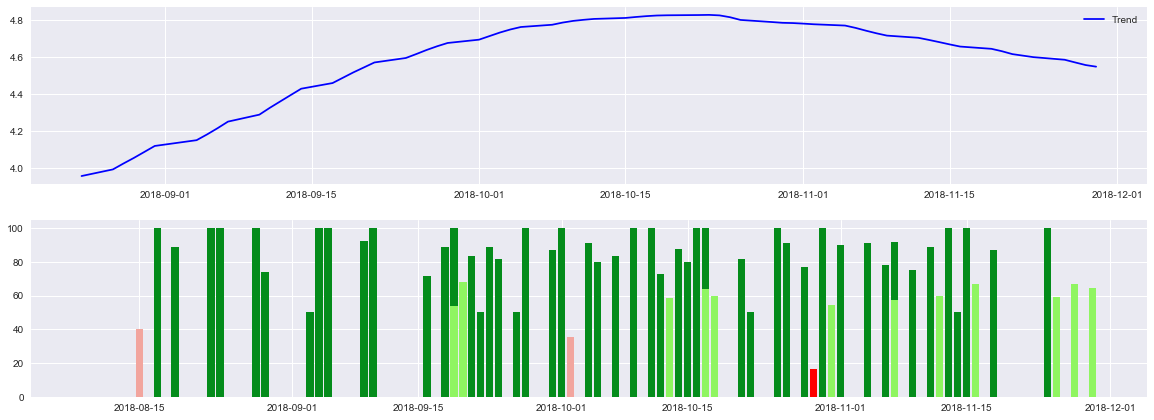

In [487]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

#graphing the trend line of tlry_open, during the length of time for which we've scraped articles
decomposition = seasonal_decompose((np.log(tlry_open)), freq=52)

trend = decomposition.trend
cutoff = '2018-11-29'

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(trend[trend.index <= cutoff], label='Trend', color="blue")
plt.legend(loc='best') 

#creating masks so that each positivity range is graphed with a different color
plt.gcf().set_size_inches(20, 10)
mask1 = ((tlry_df['Positivity'] > 16) & (tlry_df['Positivity'] < 35))
mask2 = ((tlry_df['Positivity'] > 35) & (tlry_df['Positivity'] < 50))
mask3 = ((tlry_df['Positivity'] == 50) & (tlry_df['Positivity'] == 0))
mask4 = ((tlry_df['Positivity'] > 50) & (tlry_df['Positivity'] < 70))
mask5 = (tlry_df['Positivity'] > 70)

colors = np.array(['#048C1B']*len(tlry_df))
colors[mask1.values] = 'r'
colors[mask2.values] = '#F2A59E'
colors[mask3.values] = '#C3CFCA'
colors[mask4.values] = '#8FF561'
colors[mask5.values] = '#048C1B'

plt.subplot(412)
plt.bar(tlry_df.index, tlry_df['Positivity'], color=colors)

plt.gcf().set_size_inches(20, 15)
plt.show()

- 16-35% Positivity = Red
- 35-50% Positivity = Pink
- 50-70% Positivity = Light Green
- 70%+ Positivity = Green

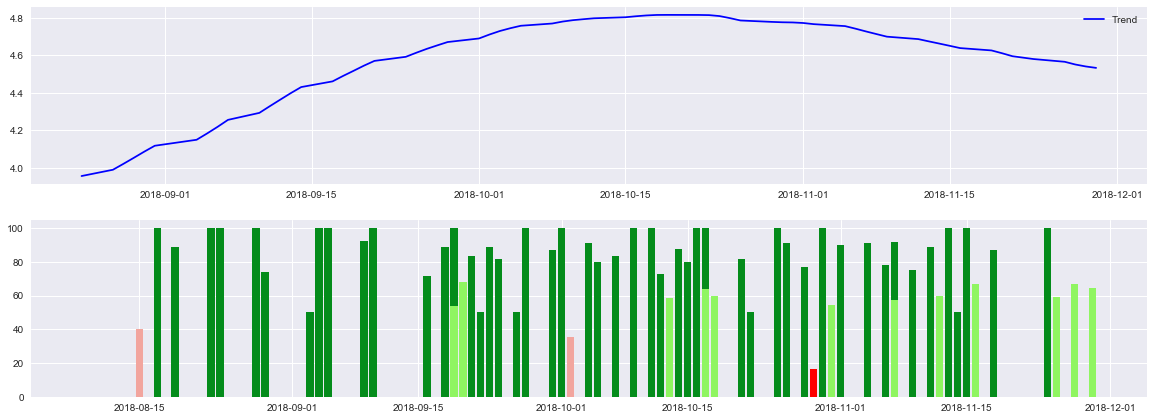

In [488]:
#graphing the trend line of tlry_open, during the length of time for which we've scraped articles
decomposition = seasonal_decompose((np.log(tlry_close)), freq=52)

trend = decomposition.trend
cutoff = '2018-11-29'

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(trend[trend.index <= cutoff], label='Trend', color="blue")
plt.legend(loc='best')

#creating masks so that each positivity range is graphed with a different color
plt.gcf().set_size_inches(20, 10)
mask1 = ((tlry_df['Positivity'] > 16) & (tlry_df['Positivity'] < 35))
mask2 = ((tlry_df['Positivity'] > 35) & (tlry_df['Positivity'] < 50))
mask3 = ((tlry_df['Positivity'] == 50) & (tlry_df['Positivity'] == 0))
mask4 = ((tlry_df['Positivity'] > 50) & (tlry_df['Positivity'] < 70))
mask5 = (tlry_df['Positivity'] > 70)

colors = np.array(['#048C1B']*len(tlry_df))
colors[mask1.values] = 'r'
colors[mask2.values] = '#F2A59E'
colors[mask3.values] = '#C3CFCA'
colors[mask4.values] = '#8FF561'
colors[mask5.values] = '#048C1B'

plt.subplot(412)
plt.bar(tlry_df.index, tlry_df['Positivity'], color=colors)

plt.gcf().set_size_inches(20, 15)
plt.show()

- 16-35% Positivity = Red
- 35-50% Positivity = Pink
- 50-70% Positivity = Light Green
- 70%+ Positivity = Green

# Conclusion

As you can see from both plots, the trend's growth rate decreases as the media articles get worse. Although we cannot be certain whether the sentiment caused the decline by influencing share-holders, August's growth was certainly met by positive write-ups. The lesson here for investors and financial writers alike, is not to fall victim to growth driven solely by animal spirits. Such growth is artificial and extremely tricky to short-sell profitably.

## Future Research

- Extending the sentiment analysis to the life of all four stocks included in the first half of the project (TLRY, ACB, CGC, CRON)

- Expand the sentiment analysis to adverbs and verb as well as adjectives.

- Predict future prices and use sentiment analysis classifier to predict the weight of influence or how long the influence lasts after initial stock launch